In [1]:
!pip install torchsummary

## Dataset Download - Kaggle

In [2]:
from google.colab import userdata
import os
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

### Handwritten Signature Datasets
[Dataset Link](https://www.kaggle.com/datasets/ishanikathuria/handwritten-signature-datasets/)

In [3]:
!kaggle datasets download -d saurabstha5/signature-forgery-dataset
!unzip signature-forgery-dataset.zip -d forgeryDataset

Streaming output truncated to the last 5000 lines.
  inflating: forgeryDataset/Train/146/H-S-146-F-17.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-18.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-19.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-20.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-21.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-22.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-23.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-24.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-25.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-26.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-27.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-28.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-29.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-F-30.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-G-01.jpg  
  inflating: forgeryDataset/Train/146/H-S-146-G-02.jpg  
  inflating: forgeryDataset/Train/146

### Additional Dataset: Signature Forgery Dataset
[Dataset Link](https://www.kaggle.com/datasets/saurabstha5/signature-forgery-dataset/data)

In [4]:
!kaggle datasets download -d ishanikathuria/handwritten-signature-datasets/
!unzip handwritten-signature-datasets.zip -d signatureDataset

Streaming output truncated to the last 5000 lines.
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-17.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-18.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-19.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-20.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-21.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-22.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-23.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-24.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-25.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-26.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-27.tif  
  inflating: signatureDataset/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-28.tif  
 

In [5]:
import time
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from statistics import mean

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler
from torchsummary import summary

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from itertools import combinations

import random
from tqdm import tqdm # Progress Bar

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
from statistics import mean

import cv2

import itertools
import random
import os

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from scipy.ndimage import rotate


In [6]:
# Move the processed image to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
#paths
forgery_path = "/content/forgeryDataset"
handwritten_path = "/content/signatureDataset"

# **Required Functions**

In [8]:
def random_images(dataset_folder):
    """
    This function collects the paths of random images from a dataset folder.

    Args:
        dataset_folder (str): The path to the folder containing the dataset.
            This folder is assumed to have subfolders, each representing a
            category or signature in the dataset. Images are expected to be
            present within these subfolders.

    Returns:
        list: A list containing the full paths (including filenames) of the
            randomly selected images from the dataset.
    """
    random_images = []
    for signature_folder in os.listdir(dataset_folder):
            # Construct the path to the subfolder
            signature_folder_path = os.path.join(dataset_folder, signature_folder)
            filenames = os.listdir(signature_folder_path)
            for filename in filenames:
                image_path = os.path.join(signature_folder_path, filename)
                random_images.append(image_path)

    print("image size: ", len(random_images))
    print("file size: ", len(filenames))
    return random_images


def triplet_dataset_preparation(dataset_folder):

    """
    This function prepares a dataset of triplets (anchor, positive, negative)
    for training a signature verification model using the triplet loss.

    Args:
        dataset_folder (str): Path to the folder containing the dataset.
            This folder is assumed to have subfolders, each representing a
            signature (genuine images) and potentially a 'forgeries' subfolder
            containing forged images. Filenames can optionally contain markers
            like 'original', '-G-', 'forgeries', '-F-', or 'forge' to identify
            genuine and forged images.

    Returns:
        pandas.DataFrame: A DataFrame containing three columns:
            - 'Anchor_Path': Path to the anchor image (genuine)
            - 'Positive_Path': Path to a positive image (another genuine image)
            - 'Negative_Path': Path to a negative image (forged image)

    Prints (for informational purposes only):
        - Total number of images found.
        - Numbers of genuine and forged images identified.
        - Path to the last image in the forged image list.
    """

    # Collect all image paths from the dataset folder
    image_paths = random_images(dataset_folder)
    print(f"image len: {len(image_paths)}")  # Informational print
    data = []
    print("-------------triplet dataset preparation-----------------")
    for signature_folder in os.listdir(dataset_folder):
        signature_folder_path = os.path.join(dataset_folder, signature_folder)
        genuine_images = []
        forged_images = []
        for filename in os.listdir(signature_folder_path):
            # Identify genuine images based on filename markers
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(os.path.join(signature_folder_path, filename))
            # Identify forged images based on filename markers
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(os.path.join(signature_folder_path, filename))

        # Add random images to forged images
        additional_images = random.sample(image_paths, 10)
        forged_images.extend(additional_images)

        # Determine the number of triplet combinations to create (balanced)
        num_combinations = min(
            len(genuine_images) * (len(genuine_images) - 1) // 2,
            len(genuine_images) * len(forged_images)
        )

        # Randomly sample combinations of genuine image pairs
        genuine_combinations = random.sample(
            list(itertools.combinations(genuine_images, 2)), num_combinations
        )

        # Randomly sample combinations of genuine and forged images
        forged_combinations = random.sample(
            list(itertools.product(genuine_images, forged_images)), num_combinations
        )

        # Create triplets from the combinations and add them to the data list
        for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
            anchor_path = os.path.join(image_1)
            positive_path = os.path.join(image_2)
            negative_path = os.path.join(forged_image)
            data.append([anchor_path, positive_path, negative_path])
    df = pd.DataFrame(data, columns=['Anchor_Path', 'Positive_Path', 'Negative_Path'])
    print(f"genuine_images: {len(genuine_images)}\nforged_images {len(forged_images)}")
    print("last forge image", forged_images[-1])  # Informational print
    return df


def duplet_dataset_preparation(dataset_folder):

    """
    This function prepares a dataset of duplets (image pairs)
    for training a logistic regression model for signature verification.

    Args:
        dataset_folder (str): Path to the folder containing the dataset.
            This folder is assumed to have subfolders, each representing a
            signature (genuine images) and potentially a 'forgeries' subfolder
            containing forged images. Filenames can optionally contain markers
            like 'original', '-G-', 'forgeries', '-F-', or 'forge' to identify
            genuine and forged images.

    Returns:
        pandas.DataFrame: A DataFrame containing three columns:
            - 'Image1_Path': Path to the first image in the duplet
            - 'Image2_Path': Path to the second image in the duplet
            - 'Label': Class label (0 for genuine pair, 1 for mixed pair)

    Prints (for informational purposes only):
        - Numbers of genuine and forged images identified.
        - A counter variable (its purpose is unclear from the code).
    """
    image_paths = random_images(dataset_folder)
    print("-------------duplet dataset preparation-----------------")
    data = []
    for signature_folder in os.listdir(dataset_folder):
        signature_folder_path = os.path.join(dataset_folder, signature_folder)
        genuine_images = []
        forged_images = []
        for filename in os.listdir(signature_folder_path):

            # Identify genuine images based on filename markers
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(os.path.join(signature_folder_path, filename))

            # Identify forged images based on filename markers
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(os.path.join(signature_folder_path, filename))

        # Add random images to forged images
        additional_images = random.sample(image_paths, 10)
        forged_images.extend(additional_images)

        # Determine the number of combinations to create (balanced)
        num_genuine_images = len(genuine_images)
        num_forged_images = len(forged_images)
        num_combinations = min(
            num_genuine_images * (num_genuine_images - 1) // 2, num_genuine_images * num_forged_images
        )

        # Randomly sample combinations of genuine image pairs
        genuine_combinations = random.sample(
            list(itertools.combinations(genuine_images, 2)), num_combinations
        )

        # Randomly sample combinations of genuine and forged images
        forged_combinations = random.sample(
            list(itertools.product(genuine_images, forged_images)), num_combinations
        )
        for (image_1, image_2), (genuine_image, forged_image) in zip(genuine_combinations, forged_combinations):
            anchor_path = os.path.join(image_1)
            positive_path = os.path.join(image_2)
            label = 0
            data.append([anchor_path, positive_path, label])

            anchor_path = os.path.join(genuine_image)
            positive_path = os.path.join(forged_image)
            label = 1
            data.append([anchor_path, positive_path, label])

        df = pd.DataFrame(data, columns=['Image1', 'Image2', 'Label'])
    return df


class TripletDataset(Dataset):
    """
    This class represents a custom PyTorch Dataset for loading and preprocessing triplet data.

    Args:
        training_df (pandas.DataFrame, optional): A pandas DataFrame containing three columns:
            - 'Anchor_Path': Path to the anchor image (genuine)
            - 'Positive_Path': Path to a positive image (another genuine image)
            - 'Negative_Path': Path to a negative image (forged image)
        transform (callable, optional): A function or sequence of functions to apply for data augmentation
            or other preprocessing tasks to the images.

    Attributes:
        training_df (pandas.DataFrame): The DataFrame containing triplet information.
        transform (callable, optional): The transformation function(s) to apply.
    """

    def __init__(self, training_df=None, transform=None):
        """
        Initialization function for the TripletDataset class.

        Args:
            training_df (pandas.DataFrame, optional): A pandas DataFrame containing three columns
                (see class docstring for details).
            transform (callable, optional): A function or sequence of functions for preprocessing.
        """
        self.training_df = training_df
        self.training_df.columns = ["Anchor_Path", "Positive_Path", "Negative_Path"]
        self.transform = transform

    def __getitem__(self, index):
        """
        Retrieves a triplet (anchor, positive, negative) image at the specified index from the dataset.

        Args:
            index (int): The index of the triplet to retrieve.

        Returns:
            tuple: A tuple containing three PIL Image objects representing the anchor,
                   positive, and negative images in the triplet. Preprocessed and potentially transformed
                   if defined during initialization.
        """

        # Extract image paths from the DataFrame
        anchor_path = os.path.join(self.training_df.iat[int(index), 0])
        positive_path = os.path.join(self.training_df.iat[int(index), 1])
        negative_path = os.path.join(self.training_df.iat[int(index), 2])

        # Load images using PIL
        anchor_img = Image.open(anchor_path)
        positive_img = Image.open(positive_path)
        negative_img = Image.open(negative_path)

        # Preprocess the images using the provided function (assumed)
        anchor_img = preprocess_image(anchor_img)
        positive_img = preprocess_image(positive_img)
        negative_img = preprocess_image(negative_img)

        # Apply transformations (e.g., data augmentation) if defined
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        # Return the triplet of preprocessed and potentially transformed images
        return anchor_img, positive_img, negative_img

    def __len__(self):
        """
        Returns the length of the dataset, which is the number of triplets in the training DataFrame.
        """
        return len(self.training_df)


class DupletDataset(Dataset):
    """
    This class represents a custom PyTorch Dataset for loading and preprocessing duplet data.

    Args:
        dataframe (pandas.DataFrame, optional): A pandas DataFrame containing three columns:
            - 'image1': Path to the first image in the duplet.
            - 'image2': Path to the second image in the duplet.
            - 'label': Class label indicating the type of duplet (0 for genuine pair, 1 for mixed pair).
        transform (callable, optional): A function or sequence of functions to apply for data augmentation
            or other preprocessing tasks to the images.

    Attributes:
        training_df (pandas.DataFrame): The DataFrame containing duplet information.
        transform (callable, optional): The transformation function(s) to apply.
    """

    def __init__(self, dataframe=None, transform=None):
        """
        Initialization function for the DupletDataset class.

        Args:
            dataframe (pandas.DataFrame, optional): A pandas DataFrame containing three columns
                (see class docstring for details).
            transform (callable, optional): A function or sequence of functions for preprocessing.
        """
        self.training_df = dataframe
        self.training_df.columns = ["image1", "image2", "label"]
        self.transform = transform

    def __getitem__(self, index):
        """
        Retrieves a duplet (image1, image2, label) at the specified index from the dataset.

        Args:
            index (int): The index of the duplet to retrieve.

        Returns:
            tuple: A tuple containing three elements:
                - First PIL Image object representing the first image in the duplet.
                - Second PIL Image object representing the second image in the duplet.
                - Integer label indicating the type of duplet (0 for genuine pair, 1 for mixed pair).
                Preprocessed and potentially transformed if defined during initialization.
        """

        # Extract image paths and label from the DataFrame
        image1_path = os.path.join(self.training_df.iat[int(index), 0])
        image2_path = os.path.join(self.training_df.iat[int(index), 1])

        # Load images using PIL
        image1 = Image.open(image1_path)
        image2 = Image.open(image2_path)

        # Preprocess the images using the provided function (assumed)
        image1 = preprocess_image(image1)
        image2 = preprocess_image(image2)

        # Apply transformations (e.g., data augmentation) if defined
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        label = torch.from_numpy(np.array([int(self.training_df.iat[int(index), 2])], dtype=np.float32))

        # Return the duplet of preprocessed and potentially transformed images along with the label
        return image1, image2, label

    def __len__(self):
        """
        Returns the length of the dataset, which is the number of duplets in the DataFrame.
        """
        return len(self.training_df)


def preprocess_image(image_pth):
    """
    This function preprocesses an image for signature verification tasks.

    Args:
        image_pth (str): Path to the image file.

    Returns:
        PIL.Image: The preprocessed image as a PIL Image object.

    Performs the following preprocessing steps:
        1. Conversion to grayscale.
        2. Application of median blur for noise reduction.
        3. Morphological operations (erosion and dilation) to enhance foreground (signature).
        4. Thresholding to create a binary image.
        5. Bounding box extraction based on non-white pixels (signature area).
        6. Padding of the bounding box to account for potential variations.
        7. Cropping the image using the modified bounding box.
        8. Adding extra white space around the cropped image.
        9. Conversion back to a PIL Image object.
    """

    # convert image to grayscale
    image = image_pth.convert("L")

    # Convert the grayscale image to a NumPy array for further processing
    img = np.array(image)

    # Apply median blur for noise reduction
    blur = cv2.medianBlur(img, 3)

    # Define a structuring element for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    # Perform erosion to remove small white details (noise)
    erode = cv2.erode(blur, kernel, iterations=2)

    # Perform dilation to slightly thicken the foreground (signature)
    dilate = cv2.dilate(erode, kernel, iterations=1)

    # Apply thresholding to create a binary image (black and white)
    _, binary = cv2.threshold(dilate, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find the bounding box coordinates of the non-white pixels (signature)
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    # Add padding to the bounding box to account for potential variations
    padding = 20  # Adjust this parameter as needed
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    # Ensure the coordinates are within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the image using the modified bounding box coordinates
    cropped_image = binary[y:y + h, x:x + w]

    # Add extra white space around the cropped image for better representation
    extra_space = np.zeros((cropped_image.shape[0] + 2 * padding,
                            cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image

    # Convert the NumPy array back to a PIL Image object
    resized_image = Image.fromarray(extra_space)

    return resized_image


def plot_images(img):
    """
    This function visualizes an image before and after applying the preprocessing steps.

    Args:
        img (PIL.Image): The image to be preprocessed and visualized.
    """

    # Create a Matplotlib figure with a subplot having 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    # Display the original image on the first subplot
    axes[0].imshow(img)
    axes[0].axis('off')  # Hide the axes for a cleaner visualization
    axes[0].set_title("Original Image")  # Set the title for the original image

    # Preprocess the image using the defined `preprocess_image` function
    preprocessed_image = preprocess_image(img)
    print(f"Preprocessed image size: {preprocessed_image.size}")  # Informative output

    # Display the preprocessed image on the second subplot
    axes[1].imshow(preprocessed_image)
    axes[1].axis('off')
    axes[1].set_title("Preprocessed Image")


def show_triplets_from_dataloader(dataloader, num_triplets=3):
    """
    This function displays triplets (anchor, positive, negative images) from a PyTorch DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): The PyTorch DataLoader containing triplets.
        num_triplets (int, optional): The number of triplets to display (default: 3).
    """

    # Loop through batches in the dataloader
    for batch_idx, (anchor_imgs, positive_imgs, negative_imgs) in enumerate(dataloader):
        # Limit the number of triplets displayed from the current batch
        for i in range(min(len(anchor_imgs), num_triplets)):
            fig, axes = plt.subplots(1, 3, figsize=(8, 4))

            # Permute tensor dimensions for correct image display (assuming channels first format)
            axes[0].imshow(anchor_imgs[i].permute(1, 2, 0))  # Anchor image
            axes[0].set_title("Anchor")
            axes[1].imshow(positive_imgs[i].permute(1, 2, 0))  # Positive image
            axes[1].set_title("Positive")
            axes[2].imshow(negative_imgs[i].permute(1, 2, 0))  # Negative image
            axes[2].set_title("Negative")
            plt.tight_layout()
            plt.show()


class SpatialAttention(nn.Module):
    """
    This class implements a spatial attention mechanism for convolutional neural networks.

    The spatial attention mechanism dynamically weights feature channels in a feature map
    based on their importance, leading to a more focused representation.

    Args:
        in_channels (int): The number of input channels in the feature map.
    """

    def __init__(self, in_channels):
        """
        Initializes the SpatialAttention module.

        Args:
            in_channels (int): The number of input channels in the feature map (same as in the docstring).
        """

        super(SpatialAttention, self).__init__()
        # 1x1 convolution layer to compute attention scores for each spatial location
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        # Sigmoid activation for normalized attention weights (between 0 and 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Performs the spatial attention operation on the input feature map.

        Args:
            x (torch.Tensor): The input feature map with dimensions (batch_size, channels, height, width).

        Returns:
            torch.Tensor: The feature map with applied spatial attention (same dimensions as input).
        """

        # Calculate attention scores using a 1x1 convolution (channel-wise)
        attention_scores = self.conv(x)

        # Apply sigmoid activation to get weights between 0 and 1
        attention_weights = self.sigmoid(attention_scores)

        # Multiply the input feature map with the attention weights for element-wise weighting
        attended_features = x * attention_weights
        return attended_features


class SiameseResNet(nn.Module):
    """
    This class implements a Siamese network with a ResNet backbone
    and spatial attention mechanism for signature verification.

    A Siamese network processes two input images (signature pairs)
    through a shared convolutional neural network (CNN) architecture
    to extract feature vectors. The similarity between these feature
    vectors is then used to determine if the signatures are genuine
    or forged.

    This specific implementation uses a ResNet-18 backbone with
    spatial attention modules added to specific layers. Spatial
    attention dynamically weights feature channels based on their
    importance, potentially improving the network's ability to focus
    on relevant signature details.

    Args:
        model_name (str, optional): The name of the pre-trained ResNet model
            to use as the backbone (default: 'resnet18'). Other options
            might include 'resnet34', 'resnet50', etc.
        pretrained (bool, optional): Whether to load the pre-trained weights
            for the ResNet backbone (default: False). Using pre-trained
            weights can improve performance on similar tasks.
    """

    def __init__(self, model_name='resnet18', pretrained=False):
        """
        Initializes the SiameseResNet model.

        Args:
            model_name (str, optional): Same as in the docstring.
            pretrained (bool, optional): Same as in the docstring.
        """

        super(SiameseResNet, self).__init__()

        # Load the pre-trained ResNet model (without the fully connected layer)
        self.model_name = model_name
        self.pretrained = pretrained
        self.baseModel = getattr(models, self.model_name)(pretrained=pretrained)

        # Experiment with different spatial attention module placements based on signature complexity
        self.attention1 = SpatialAttention(in_channels=64)  # Spatial attention for layer 1
        self.attention2 = SpatialAttention(in_channels=128)  # Spatial attention for layer 2

        # Modify the first convolutional layer to accept single-channel grayscale images
        self.baseModel.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.baseModel.fc = nn.Identity()  # Remove the final FC layer

    def forward(self, x):
        """
        Performs the forward pass through the Siamese network.

        Args:
            x (torch.Tensor): The input tensor containing two signature images
                concatenated along the batch dimension (batch_size, 2, channels, height, width).

        Returns:
            torch.Tensor: A tensor containing two feature vectors, one for
                each input image (batch_size, 2, feature_dim).
        """

        # Pass the anchor image through the initial layers of ResNet
        anchor_out = self.baseModel.conv1(x)
        anchor_out = self.baseModel.bn1(anchor_out)
        anchor_out = self.baseModel.relu(anchor_out)
        anchor_out = self.baseModel.maxpool(anchor_out)

        # Apply spatial attention to layers 1 and 2 for the anchor image
        anchor_out = self.attention1(self.baseModel.layer1(anchor_out))
        anchor_out = self.attention2(self.baseModel.layer2(anchor_out))

        # Pass both image features through the remaining ResNet layers
        anchor_out = self.baseModel.layer3(anchor_out)
        anchor_out = self.baseModel.layer4(anchor_out)

        # Global average pooling and flattening
        anchor_out = self.baseModel.avgpool(anchor_out)
        anchor_out = torch.flatten(anchor_out, 1)
        return anchor_out


class TripletLoss(nn.Module):
    """
    This class implements the triplet loss function commonly used for training
    triplet networks for tasks like signature verification.

    The triplet loss encourages the network to embed similar images (e.g., genuine
    signature pairs) closer together in the feature space while pushing dissimilar
    images (e.g., a genuine signature and a forgery) further apart.

    Args:
        margin (float, optional): The margin value used in the triplet loss
            function (default: 1.0). A larger margin encourages a greater
            separation between similar and dissimilar embeddings.
    """

    def __init__(self, margin=1.0):
        """
        Initializes the TripletLoss module.

        Args:
            margin (float, optional): Same as in the docstring.
        """

        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Calculates the triplet loss for a batch of anchor, positive, and negative samples.

        Args:
            anchor (torch.Tensor): The feature vector representing the anchor image
                (batch_size, feature_dim).
            positive (torch.Tensor): The feature vector representing the positive
                image (genuine pair of the anchor) (batch_size, feature_dim).
            negative (torch.Tensor): The feature vector representing the negative
                image (dissimilar to the anchor) (batch_size, feature_dim).

        Returns:
            torch.Tensor: The mean triplet loss for the batch (scalar).
        """

        # Calculate the Euclidean distances between feature vectors using pairwise_distance
        distance_anchor_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_anchor_negative = F.pairwise_distance(anchor, negative, p=2)

        # Calculate the triplet loss using the margin
        loss = torch.clamp(distance_anchor_positive - distance_anchor_negative + self.margin, min=0.0)

        # Return the mean loss across the batch
        return loss.mean()


def train_siamese_model(model, loader, n_epochs, optimizer, loss_fn):
    """
    This function trains a Siamese network model for signature verification using a triplet loss.

    Args:
        model (nn.Module): The Siamese network model to be trained.
        loader (torch.utils.data.DataLoader): The DataLoader containing triplets of images for training.
        n_epochs (int): The number of training epochs.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model weights (e.g., Adam).
        loss_fn (nn.Module): The loss function used for training (e.g., TripletLoss).

    Returns:
        dict: A dictionary containing the training history with a key 'train_loss'
              storing the average training loss for each epoch.
    """

    history = {'train_loss': []}
    print("------------------------Training--------------------------")

    # Loop through epochs
    for epoch in range(1, n_epochs + 1):
        start_time = datetime.now()  # Track training duration
        print(f"Beginning Epoch {epoch}/{n_epochs}...")

        train_loss = []
        model.train()  # Set the model to training mode

        # Loop through batches in the data loader
        for i, data in enumerate(tqdm(loader, 0)):
            # Extract anchor, positive, and negative images from the batch
            anchor, positive, negative = data

            # Move data to the specified device (e.g., GPU)
            anchor = anchor.to(device=device)
            positive = positive.to(device=device)
            negative = negative.to(device=device)

            # Clear gradients from the previous iteration
            optimizer.zero_grad()

            # Forward pass through the model to get feature embeddings
            anchor_embeddings = model(anchor)
            positive_embeddings = model(positive)
            negative_embeddings = model(negative)

            # Calculate the loss using the provided loss function
            loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

            # Backpropagate the loss and update model weights
            loss.backward()
            optimizer.step()

            # Append the current batch loss to the training loss list
            train_loss.append(loss.item())

        # Calculate and display epoch duration
        epoch_duration = datetime.now() - start_time
        print('\nEpoch: {}\tTrain Loss: {:.4f}\tDuration: {}'.format(epoch, np.mean(train_loss), epoch_duration))

        # Track average training loss for each epoch
        history['train_loss'].append(np.mean(train_loss))
    return history


class LogisticSiameseRegression(nn.Module):
    """
    This class implements a logistic regression classifier on top of a pre-trained
    Siamese network for signature verification.

    The Siamese network extracts feature embeddings for two input images (signature
    pair). This class then calculates the difference between these embeddings
    and feeds it into a fully-connected neural network with a sigmoid activation
    function. The output of the network represents the probability of the input
    images belonging to the same genuine signature class (positive class) or
    different classes (forged signature).

    Args:
        model (nn.Module): The pre-trained Siamese network model.
    """

    def __init__(self, model):
        """
        Initializes the LogisticSiameseRegression module.

        Args:
            model (nn.Module): Same as in the docstring.
        """

        super(LogisticSiameseRegression, self).__init__()
        self.model = model

        # Define a fully-connected network with ReLU activation and final sigmoid layer
        self.fc = nn.Sequential(
            nn.Linear(512, 128),  # Input dimension might depend on the Siamese network output
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        """
        Performs a single forward pass through the Siamese network backbone.

        Args:
            x (torch.Tensor): The input image (batch_size, channels, height, width).

        Returns:
            torch.Tensor: The normalized feature embedding for the input image
                (batch_size, feature_dim).
        """

        # Pass the input through the pre-trained Siamese network
        out = self.model(x)

        # Apply L2 normalization to the feature embeddings
        out = F.normalize(out, p=2, dim=1)
        return out

    def forward(self, x1, x2):
        """
        Calculates the probability of two input images belonging to the same class.

        Args:
            x1 (torch.Tensor): The first input image (batch_size, channels, height, width).
            x2 (torch.Tensor): The second input image (batch_size, channels, height, width).

        Returns:
            torch.Tensor: The probability of x1 and x2 belonging to the same class
                (batch_size, 1) between 0 (dissimilar) and 1 (similar).
        """

        # Get normalized feature embeddings for both input images
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)

        # Calculate the element-wise difference between embeddings
        diff = out1 - out2

        # Pass the difference through the fully-connected layers for classification
        out = self.fc(diff)
        out = self.sigmoid(out)
        return out


def train(model, input1, input2, outputs, optimizer, loss_fn):
    """
    Performs a single training step for the logistic Siamese regression model.

    This function takes a batch of input data (two images per sample) and
    corresponding labels, performs a forward pass through the model, calculates
    the loss using the provided loss function, backpropagates the gradients,
    and updates the model weights using the optimizer.

    Args:
        model (nn.Module): The LogisticSiameseRegression model to be trained.
        input1 (torch.Tensor): The first input image in the batch (batch_size, channels, height, width).
        input2 (torch.Tensor): The second input image in the batch (batch_size, channels, height, width).
        outputs (torch.Tensor): The ground truth labels for the batch (batch_size, 1).
        optimizer (torch.optim.Optimizer): The optimizer used for weight updates (e.g., Adam).
        loss_fn (nn.Module): The loss function used for training (e.g., nn.BCELoss).

    Returns:
        tuple: A tuple containing the calculated loss (scalar) and the model's predictions (torch.Tensor).
    """

    # Set the model to training mode
    model.train()

    # Clear gradients from the previous iteration
    optimizer.zero_grad()

    # Forward pass to get model predictions
    predictions = model(input1, input2)

    # Calculate the loss based on predictions and ground truth labels
    loss = loss_fn(predictions, outputs)

    # Backpropagate the loss to compute gradients
    loss.backward()

    # Update model weights based on the calculated gradients
    optimizer.step()
    return loss, predictions


def train_model(model, train_loader, test_loader, n_epochs, optimizer, loss_fn):
    """
    Trains a logistic Siamese regression model for signature verification over multiple epochs.

    This function trains the model on a training dataset (train_loader) and
    evaluates its performance on a validation dataset (test_loader) for a
    specified number of epochs (n_epochs). It tracks and returns training and
    validation loss and accuracy for each epoch.

    Args:
        model (nn.Module): The LogisticSiameseRegression model to be trained.
        train_loader (torch.utils.data.DataLoader): The DataLoader containing training data.
        test_loader (torch.utils.data.DataLoader): The DataLoader containing validation data.
        n_epochs (int): The number of training epochs.
        optimizer (torch.optim.Optimizer): The optimizer used for weight updates (e.g., Adam).
        loss_fn (nn.Module): The loss function used for training (e.g., nn.BCELoss).

    Returns:
        dict: A dictionary containing the training history with keys:
            - 'train_loss': List of average training loss per epoch.
            - 'train_acc': List of average training accuracy per epoch.
            - 'valid_loss': List of average validation loss per epoch.
            - 'valid_acc': List of average validation accuracy per epoch.
    """

    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
    print("------------------------Training--------------------------")

    # Loop through epochs
    for epoch in range(1, n_epochs + 1):
        start_time = datetime.now()  # Track training duration
        print(f"Beginning Epoch {epoch}/{n_epochs}...")

        # Training phase
        train_loss = []
        train_acc = []
        model.train()  # Set model to training mode
        for i, data in tqdm(enumerate(train_loader, 0)):
            inputs1, inputs2, targets = data

            # Move data to the specified device (e.g., GPU)
            inputs1 = inputs1.to(device=device)
            inputs2 = inputs2.to(device=device)
            targets = targets.to(device=device)

            # Perform a single training step
            loss, predictions = train(model, inputs1, inputs2, targets, optimizer, loss_fn)

            # Accumulate training loss and accuracy
            train_loss.append(loss.item())
            accuracy = (predictions.round() == targets).float().mean().item()
            train_acc.append(accuracy)

        # Validation phase
        valid_loss = []
        valid_acc = []
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for i, data in tqdm(enumerate(test_loader, 0)):
                inputs1, inputs2, targets = data

                # Move data to the specified device
                inputs1 = inputs1.to(device=device)
                inputs2 = inputs2.to(device=device)
                targets = targets.to(device=device)

                # Perform a forward pass without gradients
                output = model(inputs1, inputs2)
                loss = loss_fn(output, targets)

                # Accumulate validation loss and accuracy
                valid_loss.append(loss.item())
                accuracy = (output.round() == targets).float().mean().item()
                valid_acc.append(accuracy)

        # Calculate and display epoch duration
        epoch_duration = datetime.now() - start_time
        print('\nEpoch: {}\t\tTrain Loss: {:.4f}\tTrain Accuracy: {:.4f}\nDuration: {}\tValid Loss: {:.4f}\tValid Accuracy: {:.4f}\n'.format(
            epoch, np.mean(train_loss), np.mean(train_acc), epoch_duration, np.mean(valid_loss), np.mean(valid_acc)
        ))

        # Track training and validation metrics for each epoch
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
        history['valid_loss'].append(np.mean(valid_loss))
        history['valid_acc'].append(np.mean(valid_acc))
    return history


def plot_acc_loss(history, num_epochs):
    """
    Visualizes the training and validation accuracy and loss curves of a trained model.

    Args:
        history (dict): A dictionary containing the training history with keys:
            - 'train_loss': List of average training loss per epoch.
            - 'train_acc': List of average training accuracy per epoch.
            - 'valid_loss': List of average validation loss per epoch.
            - 'valid_acc': List of average validation accuracy per epoch.
        num_epochs (int): The total number of training epochs.
    """

    # Create a figure and separate subplots for accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # Plot training and validation accuracy curves
    axes[0].plot(range(1, num_epochs + 1), history['train_acc'], 'b', label='Training Accuracy')
    axes[0].plot(range(1, num_epochs + 1), history['valid_acc'], 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy of Model', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontsize=14)
    axes[0].legend()

    # Plot training and validation loss curves
    axes[1].plot(range(1, num_epochs + 1), history['train_loss'], 'b', label='Training Loss')
    axes[1].plot(range(1, num_epochs + 1), history['valid_loss'], 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss of Model', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Loss', fontsize=14)
    axes[1].legend()
    plt.show()


def calculate_accuracy(data_loader, model):
    """
    Calculates the accuracy of a logistic Siamese regression model on a given dataset.

    This function evaluates the model's performance on a dataset (data_loader)
    by comparing the model's predictions with the ground truth labels. It
    assumes the model outputs probabilities between 0 and 1, and uses a threshold
    of 0.5 to convert them to binary class predictions (0 or 1).

    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing the dataset.
        model (nn.Module): The LogisticSiameseRegression model to be evaluated.

    Returns:
        float: The accuracy of the model on the dataset (percentage).
    """

    model.eval()  # Set the model to evaluation mode (disable dropout etc.)
    correct = 0
    total = 0

    with torch.no_grad():
        # Loop through data in the data loader (disable gradient calculation)
        for data in data_loader:
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            # Get model predictions
            outputs = model(inputs1, inputs2)

            # Convert probabilities to binary predictions based on a threshold
            predictions = (outputs > 0.5).float()  # Threshold of 0.5 for binary classification

            # Count correct predictions
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    # Calculate and return accuracy as a percentage
    accuracy = correct / total * 100
    return accuracy


def get_predictions(data_loader, model):
    """
    Obtains predictions and corresponding labels from a dataset for the logistic Siamese regression model.

    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing the dataset.
        model (nn.Module): The LogisticSiameseRegression model used for prediction.

    Returns:
        tuple: A tuple containing two lists:
            - all_preds (list): A list of model predictions (0 or 1) for each data point.
            - all_labels (list): A list of ground truth labels for each data point.
    """

    all_preds = []
    all_labels = []
    model.eval()  # Set the model to evaluation mode (disable dropout etc.)

    # Loop through data in the data loader (disable gradient calculation)
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader, 0)):
            inputs1, inputs2, targets = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            targets = targets.to(device)

            # Get model predictions
            output = model(inputs1, inputs2)

            # Convert probabilities to binary predictions based on a threshold
            predictions = (output > 0.5).float().tolist()

            # Accumulate predictions and labels
            all_preds.extend(predictions)
            all_labels.extend(targets.tolist())
    return all_preds, all_labels


def build_confusion_matrix(preds, labels):
    """
    Builds and plots a normalized confusion matrix for the logistic Siamese regression model.

    Args:
        preds (list): A list of model predictions (0 or 1) for each data point.
        labels (list): A list of ground truth labels for each data point.
    """

    # Build a confusion matrix using sklearn.metrics
    cm = confusion_matrix(preds, labels)

    # Normalize the confusion matrix to show percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Define labels for the confusion matrix (e.g., Genuine, Forged)
    labels = ['Genuine', 'Forged']

    # Create a heatmap visualization using Seaborn
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
    plt.gca().set_xticklabels(labels, rotation=0)
    plt.gca().set_yticklabels(labels, rotation=0)

    # Set labels and title for the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()


def get_predictions_for_single(img1, img2, model):
    """
    Predicts the similarity of a single pair of signature images using a trained model.

    This function takes the paths to two image files (`img1`, `img2`) and a
    pre-trained logistic Siamese regression model (`model`) as input. It loads
    the images, preprocesses them according to the model's requirements, and
    passes them through the model to obtain a prediction. The prediction
    represents the probability of the signatures being similar (closer to 1)
    or dissimilar (closer to 0). The function then provides a textual interpretation
    based on a threshold (e.g., 0.2).

    Args:
        img1 (str): Path to the first image file (signature).
        img2 (str): Path to the second image file (signature).
        model (nn.Module): The trained logistic Siamese regression model.

    Returns:
        None
    """
    image1 = Image.open(img1)
    plt.imshow(image1)
    plt.show()
    image1 = preprocess_image(image1)  # Assuming a separate preprocessing function

    image2 = Image.open(img2)
    plt.imshow(image2)
    plt.show()
    image2 = preprocess_image(image2)  # Assuming a separate preprocessing function

    # Define image pre-processing steps (replace with actual implementation)
    transform = transforms.Compose([
        transforms.Resize((200, 300)),
        # transforms.Grayscale(num_output_channels=3),  # Uncomment for grayscale conversion if needed
        transforms.ToTensor(),
    ])

    # Convert images to tensors and move them to the device (CPU/GPU)
    input1 = transform(image1).unsqueeze(0).to(device)
    input2 = transform(image2).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(input1, input2)
        print(f"Model prediction: {predictions.item()}")  # Print the raw prediction value

    # Provide a textual interpretation based on a threshold (replace 0.2 with your chosen value)
    if predictions.item() < 0.2:
        print("The signatures are likely similar.")
    else:
        print("The signatures are likely not similar.")

    # Note: This function doesn't explicitly return anything.


def test_preprocess_image(image_pth, delta=1, limit=10):
    """
    Preprocesses an image for testing purposes, aiming to improve robustness
    against minor rotations and distortions.

    This function takes a PIL image path (`image_pth`) and performs various
    transformations and corrections to enhance its suitability for testing
    a signature verification system. It assumes the input image is grayscale.

    Args:
        image_pth (str): Path to the input grayscale image file.
        delta (int, optional): Angle difference between each rotation
            iteration during score calculation (default: 1).
        limit (int, optional): Maximum angle limit for rotation during
            score calculation (default: 10).

    Returns:
        PIL.Image: The preprocessed and potentially corrected image.
    """

    # Define a helper function to calculate a score based on image histogram (implementation not shown)
    def determine_score(arr, angle):
        # implementation details for score calculation omitted
        data = rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    # convert image grayscale (assuming grayscale input)
    gray = image_pth.convert("L")

    # Convert grayscale image to a NumPy array for further processing
    img = np.array(gray)

    # Apply median blur to reduce noise
    blur = cv2.medianBlur(img, 3)

    # Define a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    # Perform erosion to remove small white details
    erode = cv2.erode(blur, kernel, iterations=2)

    # Perform dilation to slightly expand the foreground (signature)
    dilate = cv2.dilate(erode, kernel, iterations=1)

    # Apply thresholding to convert the image to binary (black and white)
    _, binary = cv2.threshold(dilate, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find the bounding box coordinates of the foreground (signature) pixels
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    # Add padding around the bounding box to account for potential minor rotations
    padding = 20  # Adjust padding size as needed

    # Adjust bounding box coordinates to include padding while staying within image boundaries
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the image using the modified bounding box
    cropped_image = binary[y:y+h, x:x+w]

    # Add extra white space around the cropped image
    extra_space = np.zeros((cropped_image.shape[0] + 2 * padding,
                            cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image

    # Initialize a list to store scores for different rotation angles
    scores = []

    # Generate a range of angles for rotation
    angles = np.arange(-limit, limit + delta, delta)

    # Iterate through each angle, calculate score, and find the best angle
    for angle in angles:
        histogram, score = determine_score(extra_space, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]

    # Get image dimensions and calculate the center for rotation
    (h, w) = extra_space.shape[:2]
    center = (w // 2, h // 2)

    # Generate a rotation matrix based on the best angle
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)

    # Apply affine rotation transformation to correct potential minor rotations
    corrected = cv2.warpAffine(extra_space, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Convert the processed NumPy array back to a PIL Image
    resized_image = Image.fromarray(corrected)
    return resized_image


def test_dataset(dataset_folder):
    """
    Creates a Pandas DataFrame for testing purposes, containing information
    about images and their corresponding labels in a signature verification dataset.

    Args:
        dataset_folder (str): Path to the folder containing subfolders with
            signature images for each individual. Subfolder names should
            represent the individual's class. Image filenames may optionally
            contain keywords like 'original' or '-G-' to indicate genuine
            signatures.

    Returns:
        pandas.DataFrame: A DataFrame containing columns for 'ClassName',
            'Testing Image' (path), and 'Label'.
    """

    data = []  # Initialize an empty list to store data dictionaries

    # Iterate through subfolders (assuming subfolders represent individuals)
    for signature_folder in os.listdir(dataset_folder):
        class_name = str(signature_folder)  # Extract class name from subfolder name
        signature_folder_path = os.path.join(dataset_folder, signature_folder)

        # Get list of image filenames in the subfolder
        images = os.listdir(signature_folder_path)

        # Randomly select up to 5 images (or all images if less than 5)
        selected_images = random.sample(images, k=min(5, len(images)))
        for image in selected_images:
            image_path = os.path.join(signature_folder_path, image)

            # Determine label based on filename keywords
            is_genuine = True if 'original' in image or '-G-' in image else False
            label = 0 if is_genuine else 1
            data.append({'ClassName': class_name, 'Image': image_path, 'Label': label})
    df = pd.DataFrame(data)
    return df


def get_genuine_with_class(dataset_folder):
    """
    Creates a Pandas DataFrame containing paths to four genuine signature
    images for each class (individual) in a dataset.

    Args:
        dataset_folder (str): Path to the folder containing subfolders with
            signature images for each individual. Subfolder names should
            represent the individual's class. Image filenames may optionally
            contain keywords like 'original' or '-G-' to indicate genuine
            signatures.

    Returns:
        pandas.DataFrame: A DataFrame containing columns for 'GenuineImages'
            (list of paths) and 'Class'.
    """
    data = []
    for class_folder in os.listdir(dataset_folder):
        class_folder_path = os.path.join(dataset_folder, class_folder)

        # Skip non-directory entries (e.g., non-image files)
        if not os.path.isdir(class_folder_path):
            continue

        genuine_images = []
        counter = 0  # Counter to track the number of genuine images added

        # Find genuine image filenames based on keywords
        for filename in os.listdir(class_folder_path):
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(filename)
                counter += 1
                if counter == 5:  # Stop after finding 4 genuine images
                    break

        # Create entries for the DataFrame with image paths and class name
        for image in genuine_images:
            image_path = os.path.join(class_folder_path, image)
            data.append([image_path, class_folder])
    df = pd.DataFrame(data, columns=['GenuineImages', 'Class'])
    return df


def get_genuine_and_test_images_for_class(df, class_id, test_image):
    """
    Extracts genuine image paths and creates a DataFrame with corresponding test image paths for
    a given class. This function takes a DataFrame (`df`), a class ID (`class_id`), and a test image
    path (`test_image`) as input. It selects genuine image paths for the specified class from the DataFrame
    and creates a new DataFrame with two columns: 'GenuineImages' (list of genuine image paths) and 'TestImage'
    (a list containing the provided test image path repeated for each genuine image).

    Args:
        df (pandas.DataFrame): The DataFrame containing information about classes and images.
        class_id (str): The ID of the class for which to extract genuine images.
        test_image (str): The path to the test image.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'GenuineImages' and 'TestImage'.
    """

    # Filter genuine images for the specified class
    class_images = df.loc[df['Class'] == class_id, 'GenuineImages']
    test_images = [test_image] * len(class_images)
    class_images_df = pd.DataFrame({'GenuineImages': class_images, 'TestImage': test_images})
    return class_images_df


class GenuineTestDataset(Dataset):
    """
    A PyTorch Dataset class for loading and preprocessing genuine and test image pairs.

    This class facilitates creating a PyTorch Dataset for training or evaluating a signature
    verification system. It assumes the presence of a DataFrame (`df`) containing information about
    classes, genuine image paths, and a test image path for each class.

    Args:
        df (pandas.DataFrame): A DataFrame with columns 'GenuineImages' (list of paths) and 'TestImage' (path to a test image).
        transform (callable, optional): A PyTorch transform object to apply to the images (default: None).
    """

    def __init__(self, df, transform=None):
        """
        Initializes the GenuineTestDataset object.

        Args:
            df (pandas.DataFrame): The DataFrame containing image information.
            transform (callable, optional): A PyTorch transform object (default: None).
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset (number of entries).

        Returns:
            int: The number of rows (data entries) in the DataFrame.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Retrieves a pair of preprocessed genuine and test images for a given index.

        This method implements the indexing behavior of the Dataset class. It retrieves a
        row (data entry) from the DataFrame at the specified index and extracts the genuine
        image paths and the test image path. It then opens the images as PIL Images, applies
        the `test_preprocess_image` function (assumed to be defined elsewhere) for preprocessing,
        and optionally applies a user-provided transform. Finally, it returns a tuple containing the
        preprocessed genuine image and test image.

        Args:
            index (int): The index of the data entry to retrieve.

        Returns:
            tuple: A tuple containing two PIL Images: (genuine_image, test_image).
        """
        row = self.df.iloc[index]
        genuine_image_path = row['GenuineImages']
        test_image_path = row['TestImage']

        genuine_image = Image.open(genuine_image_path)
        test_image = Image.open(test_image_path)

        genuine_image = test_preprocess_image(genuine_image)
        test_image = test_preprocess_image(test_image)

        if self.transform is not None:
            genuine_image = self.transform(genuine_image)
            test_image = self.transform(test_image)

        return genuine_image, test_image


def perform_voting(model, dataloader, threshold=0.4):
    """
    Performs majority voting on model predictions for a dataset of genuine and test image pairs.

    This function takes a PyTorch model (`model`), a DataLoader object (`dataloader`), and an optional
    threshold (`threshold`) as input. It iterates through the dataset, retrieves pairs of genuine and
    test images, performs predictions using the model, and accumulates votes based on the predictions.
    The function uses a majority voting approach to determine the final prediction (genuine or forgery)
    for each data entry.

    Args:
        model (nn.Module): PyTorch model used for predicting genuineness.
        dataloader (DataLoader): A DataLoader object containing the dataset of image pairs.
        threshold (float, optional): Threshold for classifying a prediction as genuine (default: 0.4). Predictions below the threshold are considered genuine, while those above are considered forged.

    Returns:
        int: Final prediction based on voting (0 for Genuine, 1 for Forged). This may not
             correspond to the actual class of the last data entry in the dataloader.
    """

    # Set the model to evaluation mode (disable dropout layers etc.)
    model.eval()
    positive_votes = 0
    negative_votes = 0
    for _, data in tqdm(enumerate(dataloader, 0)):
        genuine_image, test_image = data

        # Move images to the same device as the model (e.g., GPU)
        genuine_image = genuine_image.to(device)
        test_image = test_image.to(device)

        # Perform a forward pass to get the model's prediction
        with torch.no_grad():
            output = model(genuine_image, test_image)

        # Update vote count based on the prediction and threshold
        if output < threshold:
            positive_votes += 1
        else:
            negative_votes += 1

    # Determine the final prediction based on the majority vote
    final_prediction = 0 if positive_votes > negative_votes else 1
    return final_prediction


def perform_voting_for_each_test_images(folder, dataset_type):
    """
    Performs signature verification on each test image in a folder and returns predictions and labels.

    This function takes a test image folder path (`folder`), dataset type (`dataset_type`), a PyTorch model (`model_rms`), and a transformation object (`transformation`)
    as input. It performs the following steps for each test image:

    1. Gets a DataFrame containing genuine image paths for each class using `get_genuine_with_class`.
    2. Gets a DataFrame containing test images and corresponding genuine images for each class using `test_dataset`.
    3. Iterates over each row (test image) in the test image DataFrame.
        - Extracts class name, test image path, and label.
        - Gets a DataFrame containing genuine and test images for the current class using `get_genuine_and_test_images_for_class`.
        - Creates a `GenuineTestDataset` instance for the current class data.
        - Creates a DataLoader for the dataset.
        - Performs voting-based prediction on the current test image using `perform_voting` and the model.
        - Appends the prediction and label to respective lists.
        - Prints informative output about the test image, class, label, and prediction.

    Finally, the function returns two lists: one containing predictions for each test image and another containing the corresponding labels.

    Args:
        folder (str): Path to the folder containing test images.
        dataset_type (str): Type of the dataset (e.g., 'CEDAR').
        model_rms (nn.Module): PyTorch model for signature verification.
        transformation (callable): A PyTorch transform object to pre-process images.

    Returns:
        list: A list containing predicted labels (0 for Genuine, 1 for Forged) for each test image.
        list: A list containing ground truth labels (0 for Genuine, 1 for Forged) for each test image.
    """

    # Get DataFrame with genuine images for each class in the test folder
    test_df = get_genuine_with_class(folder)

    # Get DataFrame with test images and corresponding genuine images for all classes
    test_images = test_dataset(folder)
    all_preds = []  # Initialize list to store predictions for all test images
    all_labels = []  # Initialize list to store labels for all test images

    # Iterate through each row (test image) in the test image DataFrame
    for index, row in test_images.iterrows():
        class_name = row['ClassName']
        image_path = row['Image']
        label = row['Label']

        # Get DataFrame containing genuine and test images for the current class
        desired_df = get_genuine_and_test_images_for_class(test_df, class_name, image_path)

        # Create a GenuineTestDataset instance for the current class data
        dataset = GenuineTestDataset(desired_df, transform=transformation)

        # Create a DataLoader for batching and loading the data during prediction
        dataloader = DataLoader(dataset, batch_size=1)

        # Perform voting-based prediction for the current test image
        prediction = perform_voting(model_rms, dataloader)
        all_preds.append(prediction)
        all_labels.append(label)

        # Print informative output for the current test image
        print(f"{class_name}\t{image_path.split(dataset_type)[-1]}\t{label}\t{prediction}")

    return all_preds, all_labels


def evaluation_voting(model, dataloader, threshold=0.4):
    """
    Evaluates a signature verification model on a dataset using majority voting.

    This function takes a PyTorch model (`model`), a DataLoader object (`dataloader`), and an
    optional threshold (`threshold`) as input. It iterates through the dataset (assumed to contain
    pairs of genuine and test images), performs model predictions on each pair, and accumulates votes
    based on the predictions. The function uses a majority voting approach to determine the overall evaluation
    outcome (genuine or forged) for the dataset.

    Args:
        model (nn.Module): PyTorch model used for signature verification.
        dataloader (DataLoader): A DataLoader object containing the dataset of image pairs for evaluation.
        threshold (float, optional): Threshold for classifying a prediction as genuine (default: 0.4). Predictions below the threshold are considered genuine, while those above are considered forged.

    Returns:
        str: Final evaluation outcome based on voting ("Genuine" or "Forged").
    """

    # Set the model to evaluation mode (disable dropout layers etc.)
    model.eval()
    positive_votes = 0
    negative_votes = 0

    # Iterate over each data entry (image pair) in the dataloader
    for _, data in tqdm(enumerate(dataloader, 0)):
        genuine_image, test_image = data

        # Move images to the same device as the model (e.g., GPU)
        genuine_image = genuine_image.to(device)
        test_image = test_image.to(device)

        # Perform a forward pass to get the model's prediction
        with torch.no_grad():
            output = model(genuine_image, test_image)
            print(output.item())  # Print only the scalar value of the output

        # Update vote count based on the prediction and threshold
        if output.item() < threshold:
            positive_votes += 1
        else:
            negative_votes += 1
    print(f"Positive Votes: {positive_votes} \t Negative votes: {negative_votes}")

    # Determine the final evaluation outcome based on the majority vote
    final_prediction = "Genuine" if positive_votes > negative_votes else "Forged"
    return final_prediction

# Dataset Creation

In [9]:
cedar_dataset = f'{forgery_path}/Train'
cedar_df = triplet_dataset_preparation(cedar_dataset)

# cedar_df = cedar_df.sample(15000, random_state=42, replace=True)
print(cedar_df.shape)

image size:  6182
file size:  48
image len: 6182
-------------triplet dataset preparation-----------------
genuine_images: 24
forged_images 34
last forge image /content/forgeryDataset/Train/64/B-S-64-F-05.jpg
(32658, 3)


In [10]:
cedar_df.sample(5)

,Anchor_Path,Positive_Path,Negative_Path
26878,/content/forgeryDataset/Train/51/original_51_3...,/content/forgeryDataset/Train/51/original_51_1...,/content/forgeryDataset/Train/51/forgeries_51_...
30331,/content/forgeryDataset/Train/74/B-S-74-G-13.jpg,/content/forgeryDataset/Train/74/B-S-74-G-17.jpg,/content/forgeryDataset/Train/13/forgeries_13_...
19682,/content/forgeryDataset/Train/48/original_48_1...,/content/forgeryDataset/Train/48/original_48_1...,/content/forgeryDataset/Train/48/forgeries_48_...
2967,/content/forgeryDataset/Train/150/H-S-150-G-16...,/content/forgeryDataset/Train/150/H-S-150-G-23...,/content/forgeryDataset/Train/60/B-S-60-F-29.jpg
19600,/content/forgeryDataset/Train/34/original_34_1...,/content/forgeryDataset/Train/34/original_34_1...,/content/forgeryDataset/Train/34/forgeries_34_...


Preprocessed image size: (662, 446)


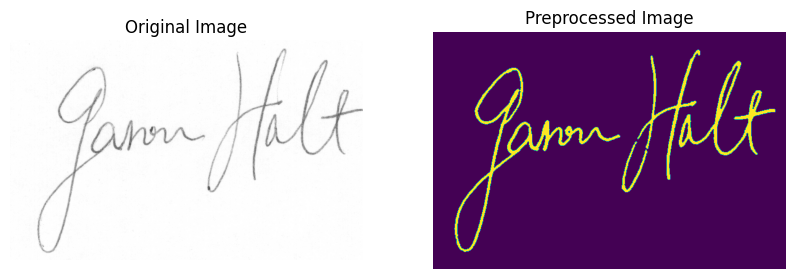

In [11]:
img = Image.open(f"{handwritten_path}/CEDAR/CEDAR/12/forgeries_12_10.png")
plot_images(img)

Preprocessed image size: (621, 405)


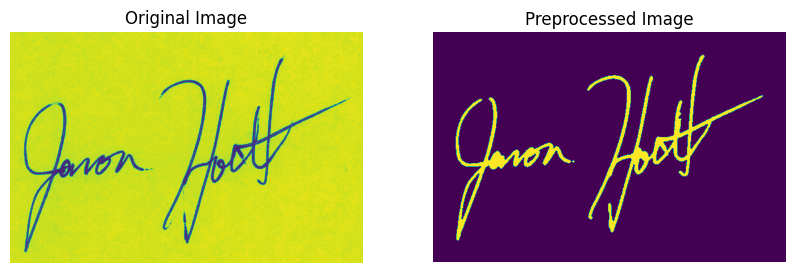

In [12]:
img = Image.open(f"{handwritten_path}/CEDAR/CEDAR/12/original_12_10.png")
plot_images(img)

In [13]:
transformation = transforms.Compose([
    transforms.Resize((200,300)),
    transforms.RandomRotation((-5,10)),
    transforms.ToTensor(),
])

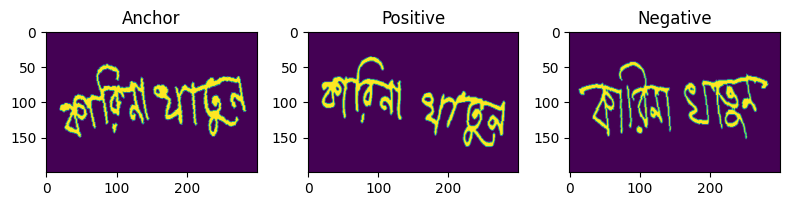

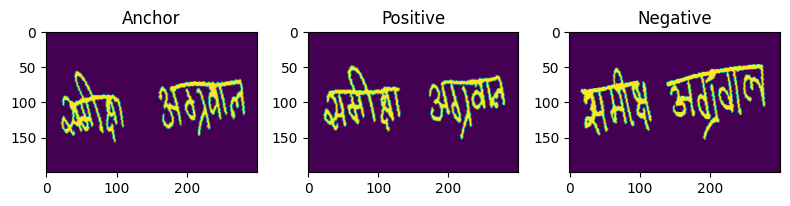

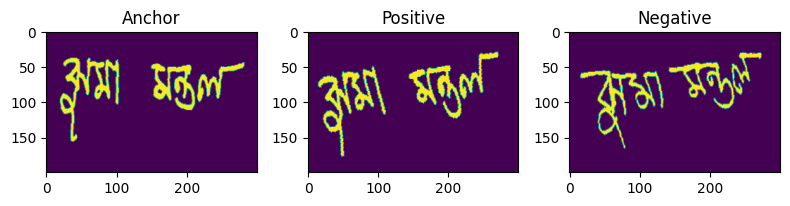

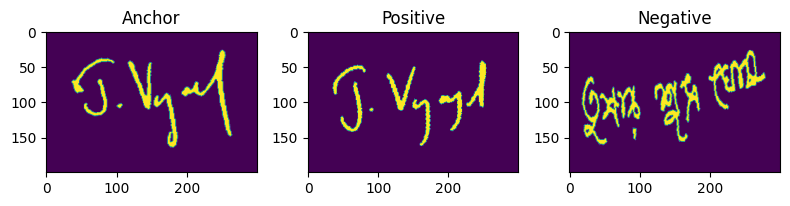

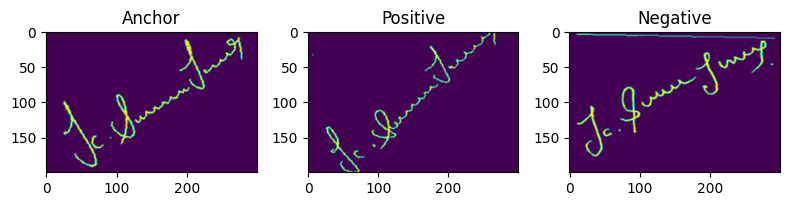

In [14]:
# Create triplet dataset
dataset =  TripletDataset(cedar_df, transform = transformation)
batch_size = 32

# Initiate data loader
loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size)
num_samples_to_show = 5

# Get random indices to select samples from the DataLoader
num_samples = len(loader.dataset)
random_indices = np.random.choice(num_samples, num_samples_to_show, replace=False)

# Create a SubsetRandomSampler using the random indices
sampler = SubsetRandomSampler(random_indices)

# Create a new DataLoader using the SubsetRandomSampler
random_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

# Show the random samples
show_triplets_from_dataloader(random_loader, num_samples_to_show)

In [15]:
len(loader)

1021

# **Siamese Neural Network With Saptial Attention**

In [16]:
margin = 0.1

# Create an instance of SiameseResnet with the ResNet model and embedding size
siamese_model = SiameseResNet()
siamese_model = nn.DataParallel(siamese_model).to(device)

triplet_loss = TripletLoss(margin).to(device)
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)

In [17]:
model = SiameseResNet()
model = nn.DataParallel(model).to(device)
summary(model, (1,200,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 150]           3,136
       BatchNorm2d-2         [-1, 64, 100, 150]             128
              ReLU-3         [-1, 64, 100, 150]               0
         MaxPool2d-4           [-1, 64, 50, 75]               0
            Conv2d-5           [-1, 64, 50, 75]          36,864
       BatchNorm2d-6           [-1, 64, 50, 75]             128
              ReLU-7           [-1, 64, 50, 75]               0
            Conv2d-8           [-1, 64, 50, 75]          36,864
       BatchNorm2d-9           [-1, 64, 50, 75]             128
             ReLU-10           [-1, 64, 50, 75]               0
       BasicBlock-11           [-1, 64, 50, 75]               0
           Conv2d-12           [-1, 64, 50, 75]          36,864
      BatchNorm2d-13           [-1, 64, 50, 75]             128
             ReLU-14           [-1, 64,

In [18]:
siamese_model

DataParallel(
  (module): SiameseResNet(
    (baseModel): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

# **Training**

In [19]:
num_epochs = 15

history = train_siamese_model(siamese_model, loader, num_epochs, optimizer, triplet_loss)

------------------------Training--------------------------
Beginning Epoch 1/15...


100%|██████████| 1021/1021 [09:40<00:00,  1.76it/s]



Epoch: 1	Train Loss: 0.0158	Duration: 0:09:40.836927
Beginning Epoch 2/15...


100%|██████████| 1021/1021 [09:37<00:00,  1.77it/s]



Epoch: 2	Train Loss: 0.0055	Duration: 0:09:37.050786
Beginning Epoch 3/15...


100%|██████████| 1021/1021 [09:35<00:00,  1.77it/s]



Epoch: 3	Train Loss: 0.0029	Duration: 0:09:35.758015
Beginning Epoch 4/15...


100%|██████████| 1021/1021 [09:36<00:00,  1.77it/s]



Epoch: 4	Train Loss: 0.0013	Duration: 0:09:36.399342
Beginning Epoch 5/15...


100%|██████████| 1021/1021 [09:36<00:00,  1.77it/s]



Epoch: 5	Train Loss: 0.0008	Duration: 0:09:36.622141
Beginning Epoch 6/15...


100%|██████████| 1021/1021 [09:35<00:00,  1.77it/s]



Epoch: 6	Train Loss: 0.0008	Duration: 0:09:35.712361
Beginning Epoch 7/15...


100%|██████████| 1021/1021 [09:36<00:00,  1.77it/s]



Epoch: 7	Train Loss: 0.0011	Duration: 0:09:36.455623
Beginning Epoch 8/15...


100%|██████████| 1021/1021 [09:36<00:00,  1.77it/s]



Epoch: 8	Train Loss: 0.0005	Duration: 0:09:36.805767
Beginning Epoch 9/15...


100%|██████████| 1021/1021 [09:35<00:00,  1.78it/s]



Epoch: 9	Train Loss: 0.0006	Duration: 0:09:35.027441
Beginning Epoch 10/15...


100%|██████████| 1021/1021 [09:33<00:00,  1.78it/s]



Epoch: 10	Train Loss: 0.0001	Duration: 0:09:33.693681
Beginning Epoch 11/15...


100%|██████████| 1021/1021 [09:37<00:00,  1.77it/s]



Epoch: 11	Train Loss: 0.0001	Duration: 0:09:37.600901
Beginning Epoch 12/15...


100%|██████████| 1021/1021 [09:34<00:00,  1.78it/s]



Epoch: 12	Train Loss: 0.0003	Duration: 0:09:34.597659
Beginning Epoch 13/15...


100%|██████████| 1021/1021 [09:31<00:00,  1.79it/s]



Epoch: 13	Train Loss: 0.0002	Duration: 0:09:31.582497
Beginning Epoch 14/15...


100%|██████████| 1021/1021 [09:36<00:00,  1.77it/s]



Epoch: 14	Train Loss: 0.0002	Duration: 0:09:36.873610
Beginning Epoch 15/15...


100%|██████████| 1021/1021 [09:41<00:00,  1.76it/s]


Epoch: 15	Train Loss: 0.0001	Duration: 0:09:41.340824


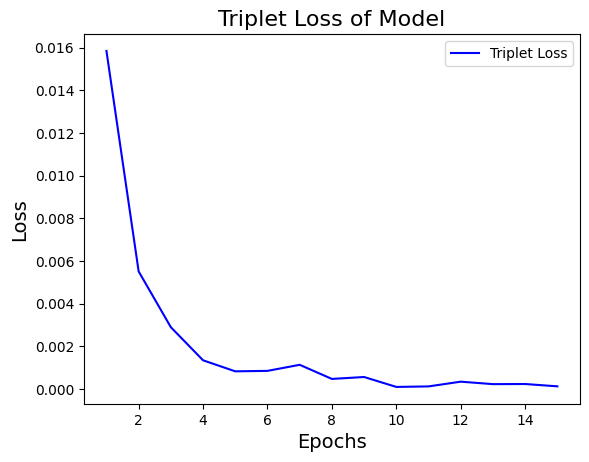

In [20]:
plt.plot(range(1, 16), history['train_loss'], 'b', label='Triplet Loss')
plt.title('Triplet Loss of Model', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

In [21]:
torch.save(siamese_model.state_dict(),'resnet_with_attention_triplet.pth')

In [22]:
cedar_dataset = f'{forgery_path}/Train'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)
cedar_duplet.shape

image size:  6182
file size:  48
-------------duplet dataset preparation-----------------


(65316, 3)

In [23]:
# cedar_duplet = cedar_duplet.sample(10000, random_state=42)
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)
indices = list(range(len(cedar_dataset)))
split = int(np.floor(0.80 * len(cedar_dataset)))  # train_size
validation = int(np.floor(0.70 * split))   # validation
np.random.shuffle(indices)

train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=batch_size, sampler=validation_sampler
)
model_rms = LogisticSiameseRegression(siamese_model).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model_rms.parameters(), lr=0.001)

history = train_model(model_rms, train_loader, test_loader, 10, optimizer, loss_fn)

------------------------Training--------------------------
Beginning Epoch 1/10...


1143it [07:34,  2.52it/s]
409it [02:11,  3.10it/s]



Epoch: 1		Train Loss: 0.3685	Train Accuracy: 0.8391
Duration: 0:09:45.943516	Valid Loss: 0.2563	Valid Accuracy: 0.9004

Beginning Epoch 2/10...


1143it [07:32,  2.53it/s]
409it [02:11,  3.11it/s]



Epoch: 2		Train Loss: 0.1702	Train Accuracy: 0.9377
Duration: 0:09:43.660340	Valid Loss: 0.1789	Valid Accuracy: 0.9342

Beginning Epoch 3/10...


1143it [07:33,  2.52it/s]
409it [02:11,  3.10it/s]



Epoch: 3		Train Loss: 0.0878	Train Accuracy: 0.9707
Duration: 0:09:45.437347	Valid Loss: 0.0972	Valid Accuracy: 0.9659

Beginning Epoch 4/10...


1143it [07:33,  2.52it/s]
409it [02:11,  3.11it/s]



Epoch: 4		Train Loss: 0.0601	Train Accuracy: 0.9798
Duration: 0:09:44.525529	Valid Loss: 0.0874	Valid Accuracy: 0.9692

Beginning Epoch 5/10...


1143it [07:32,  2.53it/s]
409it [02:12,  3.09it/s]



Epoch: 5		Train Loss: 0.0414	Train Accuracy: 0.9865
Duration: 0:09:45.127935	Valid Loss: 0.0672	Valid Accuracy: 0.9767

Beginning Epoch 6/10...


1143it [07:33,  2.52it/s]
409it [02:12,  3.10it/s]



Epoch: 6		Train Loss: 0.0361	Train Accuracy: 0.9883
Duration: 0:09:45.246188	Valid Loss: 0.0501	Valid Accuracy: 0.9842

Beginning Epoch 7/10...


1143it [07:31,  2.53it/s]
409it [02:12,  3.10it/s]



Epoch: 7		Train Loss: 0.0243	Train Accuracy: 0.9922
Duration: 0:09:43.939012	Valid Loss: 0.0513	Valid Accuracy: 0.9835

Beginning Epoch 8/10...


1143it [07:32,  2.52it/s]
409it [02:11,  3.10it/s]



Epoch: 8		Train Loss: 0.0230	Train Accuracy: 0.9923
Duration: 0:09:44.639228	Valid Loss: 0.0499	Valid Accuracy: 0.9831

Beginning Epoch 9/10...


1143it [07:32,  2.53it/s]
409it [02:12,  3.09it/s]



Epoch: 9		Train Loss: 0.0214	Train Accuracy: 0.9935
Duration: 0:09:44.916187	Valid Loss: 0.0432	Valid Accuracy: 0.9853

Beginning Epoch 10/10...


1143it [07:32,  2.53it/s]
409it [02:11,  3.10it/s]


Epoch: 10		Train Loss: 0.0177	Train Accuracy: 0.9944
Duration: 0:09:43.935385	Valid Loss: 0.0380	Valid Accuracy: 0.9888



In [24]:
torch.save(model_rms.state_dict(),'model_final_attention.pth')

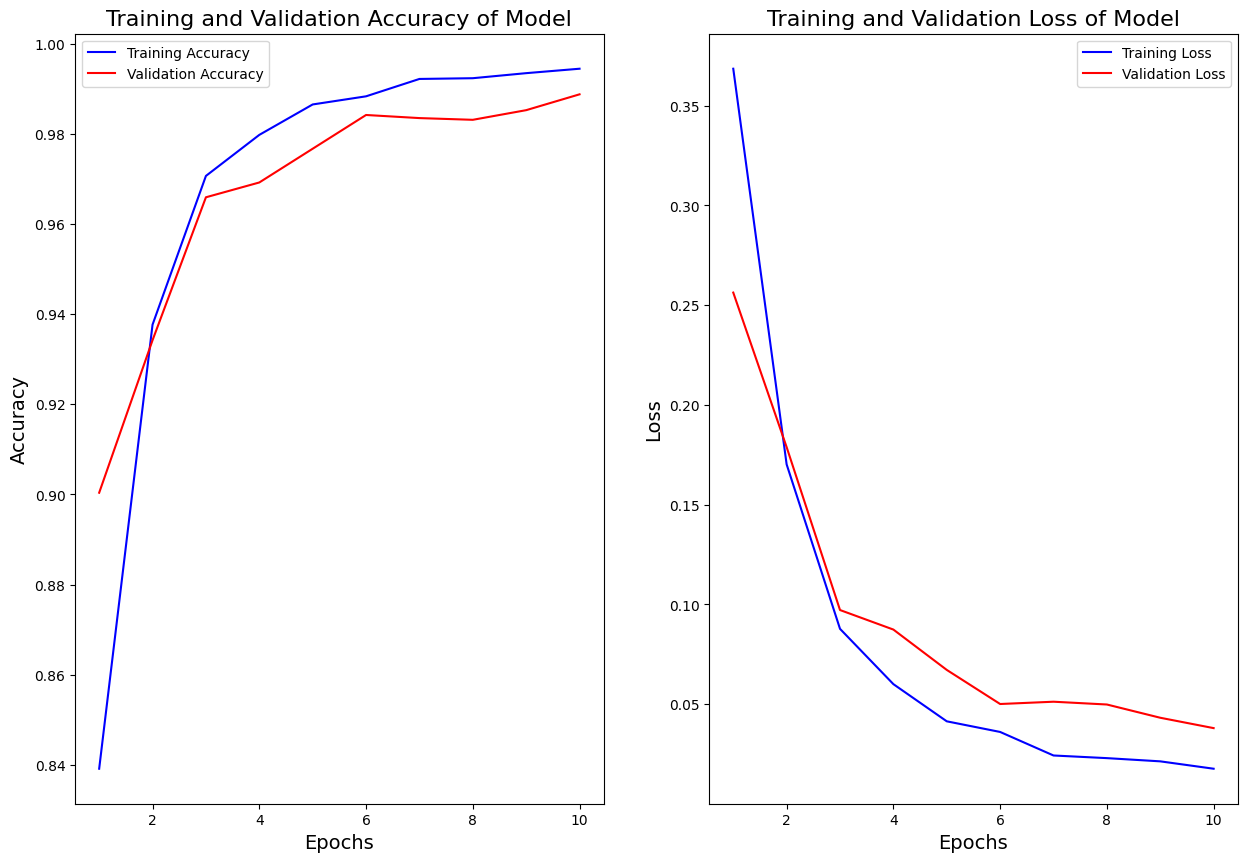

In [25]:
plot_acc_loss(history, 10)

490it [02:35,  3.15it/s]


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      7797
         1.0       0.99      0.98      0.99      7879

    accuracy                           0.99     15676
   macro avg       0.99      0.99      0.99     15676
weighted avg       0.99      0.99      0.99     15676



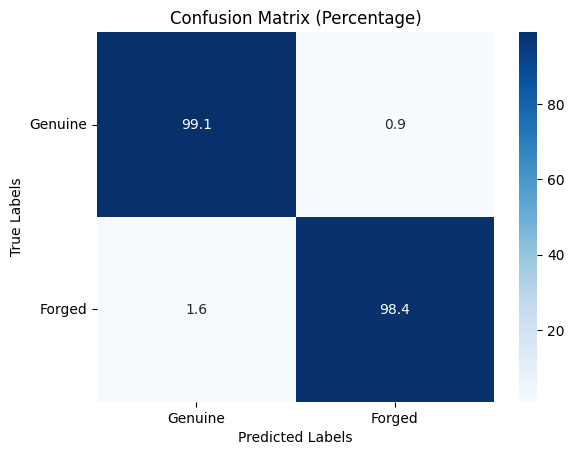

In [26]:
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

image size:  2640
file size:  48
-------------duplet dataset preparation-----------------
cedar_duplet size: 30360
cedar_dataset size: 30360


949it [05:42,  2.77it/s]


              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     15771
         1.0       0.92      0.95      0.93     14589

    accuracy                           0.94     30360
   macro avg       0.94      0.94      0.94     30360
weighted avg       0.94      0.94      0.94     30360



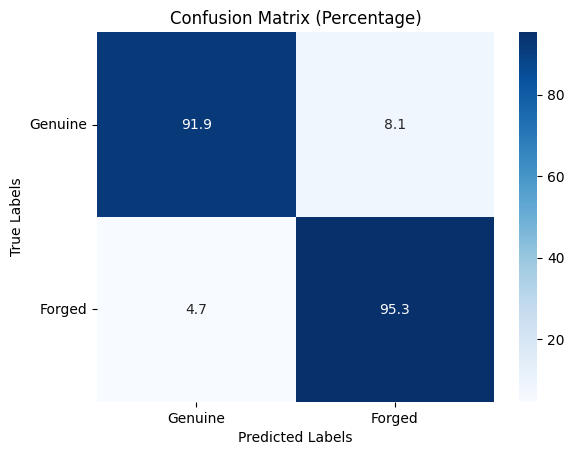

In [27]:
cedar_dataset = f'{handwritten_path}/CEDAR/CEDAR'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)
print(f"cedar_duplet size: {len(cedar_duplet)}")
# cedar_duplet = cedar_duplet.sample(10000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)
print(f"cedar_dataset size: {len(cedar_dataset)}")
validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

image size:  1688
file size:  8
-------------duplet dataset preparation-----------------
cedar_duplet size: 17204
cedar_dataset size: 17204


538it [02:52,  3.12it/s]


              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80      9358
         1.0       0.75      0.82      0.78      7846

    accuracy                           0.79     17204
   macro avg       0.79      0.79      0.79     17204
weighted avg       0.80      0.79      0.79     17204



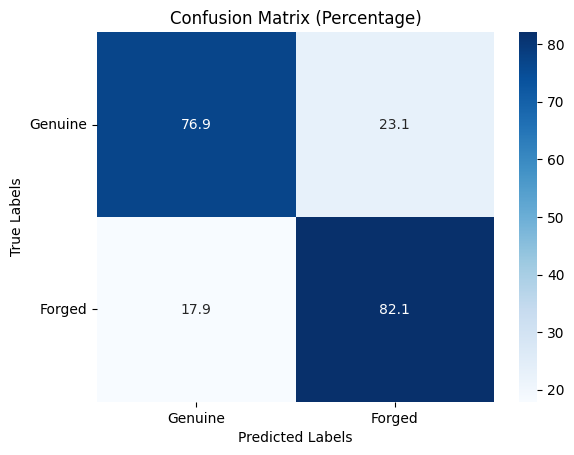

In [28]:
cedar_dataset = f'{forgery_path}/Test'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

print(f"cedar_duplet size: {len(cedar_duplet)}")

# cedar_duplet = cedar_duplet.sample(10000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)
print(f"cedar_dataset size: {len(cedar_dataset)}")

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

image size:  8640
file size:  54
-------------duplet dataset preparation-----------------


375it [01:52,  3.34it/s]


              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      6810
         1.0       0.74      0.86      0.80      5190

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.82      0.81      0.81     12000



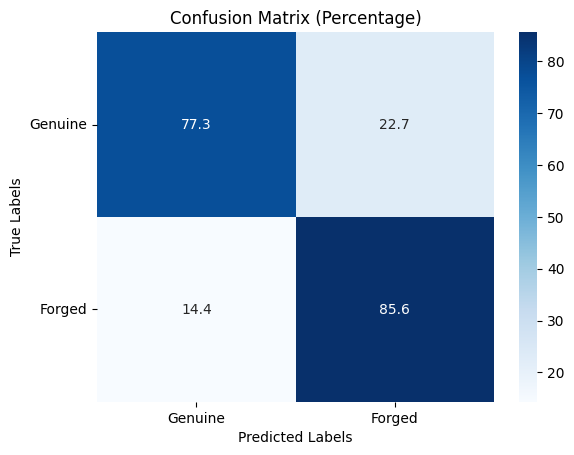

In [29]:
cedar_dataset = f'{handwritten_path}/BHSig260-Hindi/BHSig260-Hindi'
cedar_duplet = duplet_dataset_preparation(cedar_dataset)

cedar_duplet = cedar_duplet.sample(12000, random_state=42)

transformation = transforms.Compose([
    transforms.Resize((200,300)),
#     transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
cedar_dataset = DupletDataset(cedar_duplet, transform=transformation)

validation_loader = torch.utils.data.DataLoader(
    cedar_dataset, batch_size=32
)
preds, labels = get_predictions(validation_loader, model_rms)
print(classification_report(preds, labels))
build_confusion_matrix(preds, labels)

# **Testing**

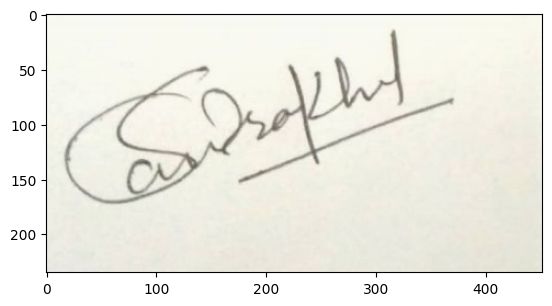

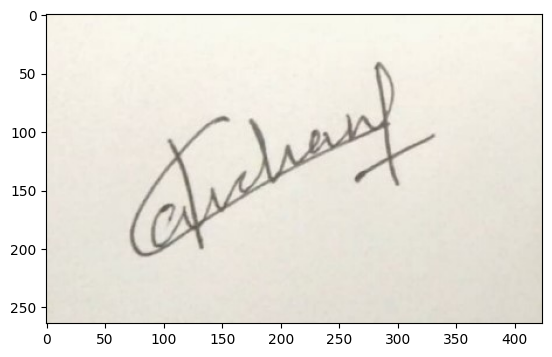

Model prediction: 0.5165135264396667
The signatures are likely not similar.


In [30]:
img1 = f"{forgery_path}/Test/2/original_02_03.jpg"
img2 = f"{forgery_path}/Test/3/original_03_03.jpg"
get_predictions_for_single(img1, img2, model_rms)

## Calculating Predictions Using Voting¶
1. First Creating a test dataset

In [32]:
folder = f'{handwritten_path}/CEDAR/CEDAR'
preds,labels = perform_voting_for_each_test_images(folder, handwritten_path)

5it [00:01,  3.22it/s]


30	/CEDAR/CEDAR/30/forgeries_30_11.png	1	1


5it [00:01,  3.56it/s]


30	/CEDAR/CEDAR/30/original_30_17.png	0	0


5it [00:01,  3.38it/s]


30	/CEDAR/CEDAR/30/original_30_2.png	0	0


5it [00:02,  2.25it/s]


30	/CEDAR/CEDAR/30/forgeries_30_21.png	1	1


5it [00:01,  3.28it/s]


30	/CEDAR/CEDAR/30/original_30_19.png	0	0


5it [00:02,  2.09it/s]


8	/CEDAR/CEDAR/8/forgeries_8_1.png	1	0


5it [00:01,  2.58it/s]


8	/CEDAR/CEDAR/8/original_8_16.png	0	1


5it [00:01,  2.68it/s]


8	/CEDAR/CEDAR/8/original_8_24.png	0	0


5it [00:01,  2.64it/s]


8	/CEDAR/CEDAR/8/original_8_9.png	0	0


5it [00:02,  2.44it/s]


8	/CEDAR/CEDAR/8/forgeries_8_3.png	1	0


5it [00:01,  3.46it/s]


42	/CEDAR/CEDAR/42/forgeries_42_22.png	1	1


5it [00:01,  3.42it/s]


42	/CEDAR/CEDAR/42/forgeries_42_3.png	1	1


5it [00:01,  2.93it/s]


42	/CEDAR/CEDAR/42/forgeries_42_23.png	1	1


5it [00:01,  3.71it/s]


42	/CEDAR/CEDAR/42/original_42_5.png	0	0


5it [00:01,  3.73it/s]


42	/CEDAR/CEDAR/42/original_42_20.png	0	1


5it [00:00,  5.90it/s]


19	/CEDAR/CEDAR/19/original_19_3.png	0	0


5it [00:00,  5.67it/s]


19	/CEDAR/CEDAR/19/original_19_14.png	0	1


5it [00:00,  5.61it/s]


19	/CEDAR/CEDAR/19/original_19_6.png	0	0


5it [00:00,  5.98it/s]


19	/CEDAR/CEDAR/19/original_19_4.png	0	0


5it [00:00,  5.81it/s]


19	/CEDAR/CEDAR/19/original_19_13.png	0	0


5it [00:01,  3.40it/s]


39	/CEDAR/CEDAR/39/forgeries_39_3.png	1	1


5it [00:01,  4.07it/s]


39	/CEDAR/CEDAR/39/original_39_8.png	0	0


5it [00:01,  4.21it/s]


39	/CEDAR/CEDAR/39/forgeries_39_8.png	1	1


5it [00:01,  4.20it/s]


39	/CEDAR/CEDAR/39/forgeries_39_10.png	1	1


5it [00:01,  4.00it/s]


39	/CEDAR/CEDAR/39/original_39_17.png	0	0


5it [00:02,  2.21it/s]


31	/CEDAR/CEDAR/31/forgeries_31_24.png	1	1


5it [00:02,  2.19it/s]


31	/CEDAR/CEDAR/31/forgeries_31_19.png	1	0


5it [00:02,  2.02it/s]


31	/CEDAR/CEDAR/31/forgeries_31_3.png	1	1


5it [00:02,  1.78it/s]


31	/CEDAR/CEDAR/31/original_31_8.png	0	0


5it [00:02,  2.14it/s]


31	/CEDAR/CEDAR/31/forgeries_31_17.png	1	1


5it [00:00,  8.38it/s]


25	/CEDAR/CEDAR/25/original_25_12.png	0	0


5it [00:00,  7.32it/s]


25	/CEDAR/CEDAR/25/forgeries_25_5.png	1	1


5it [00:00,  7.65it/s]


25	/CEDAR/CEDAR/25/forgeries_25_7.png	1	1


5it [00:00,  9.18it/s]


25	/CEDAR/CEDAR/25/original_25_2.png	0	0


5it [00:00,  6.30it/s]


25	/CEDAR/CEDAR/25/forgeries_25_1.png	1	1


5it [00:01,  2.60it/s]


49	/CEDAR/CEDAR/49/forgeries_49_21.png	1	1


5it [00:02,  2.28it/s]


49	/CEDAR/CEDAR/49/original_49_23.png	0	0


5it [00:01,  2.60it/s]


49	/CEDAR/CEDAR/49/forgeries_49_19.png	1	1


5it [00:02,  2.49it/s]


49	/CEDAR/CEDAR/49/forgeries_49_3.png	1	1


5it [00:02,  2.42it/s]


49	/CEDAR/CEDAR/49/original_49_13.png	0	0


5it [00:03,  1.44it/s]


7	/CEDAR/CEDAR/7/forgeries_7_14.png	1	0


5it [00:03,  1.41it/s]


7	/CEDAR/CEDAR/7/original_7_11.png	0	0


5it [00:03,  1.50it/s]


7	/CEDAR/CEDAR/7/forgeries_7_1.png	1	0


5it [00:04,  1.20it/s]


7	/CEDAR/CEDAR/7/forgeries_7_9.png	1	1


5it [00:03,  1.49it/s]


7	/CEDAR/CEDAR/7/forgeries_7_22.png	1	1


5it [00:01,  4.24it/s]


55	/CEDAR/CEDAR/55/original_55_22.png	0	0


5it [00:01,  4.56it/s]


55	/CEDAR/CEDAR/55/original_55_3.png	0	0


5it [00:01,  4.21it/s]


55	/CEDAR/CEDAR/55/original_55_18.png	0	0


5it [00:01,  4.22it/s]


55	/CEDAR/CEDAR/55/original_55_14.png	0	1


5it [00:01,  3.82it/s]


55	/CEDAR/CEDAR/55/forgeries_55_18.png	1	1


5it [00:02,  2.33it/s]


14	/CEDAR/CEDAR/14/original_14_2.png	0	0


5it [00:02,  2.16it/s]


14	/CEDAR/CEDAR/14/original_14_15.png	0	0


5it [00:02,  1.85it/s]


14	/CEDAR/CEDAR/14/forgeries_14_12.png	1	1


5it [00:02,  2.06it/s]


14	/CEDAR/CEDAR/14/forgeries_14_18.png	1	1


5it [00:02,  2.03it/s]


14	/CEDAR/CEDAR/14/original_14_24.png	0	0


5it [00:01,  2.97it/s]


9	/CEDAR/CEDAR/9/forgeries_9_16.png	1	1


5it [00:01,  3.08it/s]


9	/CEDAR/CEDAR/9/original_9_7.png	0	0


5it [00:01,  3.20it/s]


9	/CEDAR/CEDAR/9/original_9_13.png	0	0


5it [00:01,  3.08it/s]


9	/CEDAR/CEDAR/9/original_9_20.png	0	0


5it [00:01,  3.12it/s]


9	/CEDAR/CEDAR/9/original_9_16.png	0	0


5it [00:01,  3.12it/s]


3	/CEDAR/CEDAR/3/original_3_1.png	0	1


5it [00:01,  2.92it/s]


3	/CEDAR/CEDAR/3/original_3_11.png	0	0


5it [00:01,  3.15it/s]


3	/CEDAR/CEDAR/3/original_3_5.png	0	0


5it [00:01,  3.03it/s]


3	/CEDAR/CEDAR/3/forgeries_3_9.png	1	0


5it [00:01,  3.06it/s]


3	/CEDAR/CEDAR/3/forgeries_3_6.png	1	0


5it [00:00,  5.15it/s]


33	/CEDAR/CEDAR/33/original_33_18.png	0	0


5it [00:00,  5.81it/s]


33	/CEDAR/CEDAR/33/original_33_22.png	0	0


5it [00:01,  3.85it/s]


33	/CEDAR/CEDAR/33/forgeries_33_9.png	1	1


5it [00:00,  5.69it/s]


33	/CEDAR/CEDAR/33/original_33_6.png	0	0


5it [00:01,  4.85it/s]


33	/CEDAR/CEDAR/33/forgeries_33_16.png	1	1


5it [00:01,  3.08it/s]


37	/CEDAR/CEDAR/37/original_37_2.png	0	0


5it [00:01,  3.12it/s]


37	/CEDAR/CEDAR/37/forgeries_37_13.png	1	1


5it [00:01,  3.12it/s]


37	/CEDAR/CEDAR/37/forgeries_37_14.png	1	1


5it [00:01,  2.86it/s]


37	/CEDAR/CEDAR/37/original_37_16.png	0	0


5it [00:01,  2.91it/s]


37	/CEDAR/CEDAR/37/forgeries_37_15.png	1	1


5it [00:02,  2.44it/s]


50	/CEDAR/CEDAR/50/forgeries_50_6.png	1	1


5it [00:01,  2.51it/s]


50	/CEDAR/CEDAR/50/original_50_17.png	0	0


5it [00:01,  2.63it/s]


50	/CEDAR/CEDAR/50/original_50_13.png	0	0


5it [00:02,  2.34it/s]


50	/CEDAR/CEDAR/50/forgeries_50_18.png	1	1


5it [00:01,  2.70it/s]


50	/CEDAR/CEDAR/50/forgeries_50_8.png	1	1


5it [00:01,  2.55it/s]


46	/CEDAR/CEDAR/46/forgeries_46_10.png	1	1


5it [00:02,  2.33it/s]


46	/CEDAR/CEDAR/46/forgeries_46_22.png	1	1


5it [00:02,  2.10it/s]


46	/CEDAR/CEDAR/46/forgeries_46_12.png	1	1


5it [00:02,  2.25it/s]


46	/CEDAR/CEDAR/46/original_46_24.png	0	0


5it [00:02,  2.12it/s]


46	/CEDAR/CEDAR/46/forgeries_46_6.png	1	1


5it [00:01,  4.43it/s]


24	/CEDAR/CEDAR/24/forgeries_24_15.png	1	1


5it [00:00,  6.06it/s]


24	/CEDAR/CEDAR/24/original_24_7.png	0	0


5it [00:01,  4.99it/s]


24	/CEDAR/CEDAR/24/forgeries_24_4.png	1	1


5it [00:01,  4.55it/s]


24	/CEDAR/CEDAR/24/forgeries_24_17.png	1	1


5it [00:00,  5.38it/s]


24	/CEDAR/CEDAR/24/forgeries_24_13.png	1	1


5it [00:01,  3.52it/s]


38	/CEDAR/CEDAR/38/forgeries_38_4.png	1	1


5it [00:01,  3.67it/s]


38	/CEDAR/CEDAR/38/original_38_20.png	0	0


5it [00:01,  3.64it/s]


38	/CEDAR/CEDAR/38/original_38_24.png	0	0


5it [00:01,  3.93it/s]


38	/CEDAR/CEDAR/38/original_38_21.png	0	0


5it [00:01,  3.85it/s]


38	/CEDAR/CEDAR/38/original_38_1.png	0	0


5it [00:01,  3.03it/s]


5	/CEDAR/CEDAR/5/forgeries_5_5.png	1	0


5it [00:01,  2.60it/s]


5	/CEDAR/CEDAR/5/original_5_17.png	0	0


5it [00:01,  2.78it/s]


5	/CEDAR/CEDAR/5/forgeries_5_17.png	1	1


5it [00:01,  2.95it/s]


5	/CEDAR/CEDAR/5/original_5_4.png	0	0


5it [00:01,  2.58it/s]


5	/CEDAR/CEDAR/5/forgeries_5_1.png	1	1


5it [00:00,  5.67it/s]


21	/CEDAR/CEDAR/21/forgeries_21_22.png	1	1


5it [00:00,  6.56it/s]


21	/CEDAR/CEDAR/21/original_21_1.png	0	1


5it [00:00,  6.10it/s]


21	/CEDAR/CEDAR/21/forgeries_21_9.png	1	1


5it [00:01,  4.01it/s]


21	/CEDAR/CEDAR/21/forgeries_21_17.png	1	1


5it [00:00,  5.39it/s]


21	/CEDAR/CEDAR/21/forgeries_21_7.png	1	1


5it [00:01,  3.00it/s]


17	/CEDAR/CEDAR/17/original_17_4.png	0	0


5it [00:01,  2.85it/s]


17	/CEDAR/CEDAR/17/original_17_24.png	0	0


5it [00:02,  2.39it/s]


17	/CEDAR/CEDAR/17/forgeries_17_10.png	1	1


5it [00:01,  2.71it/s]


17	/CEDAR/CEDAR/17/forgeries_17_4.png	1	1


5it [00:01,  3.11it/s]


17	/CEDAR/CEDAR/17/original_17_10.png	0	0


5it [00:02,  1.95it/s]


12	/CEDAR/CEDAR/12/original_12_24.png	0	0


5it [00:02,  2.04it/s]


12	/CEDAR/CEDAR/12/forgeries_12_4.png	1	1


5it [00:02,  1.96it/s]


12	/CEDAR/CEDAR/12/original_12_17.png	0	0


5it [00:02,  1.92it/s]


12	/CEDAR/CEDAR/12/original_12_6.png	0	0


5it [00:02,  1.95it/s]


12	/CEDAR/CEDAR/12/forgeries_12_23.png	1	1


5it [00:01,  2.90it/s]


45	/CEDAR/CEDAR/45/original_45_17.png	0	0


5it [00:01,  2.82it/s]


45	/CEDAR/CEDAR/45/forgeries_45_24.png	1	1


5it [00:01,  2.61it/s]


45	/CEDAR/CEDAR/45/original_45_23.png	0	0


5it [00:01,  2.92it/s]


45	/CEDAR/CEDAR/45/forgeries_45_19.png	1	1


5it [00:01,  3.20it/s]


45	/CEDAR/CEDAR/45/original_45_1.png	0	0


5it [00:00,  6.29it/s]


44	/CEDAR/CEDAR/44/original_44_1.png	0	0


5it [00:00,  5.90it/s]


44	/CEDAR/CEDAR/44/forgeries_44_6.png	1	1


5it [00:00,  6.46it/s]


44	/CEDAR/CEDAR/44/forgeries_44_8.png	1	1


5it [00:00,  5.96it/s]


44	/CEDAR/CEDAR/44/forgeries_44_15.png	1	1


5it [00:00,  7.41it/s]


44	/CEDAR/CEDAR/44/original_44_24.png	0	0


5it [00:01,  2.65it/s]


47	/CEDAR/CEDAR/47/forgeries_47_7.png	1	1


5it [00:02,  2.38it/s]


47	/CEDAR/CEDAR/47/original_47_3.png	0	0


5it [00:02,  1.97it/s]


47	/CEDAR/CEDAR/47/forgeries_47_16.png	1	1


5it [00:02,  2.07it/s]


47	/CEDAR/CEDAR/47/forgeries_47_17.png	1	1


5it [00:02,  2.33it/s]


47	/CEDAR/CEDAR/47/original_47_11.png	0	0


5it [00:01,  4.16it/s]


53	/CEDAR/CEDAR/53/original_53_12.png	0	0


5it [00:01,  4.02it/s]


53	/CEDAR/CEDAR/53/original_53_18.png	0	0


5it [00:01,  4.31it/s]


53	/CEDAR/CEDAR/53/original_53_10.png	0	0


5it [00:01,  4.30it/s]


53	/CEDAR/CEDAR/53/forgeries_53_12.png	1	1


5it [00:01,  3.81it/s]


53	/CEDAR/CEDAR/53/forgeries_53_15.png	1	1


5it [00:00,  5.86it/s]


22	/CEDAR/CEDAR/22/forgeries_22_9.png	1	1


5it [00:00,  6.94it/s]


22	/CEDAR/CEDAR/22/original_22_14.png	0	0


5it [00:00,  6.67it/s]


22	/CEDAR/CEDAR/22/original_22_1.png	0	1


5it [00:00,  7.58it/s]


22	/CEDAR/CEDAR/22/original_22_20.png	0	0


5it [00:00,  6.81it/s]


22	/CEDAR/CEDAR/22/original_22_12.png	0	0


5it [00:01,  3.71it/s]


40	/CEDAR/CEDAR/40/original_40_10.png	0	0


5it [00:01,  3.34it/s]


40	/CEDAR/CEDAR/40/original_40_9.png	0	0


5it [00:01,  3.43it/s]


40	/CEDAR/CEDAR/40/original_40_12.png	0	0


5it [00:01,  4.27it/s]


40	/CEDAR/CEDAR/40/forgeries_40_2.png	1	1


5it [00:01,  3.74it/s]


40	/CEDAR/CEDAR/40/original_40_23.png	0	0


5it [00:00,  6.30it/s]


28	/CEDAR/CEDAR/28/original_28_3.png	0	0


5it [00:00,  5.98it/s]


28	/CEDAR/CEDAR/28/original_28_21.png	0	0


5it [00:01,  4.36it/s]


28	/CEDAR/CEDAR/28/forgeries_28_22.png	1	1


5it [00:00,  5.86it/s]


28	/CEDAR/CEDAR/28/forgeries_28_19.png	1	1


5it [00:00,  5.68it/s]


28	/CEDAR/CEDAR/28/original_28_10.png	0	0


5it [00:01,  3.57it/s]


6	/CEDAR/CEDAR/6/original_6_18.png	0	0


5it [00:01,  3.38it/s]


6	/CEDAR/CEDAR/6/original_6_3.png	0	0


5it [00:01,  3.86it/s]


6	/CEDAR/CEDAR/6/forgeries_6_15.png	1	1


5it [00:01,  3.79it/s]


6	/CEDAR/CEDAR/6/forgeries_6_17.png	1	0


5it [00:01,  3.23it/s]


6	/CEDAR/CEDAR/6/original_6_16.png	0	0


5it [00:02,  2.19it/s]


34	/CEDAR/CEDAR/34/forgeries_34_13.png	1	1


5it [00:02,  1.76it/s]


34	/CEDAR/CEDAR/34/forgeries_34_18.png	1	1


5it [00:02,  2.18it/s]


34	/CEDAR/CEDAR/34/original_34_6.png	0	0


5it [00:02,  2.23it/s]


34	/CEDAR/CEDAR/34/forgeries_34_11.png	1	1


5it [00:02,  2.13it/s]


34	/CEDAR/CEDAR/34/original_34_19.png	0	0


5it [00:02,  2.45it/s]


48	/CEDAR/CEDAR/48/forgeries_48_23.png	1	1


5it [00:02,  2.32it/s]


48	/CEDAR/CEDAR/48/original_48_21.png	0	0


5it [00:02,  2.36it/s]


48	/CEDAR/CEDAR/48/forgeries_48_7.png	1	1


5it [00:02,  2.25it/s]


48	/CEDAR/CEDAR/48/forgeries_48_13.png	1	1


5it [00:02,  2.22it/s]


48	/CEDAR/CEDAR/48/original_48_18.png	0	0


5it [00:00,  6.85it/s]


20	/CEDAR/CEDAR/20/original_20_17.png	0	0


5it [00:00,  5.91it/s]


20	/CEDAR/CEDAR/20/forgeries_20_9.png	1	1


5it [00:00,  6.67it/s]


20	/CEDAR/CEDAR/20/original_20_21.png	0	0


5it [00:00,  7.10it/s]


20	/CEDAR/CEDAR/20/original_20_4.png	0	0


5it [00:00,  6.77it/s]


20	/CEDAR/CEDAR/20/original_20_12.png	0	0


5it [00:01,  3.41it/s]


23	/CEDAR/CEDAR/23/forgeries_23_14.png	1	1


5it [00:01,  4.00it/s]


23	/CEDAR/CEDAR/23/original_23_2.png	0	0


5it [00:01,  3.49it/s]


23	/CEDAR/CEDAR/23/forgeries_23_4.png	1	1


5it [00:01,  3.78it/s]


23	/CEDAR/CEDAR/23/forgeries_23_5.png	1	1


5it [00:01,  3.44it/s]


23	/CEDAR/CEDAR/23/forgeries_23_2.png	1	0


5it [00:01,  4.71it/s]


27	/CEDAR/CEDAR/27/original_27_19.png	0	1


5it [00:01,  4.42it/s]


27	/CEDAR/CEDAR/27/original_27_14.png	0	0


5it [00:01,  3.15it/s]


27	/CEDAR/CEDAR/27/forgeries_27_15.png	1	1


5it [00:01,  4.65it/s]


27	/CEDAR/CEDAR/27/original_27_18.png	0	0


5it [00:01,  3.64it/s]


27	/CEDAR/CEDAR/27/forgeries_27_16.png	1	1


5it [00:01,  3.83it/s]


32	/CEDAR/CEDAR/32/forgeries_32_19.png	1	1


5it [00:01,  4.15it/s]


32	/CEDAR/CEDAR/32/forgeries_32_14.png	1	1


5it [00:01,  4.06it/s]


32	/CEDAR/CEDAR/32/original_32_10.png	0	1


5it [00:01,  3.15it/s]


32	/CEDAR/CEDAR/32/forgeries_32_6.png	1	1


5it [00:01,  4.21it/s]


32	/CEDAR/CEDAR/32/original_32_8.png	0	0


5it [00:00,  5.04it/s]


52	/CEDAR/CEDAR/52/forgeries_52_14.png	1	1


5it [00:00,  5.74it/s]


52	/CEDAR/CEDAR/52/original_52_9.png	0	0


5it [00:00,  5.45it/s]


52	/CEDAR/CEDAR/52/forgeries_52_5.png	1	1


5it [00:00,  5.99it/s]


52	/CEDAR/CEDAR/52/original_52_1.png	0	0


5it [00:00,  5.35it/s]


52	/CEDAR/CEDAR/52/forgeries_52_8.png	1	1


5it [00:01,  4.90it/s]


16	/CEDAR/CEDAR/16/original_16_18.png	0	0


5it [00:01,  4.79it/s]


16	/CEDAR/CEDAR/16/original_16_12.png	0	0


5it [00:01,  3.65it/s]


16	/CEDAR/CEDAR/16/forgeries_16_12.png	1	1


5it [00:01,  4.15it/s]


16	/CEDAR/CEDAR/16/forgeries_16_13.png	1	1


5it [00:01,  4.46it/s]


16	/CEDAR/CEDAR/16/forgeries_16_4.png	1	1


5it [00:01,  4.22it/s]


43	/CEDAR/CEDAR/43/original_43_11.png	0	0


5it [00:01,  4.15it/s]


43	/CEDAR/CEDAR/43/original_43_10.png	0	0


5it [00:01,  4.41it/s]


43	/CEDAR/CEDAR/43/original_43_12.png	0	0


5it [00:01,  3.89it/s]


43	/CEDAR/CEDAR/43/forgeries_43_15.png	1	1


5it [00:01,  3.92it/s]


43	/CEDAR/CEDAR/43/forgeries_43_17.png	1	1


5it [00:01,  2.56it/s]


10	/CEDAR/CEDAR/10/original_10_23.png	0	0


5it [00:02,  2.41it/s]


10	/CEDAR/CEDAR/10/forgeries_10_7.png	1	1


5it [00:01,  2.62it/s]


10	/CEDAR/CEDAR/10/original_10_7.png	0	0


5it [00:01,  3.05it/s]


10	/CEDAR/CEDAR/10/original_10_12.png	0	0


5it [00:01,  2.90it/s]


10	/CEDAR/CEDAR/10/original_10_11.png	0	0


5it [00:00,  5.63it/s]


35	/CEDAR/CEDAR/35/original_35_24.png	0	0


5it [00:00,  5.77it/s]


35	/CEDAR/CEDAR/35/forgeries_35_4.png	1	1


5it [00:00,  5.45it/s]


35	/CEDAR/CEDAR/35/original_35_13.png	0	0


5it [00:00,  5.45it/s]


35	/CEDAR/CEDAR/35/original_35_2.png	0	0


5it [00:00,  5.28it/s]


35	/CEDAR/CEDAR/35/original_35_14.png	0	0


5it [00:01,  2.69it/s]


1	/CEDAR/CEDAR/1/forgeries_1_13.png	1	1


5it [00:02,  2.27it/s]


1	/CEDAR/CEDAR/1/original_1_11.png	0	1


5it [00:01,  2.91it/s]


1	/CEDAR/CEDAR/1/forgeries_1_16.png	1	1


5it [00:02,  2.42it/s]


1	/CEDAR/CEDAR/1/forgeries_1_9.png	1	1


5it [00:01,  2.77it/s]


1	/CEDAR/CEDAR/1/forgeries_1_18.png	1	0


5it [00:00,  5.35it/s]


4	/CEDAR/CEDAR/4/forgeries_4_18.png	1	1


5it [00:00,  5.25it/s]


4	/CEDAR/CEDAR/4/forgeries_4_4.png	1	1


5it [00:00,  5.89it/s]


4	/CEDAR/CEDAR/4/forgeries_4_12.png	1	1


5it [00:00,  5.68it/s]


4	/CEDAR/CEDAR/4/forgeries_4_5.png	1	1


5it [00:00,  5.74it/s]


4	/CEDAR/CEDAR/4/original_4_6.png	0	0


5it [00:01,  3.81it/s]


15	/CEDAR/CEDAR/15/forgeries_15_6.png	1	1


5it [00:01,  4.51it/s]


15	/CEDAR/CEDAR/15/original_15_3.png	0	0


5it [00:01,  3.98it/s]


15	/CEDAR/CEDAR/15/original_15_13.png	0	0


5it [00:01,  4.10it/s]


15	/CEDAR/CEDAR/15/original_15_11.png	0	0


5it [00:01,  3.80it/s]


15	/CEDAR/CEDAR/15/forgeries_15_21.png	1	1


5it [00:02,  1.88it/s]


26	/CEDAR/CEDAR/26/original_26_18.png	0	0


5it [00:02,  2.12it/s]


26	/CEDAR/CEDAR/26/forgeries_26_14.png	1	1


5it [00:02,  2.16it/s]


26	/CEDAR/CEDAR/26/forgeries_26_19.png	1	1


5it [00:02,  1.68it/s]


26	/CEDAR/CEDAR/26/original_26_2.png	0	0


5it [00:03,  1.64it/s]


26	/CEDAR/CEDAR/26/original_26_3.png	0	0


5it [00:02,  2.44it/s]


51	/CEDAR/CEDAR/51/forgeries_51_12.png	1	1


5it [00:01,  2.79it/s]


51	/CEDAR/CEDAR/51/original_51_15.png	0	0


5it [00:01,  2.89it/s]


51	/CEDAR/CEDAR/51/original_51_17.png	0	0


5it [00:01,  2.93it/s]


51	/CEDAR/CEDAR/51/original_51_4.png	0	0


5it [00:02,  2.32it/s]


51	/CEDAR/CEDAR/51/forgeries_51_24.png	1	1


5it [00:01,  3.34it/s]


11	/CEDAR/CEDAR/11/forgeries_11_19.png	1	1


5it [00:01,  3.60it/s]


11	/CEDAR/CEDAR/11/original_11_8.png	0	0


5it [00:01,  3.08it/s]


11	/CEDAR/CEDAR/11/forgeries_11_14.png	1	1


5it [00:01,  3.02it/s]


11	/CEDAR/CEDAR/11/forgeries_11_3.png	1	1


5it [00:01,  3.26it/s]


11	/CEDAR/CEDAR/11/original_11_23.png	0	0


5it [00:01,  4.02it/s]


18	/CEDAR/CEDAR/18/original_18_8.png	0	0


5it [00:01,  3.57it/s]


18	/CEDAR/CEDAR/18/forgeries_18_4.png	1	1


5it [00:01,  3.76it/s]


18	/CEDAR/CEDAR/18/original_18_12.png	0	0


5it [00:01,  4.06it/s]


18	/CEDAR/CEDAR/18/original_18_19.png	0	0


5it [00:01,  3.69it/s]


18	/CEDAR/CEDAR/18/forgeries_18_14.png	1	1


5it [00:01,  3.73it/s]


29	/CEDAR/CEDAR/29/original_29_11.png	0	0


5it [00:01,  3.50it/s]


29	/CEDAR/CEDAR/29/forgeries_29_12.png	1	1


5it [00:01,  3.24it/s]


29	/CEDAR/CEDAR/29/forgeries_29_2.png	1	1


5it [00:01,  3.78it/s]


29	/CEDAR/CEDAR/29/original_29_9.png	0	0


5it [00:01,  3.68it/s]


29	/CEDAR/CEDAR/29/forgeries_29_22.png	1	1


5it [00:00,  5.05it/s]


36	/CEDAR/CEDAR/36/original_36_10.png	0	0


5it [00:00,  5.11it/s]


36	/CEDAR/CEDAR/36/forgeries_36_16.png	1	1


5it [00:00,  5.58it/s]


36	/CEDAR/CEDAR/36/forgeries_36_8.png	1	0


5it [00:01,  4.88it/s]


36	/CEDAR/CEDAR/36/original_36_15.png	0	0


5it [00:00,  5.20it/s]


36	/CEDAR/CEDAR/36/forgeries_36_9.png	1	1


5it [00:01,  2.97it/s]


13	/CEDAR/CEDAR/13/forgeries_13_23.png	1	1


5it [00:01,  3.44it/s]


13	/CEDAR/CEDAR/13/original_13_5.png	0	0


5it [00:01,  3.10it/s]


13	/CEDAR/CEDAR/13/original_13_20.png	0	0


5it [00:01,  3.59it/s]


13	/CEDAR/CEDAR/13/original_13_12.png	0	0


5it [00:01,  3.47it/s]


13	/CEDAR/CEDAR/13/original_13_7.png	0	0


5it [00:01,  2.51it/s]


54	/CEDAR/CEDAR/54/original_54_11.png	0	0


5it [00:01,  2.83it/s]


54	/CEDAR/CEDAR/54/original_54_16.png	0	0


5it [00:01,  2.67it/s]


54	/CEDAR/CEDAR/54/forgeries_54_1.png	1	1


5it [00:01,  2.84it/s]


54	/CEDAR/CEDAR/54/original_54_10.png	0	0


5it [00:01,  2.71it/s]


54	/CEDAR/CEDAR/54/original_54_5.png	0	0


5it [00:01,  4.10it/s]


2	/CEDAR/CEDAR/2/original_2_9.png	0	0


5it [00:01,  4.36it/s]


2	/CEDAR/CEDAR/2/original_2_24.png	0	0


5it [00:01,  4.22it/s]


2	/CEDAR/CEDAR/2/original_2_21.png	0	1


5it [00:01,  3.58it/s]


2	/CEDAR/CEDAR/2/forgeries_2_14.png	1	1


5it [00:01,  4.29it/s]


2	/CEDAR/CEDAR/2/forgeries_2_8.png	1	1


5it [00:01,  3.10it/s]


41	/CEDAR/CEDAR/41/forgeries_41_5.png	1	1


5it [00:01,  2.71it/s]


41	/CEDAR/CEDAR/41/original_41_24.png	0	0


5it [00:01,  2.97it/s]


41	/CEDAR/CEDAR/41/original_41_11.png	0	0


5it [00:01,  3.09it/s]


41	/CEDAR/CEDAR/41/forgeries_41_4.png	1	1


5it [00:01,  3.37it/s]

41	/CEDAR/CEDAR/41/forgeries_41_24.png	1	1


In [33]:
confusion_matrix(preds,labels)

array([[132,  12],
       [ 11, 120]])

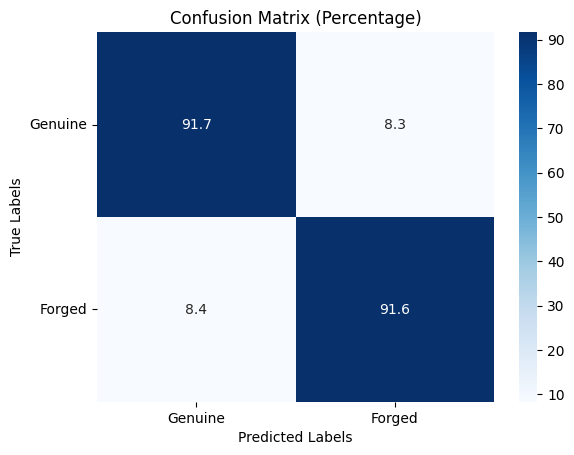

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       144
           1       0.91      0.92      0.91       131

    accuracy                           0.92       275
   macro avg       0.92      0.92      0.92       275
weighted avg       0.92      0.92      0.92       275



array([[132,  12],
       [ 11, 120]])

In [34]:
build_confusion_matrix(preds,labels)
print(classification_report(preds,labels))
confusion_matrix(preds,labels)

In [35]:
#@title Hindi Signature
folder = f'{handwritten_path}/BHSig260-Hindi/BHSig260-Hindi'
preds,labels = perform_voting_for_each_test_images(folder, handwritten_path)
confusion_matrix(preds,labels)

5it [00:01,  3.92it/s]


109	/BHSig260-Hindi/BHSig260-Hindi/109/H-S-109-F-17.tif	1	1


5it [00:01,  4.23it/s]


109	/BHSig260-Hindi/BHSig260-Hindi/109/H-S-109-G-16.tif	0	0


5it [00:01,  4.13it/s]


109	/BHSig260-Hindi/BHSig260-Hindi/109/H-S-109-G-18.tif	0	0


5it [00:01,  4.34it/s]


109	/BHSig260-Hindi/BHSig260-Hindi/109/H-S-109-G-04.tif	0	0


5it [00:01,  3.83it/s]


109	/BHSig260-Hindi/BHSig260-Hindi/109/H-S-109-F-26.tif	1	1


5it [00:01,  4.70it/s]


112	/BHSig260-Hindi/BHSig260-Hindi/112/H-S-112-F-14.tif	1	1


5it [00:00,  5.53it/s]


112	/BHSig260-Hindi/BHSig260-Hindi/112/H-S-112-G-08.tif	0	0


5it [00:00,  5.73it/s]


112	/BHSig260-Hindi/BHSig260-Hindi/112/H-S-112-G-10.tif	0	0


5it [00:00,  5.50it/s]


112	/BHSig260-Hindi/BHSig260-Hindi/112/H-S-112-G-14.tif	0	0


5it [00:01,  4.33it/s]


112	/BHSig260-Hindi/BHSig260-Hindi/112/H-S-112-F-28.tif	1	1


5it [00:01,  4.60it/s]


151	/BHSig260-Hindi/BHSig260-Hindi/151/H-S-151-G-13.tif	0	0


5it [00:01,  3.31it/s]


151	/BHSig260-Hindi/BHSig260-Hindi/151/H-S-151-F-04.tif	1	1


5it [00:01,  4.75it/s]


151	/BHSig260-Hindi/BHSig260-Hindi/151/H-S-151-G-17.tif	0	0


5it [00:01,  4.66it/s]


151	/BHSig260-Hindi/BHSig260-Hindi/151/H-S-151-G-18.tif	0	0


5it [00:01,  3.91it/s]


151	/BHSig260-Hindi/BHSig260-Hindi/151/H-S-151-F-27.tif	1	1


5it [00:01,  3.01it/s]


146	/BHSig260-Hindi/BHSig260-Hindi/146/H-S-146-F-04.tif	1	1


5it [00:01,  3.06it/s]


146	/BHSig260-Hindi/BHSig260-Hindi/146/H-S-146-F-24.tif	1	1


5it [00:01,  3.00it/s]


146	/BHSig260-Hindi/BHSig260-Hindi/146/H-S-146-F-22.tif	1	1


5it [00:01,  3.01it/s]


146	/BHSig260-Hindi/BHSig260-Hindi/146/H-S-146-F-13.tif	1	1


5it [00:01,  3.10it/s]


146	/BHSig260-Hindi/BHSig260-Hindi/146/H-S-146-F-01.tif	1	1


5it [00:01,  3.00it/s]


62	/BHSig260-Hindi/BHSig260-Hindi/62/H-S-62-F-21.tif	1	1


5it [00:01,  3.52it/s]


62	/BHSig260-Hindi/BHSig260-Hindi/62/H-S-62-G-20.tif	0	0


5it [00:01,  3.05it/s]


62	/BHSig260-Hindi/BHSig260-Hindi/62/H-S-62-F-06.tif	1	1


5it [00:01,  3.15it/s]


62	/BHSig260-Hindi/BHSig260-Hindi/62/H-S-62-F-30.tif	1	1


5it [00:01,  3.61it/s]


62	/BHSig260-Hindi/BHSig260-Hindi/62/H-S-62-G-01.tif	0	0


5it [00:01,  3.83it/s]


30	/BHSig260-Hindi/BHSig260-Hindi/30/H-S-30-F-06.tif	1	1


5it [00:01,  3.81it/s]


30	/BHSig260-Hindi/BHSig260-Hindi/30/H-S-30-F-07.tif	1	0


5it [00:01,  3.84it/s]


30	/BHSig260-Hindi/BHSig260-Hindi/30/H-S-30-G-10.tif	0	1


5it [00:01,  4.13it/s]


30	/BHSig260-Hindi/BHSig260-Hindi/30/H-S-30-G-02.tif	0	0


5it [00:01,  3.84it/s]


30	/BHSig260-Hindi/BHSig260-Hindi/30/H-S-30-G-14.tif	0	0


5it [00:01,  4.21it/s]


8	/BHSig260-Hindi/BHSig260-Hindi/8/H-S-8-G-22.tif	0	0


5it [00:01,  4.13it/s]


8	/BHSig260-Hindi/BHSig260-Hindi/8/H-S-8-F-11.tif	1	0


5it [00:01,  4.19it/s]


8	/BHSig260-Hindi/BHSig260-Hindi/8/H-S-8-G-09.tif	0	0


5it [00:01,  3.54it/s]


8	/BHSig260-Hindi/BHSig260-Hindi/8/H-S-8-G-20.tif	0	1


5it [00:01,  3.84it/s]


8	/BHSig260-Hindi/BHSig260-Hindi/8/H-S-8-F-10.tif	1	1


5it [00:00,  6.17it/s]


72	/BHSig260-Hindi/BHSig260-Hindi/72/H-S-72-G-03.tif	0	0


5it [00:00,  5.45it/s]


72	/BHSig260-Hindi/BHSig260-Hindi/72/H-S-72-F-04.tif	1	1


5it [00:00,  6.26it/s]


72	/BHSig260-Hindi/BHSig260-Hindi/72/H-S-72-G-05.tif	0	0


5it [00:00,  5.27it/s]


72	/BHSig260-Hindi/BHSig260-Hindi/72/H-S-72-F-13.tif	1	1


5it [00:00,  5.97it/s]


72	/BHSig260-Hindi/BHSig260-Hindi/72/H-S-72-G-13.tif	0	0


5it [00:01,  2.70it/s]


130	/BHSig260-Hindi/BHSig260-Hindi/130/H-S-130-F-07.tif	1	1


5it [00:01,  3.23it/s]


130	/BHSig260-Hindi/BHSig260-Hindi/130/H-S-130-F-23.tif	1	1


5it [00:01,  3.12it/s]


130	/BHSig260-Hindi/BHSig260-Hindi/130/H-S-130-F-20.tif	1	1


5it [00:01,  2.81it/s]


130	/BHSig260-Hindi/BHSig260-Hindi/130/H-S-130-F-06.tif	1	1


5it [00:01,  3.36it/s]


130	/BHSig260-Hindi/BHSig260-Hindi/130/H-S-130-G-07.tif	0	0


5it [00:01,  3.54it/s]


42	/BHSig260-Hindi/BHSig260-Hindi/42/H-S-42-G-22.tif	0	0


5it [00:01,  3.15it/s]


42	/BHSig260-Hindi/BHSig260-Hindi/42/H-S-42-F-13.tif	1	1


5it [00:01,  3.43it/s]


42	/BHSig260-Hindi/BHSig260-Hindi/42/H-S-42-F-28.tif	1	1


5it [00:01,  3.36it/s]


42	/BHSig260-Hindi/BHSig260-Hindi/42/H-S-42-F-21.tif	1	1


5it [00:01,  3.43it/s]


42	/BHSig260-Hindi/BHSig260-Hindi/42/H-S-42-F-26.tif	1	1


5it [00:01,  3.46it/s]


102	/BHSig260-Hindi/BHSig260-Hindi/102/H-S-102-F-12.tif	1	1


5it [00:01,  3.66it/s]


102	/BHSig260-Hindi/BHSig260-Hindi/102/H-S-102-G-01.tif	0	0


5it [00:01,  3.67it/s]


102	/BHSig260-Hindi/BHSig260-Hindi/102/H-S-102-F-08.tif	1	1


5it [00:01,  3.15it/s]


102	/BHSig260-Hindi/BHSig260-Hindi/102/H-S-102-G-06.tif	0	0


5it [00:01,  3.38it/s]


102	/BHSig260-Hindi/BHSig260-Hindi/102/H-S-102-G-20.tif	0	0


5it [00:01,  3.04it/s]


59	/BHSig260-Hindi/BHSig260-Hindi/59/H-S-59-F-17.tif	1	1


5it [00:01,  3.24it/s]


59	/BHSig260-Hindi/BHSig260-Hindi/59/H-S-59-F-10.tif	1	1


5it [00:01,  3.04it/s]


59	/BHSig260-Hindi/BHSig260-Hindi/59/H-S-59-F-08.tif	1	0


5it [00:01,  3.08it/s]


59	/BHSig260-Hindi/BHSig260-Hindi/59/H-S-59-F-30.tif	1	1


5it [00:01,  2.98it/s]


59	/BHSig260-Hindi/BHSig260-Hindi/59/H-S-59-F-11.tif	1	0


5it [00:01,  2.84it/s]


19	/BHSig260-Hindi/BHSig260-Hindi/19/H-S-19-F-21.tif	1	1


5it [00:01,  3.28it/s]


19	/BHSig260-Hindi/BHSig260-Hindi/19/H-S-19-G-17.tif	0	0


5it [00:01,  3.92it/s]


19	/BHSig260-Hindi/BHSig260-Hindi/19/H-S-19-G-04.tif	0	0


5it [00:01,  4.00it/s]


19	/BHSig260-Hindi/BHSig260-Hindi/19/H-S-19-G-01.tif	0	0


5it [00:01,  2.99it/s]


19	/BHSig260-Hindi/BHSig260-Hindi/19/H-S-19-F-30.tif	1	0


5it [00:01,  4.14it/s]


39	/BHSig260-Hindi/BHSig260-Hindi/39/H-S-39-G-11.tif	0	0


5it [00:01,  4.23it/s]


39	/BHSig260-Hindi/BHSig260-Hindi/39/H-S-39-G-02.tif	0	0


5it [00:01,  3.92it/s]


39	/BHSig260-Hindi/BHSig260-Hindi/39/H-S-39-F-02.tif	1	1


5it [00:01,  3.88it/s]


39	/BHSig260-Hindi/BHSig260-Hindi/39/H-S-39-F-04.tif	1	1


5it [00:01,  3.66it/s]


39	/BHSig260-Hindi/BHSig260-Hindi/39/H-S-39-F-16.tif	1	1


5it [00:01,  4.13it/s]


150	/BHSig260-Hindi/BHSig260-Hindi/150/H-S-150-F-17.tif	1	1


5it [00:01,  4.57it/s]


150	/BHSig260-Hindi/BHSig260-Hindi/150/H-S-150-G-02.tif	0	0


5it [00:01,  3.95it/s]


150	/BHSig260-Hindi/BHSig260-Hindi/150/H-S-150-F-13.tif	1	1


5it [00:01,  3.99it/s]


150	/BHSig260-Hindi/BHSig260-Hindi/150/H-S-150-F-28.tif	1	1


5it [00:01,  4.14it/s]


150	/BHSig260-Hindi/BHSig260-Hindi/150/H-S-150-G-13.tif	0	0


5it [00:01,  3.98it/s]


57	/BHSig260-Hindi/BHSig260-Hindi/57/H-S-57-F-07.tif	1	1


5it [00:00,  5.13it/s]


57	/BHSig260-Hindi/BHSig260-Hindi/57/H-S-57-G-22.tif	0	0


5it [00:01,  3.53it/s]


57	/BHSig260-Hindi/BHSig260-Hindi/57/H-S-57-F-20.tif	1	1


5it [00:01,  4.79it/s]


57	/BHSig260-Hindi/BHSig260-Hindi/57/H-S-57-G-24.tif	0	0


5it [00:01,  3.96it/s]


57	/BHSig260-Hindi/BHSig260-Hindi/57/H-S-57-F-17.tif	1	1


5it [00:01,  3.88it/s]


31	/BHSig260-Hindi/BHSig260-Hindi/31/H-S-31-F-04.tif	1	0


5it [00:01,  4.37it/s]


31	/BHSig260-Hindi/BHSig260-Hindi/31/H-S-31-G-19.tif	0	1


5it [00:01,  4.42it/s]


31	/BHSig260-Hindi/BHSig260-Hindi/31/H-S-31-G-23.tif	0	0


5it [00:01,  4.42it/s]


31	/BHSig260-Hindi/BHSig260-Hindi/31/H-S-31-G-04.tif	0	0


5it [00:01,  4.42it/s]


31	/BHSig260-Hindi/BHSig260-Hindi/31/H-S-31-F-17.tif	1	0


5it [00:01,  3.60it/s]


25	/BHSig260-Hindi/BHSig260-Hindi/25/H-S-25-F-15.tif	1	1


5it [00:01,  3.31it/s]


25	/BHSig260-Hindi/BHSig260-Hindi/25/H-S-25-G-18.tif	0	0


5it [00:01,  3.48it/s]


25	/BHSig260-Hindi/BHSig260-Hindi/25/H-S-25-F-23.tif	1	1


5it [00:01,  3.59it/s]


25	/BHSig260-Hindi/BHSig260-Hindi/25/H-S-25-F-14.tif	1	1


5it [00:01,  3.29it/s]


25	/BHSig260-Hindi/BHSig260-Hindi/25/H-S-25-F-04.tif	1	1


5it [00:01,  4.46it/s]


49	/BHSig260-Hindi/BHSig260-Hindi/49/H-S-49-F-01.tif	1	1


5it [00:00,  5.09it/s]


49	/BHSig260-Hindi/BHSig260-Hindi/49/H-S-49-G-04.tif	0	0


5it [00:01,  4.25it/s]


49	/BHSig260-Hindi/BHSig260-Hindi/49/H-S-49-G-24.tif	0	0


5it [00:01,  4.30it/s]


49	/BHSig260-Hindi/BHSig260-Hindi/49/H-S-49-F-09.tif	1	1


5it [00:01,  4.27it/s]


49	/BHSig260-Hindi/BHSig260-Hindi/49/H-S-49-F-30.tif	1	1


5it [00:01,  4.88it/s]


7	/BHSig260-Hindi/BHSig260-Hindi/7/H-S-7-G-24.tif	0	0


5it [00:00,  5.19it/s]


7	/BHSig260-Hindi/BHSig260-Hindi/7/H-S-7-G-17.tif	0	0


5it [00:01,  4.59it/s]


7	/BHSig260-Hindi/BHSig260-Hindi/7/H-S-7-F-04.tif	1	0


5it [00:01,  4.65it/s]


7	/BHSig260-Hindi/BHSig260-Hindi/7/H-S-7-F-26.tif	1	0


5it [00:01,  4.60it/s]


7	/BHSig260-Hindi/BHSig260-Hindi/7/H-S-7-F-28.tif	1	0


5it [00:01,  3.87it/s]


55	/BHSig260-Hindi/BHSig260-Hindi/55/H-S-55-G-11.tif	0	0


5it [00:01,  3.26it/s]


55	/BHSig260-Hindi/BHSig260-Hindi/55/H-S-55-F-07.tif	1	1


5it [00:01,  3.25it/s]


55	/BHSig260-Hindi/BHSig260-Hindi/55/H-S-55-F-16.tif	1	1


5it [00:01,  3.22it/s]


55	/BHSig260-Hindi/BHSig260-Hindi/55/H-S-55-F-24.tif	1	1


5it [00:01,  3.23it/s]


55	/BHSig260-Hindi/BHSig260-Hindi/55/H-S-55-F-10.tif	1	1


5it [00:01,  4.88it/s]


154	/BHSig260-Hindi/BHSig260-Hindi/154/H-S-154-G-18.tif	0	0


5it [00:01,  4.80it/s]


154	/BHSig260-Hindi/BHSig260-Hindi/154/H-S-154-G-07.tif	0	0


5it [00:01,  4.12it/s]


154	/BHSig260-Hindi/BHSig260-Hindi/154/H-S-154-F-07.tif	1	1


5it [00:01,  3.98it/s]


154	/BHSig260-Hindi/BHSig260-Hindi/154/H-S-154-F-03.tif	1	1


5it [00:01,  4.08it/s]


154	/BHSig260-Hindi/BHSig260-Hindi/154/H-S-154-F-20.tif	1	1


5it [00:00,  5.62it/s]


75	/BHSig260-Hindi/BHSig260-Hindi/75/H-S-75-F-15.tif	1	1


5it [00:00,  6.84it/s]


75	/BHSig260-Hindi/BHSig260-Hindi/75/H-S-75-G-08.tif	0	0


5it [00:00,  5.65it/s]


75	/BHSig260-Hindi/BHSig260-Hindi/75/H-S-75-F-22.tif	1	1


5it [00:00,  6.46it/s]


75	/BHSig260-Hindi/BHSig260-Hindi/75/H-S-75-G-05.tif	0	0


5it [00:00,  6.91it/s]


75	/BHSig260-Hindi/BHSig260-Hindi/75/H-S-75-G-23.tif	0	0


5it [00:01,  3.64it/s]


14	/BHSig260-Hindi/BHSig260-Hindi/14/H-S-14-F-06.tif	1	1


5it [00:01,  4.09it/s]


14	/BHSig260-Hindi/BHSig260-Hindi/14/H-S-14-G-17.tif	0	1


5it [00:01,  4.39it/s]


14	/BHSig260-Hindi/BHSig260-Hindi/14/H-S-14-G-05.tif	0	0


5it [00:01,  3.65it/s]


14	/BHSig260-Hindi/BHSig260-Hindi/14/H-S-14-F-24.tif	1	1


5it [00:01,  4.59it/s]


14	/BHSig260-Hindi/BHSig260-Hindi/14/H-S-14-G-02.tif	0	0


5it [00:01,  3.59it/s]


93	/BHSig260-Hindi/BHSig260-Hindi/93/H-S-093-F-25.tif	1	1


5it [00:01,  3.68it/s]


93	/BHSig260-Hindi/BHSig260-Hindi/93/H-S-093-F-02.tif	1	1


5it [00:01,  3.85it/s]


93	/BHSig260-Hindi/BHSig260-Hindi/93/H-S-093-G-21.tif	0	1


5it [00:01,  4.25it/s]


93	/BHSig260-Hindi/BHSig260-Hindi/93/H-S-093-G-19.tif	0	0


5it [00:01,  3.55it/s]


93	/BHSig260-Hindi/BHSig260-Hindi/93/H-S-093-F-18.tif	1	1


5it [00:01,  4.09it/s]


67	/BHSig260-Hindi/BHSig260-Hindi/67/H-S-67-F-07.tif	1	1


5it [00:00,  5.08it/s]


67	/BHSig260-Hindi/BHSig260-Hindi/67/H-S-67-G-04.tif	0	0


5it [00:01,  4.15it/s]


67	/BHSig260-Hindi/BHSig260-Hindi/67/H-S-67-F-28.tif	1	1


5it [00:01,  4.84it/s]


67	/BHSig260-Hindi/BHSig260-Hindi/67/H-S-67-G-14.tif	0	0


5it [00:01,  4.37it/s]


67	/BHSig260-Hindi/BHSig260-Hindi/67/H-S-67-F-29.tif	1	0


5it [00:01,  4.45it/s]


101	/BHSig260-Hindi/BHSig260-Hindi/101/H-S-101-F-25.tif	1	1


5it [00:01,  4.06it/s]


101	/BHSig260-Hindi/BHSig260-Hindi/101/H-S-101-F-07.tif	1	1


5it [00:01,  4.47it/s]


101	/BHSig260-Hindi/BHSig260-Hindi/101/H-S-101-G-10.tif	0	0


5it [00:01,  4.28it/s]


101	/BHSig260-Hindi/BHSig260-Hindi/101/H-S-101-F-24.tif	1	1


5it [00:01,  4.42it/s]


101	/BHSig260-Hindi/BHSig260-Hindi/101/H-S-101-F-02.tif	1	1


5it [00:01,  3.45it/s]


125	/BHSig260-Hindi/BHSig260-Hindi/125/H-S-125-F-23.tif	1	1


5it [00:01,  3.88it/s]


125	/BHSig260-Hindi/BHSig260-Hindi/125/H-S-125-F-13.tif	1	1


5it [00:01,  3.87it/s]


125	/BHSig260-Hindi/BHSig260-Hindi/125/H-S-125-G-19.tif	0	0


5it [00:01,  3.92it/s]


125	/BHSig260-Hindi/BHSig260-Hindi/125/H-S-125-F-26.tif	1	1


5it [00:01,  3.51it/s]


125	/BHSig260-Hindi/BHSig260-Hindi/125/H-S-125-G-10.tif	0	1


5it [00:01,  4.75it/s]


9	/BHSig260-Hindi/BHSig260-Hindi/9/H-S-9-G-23.tif	0	0


5it [00:01,  4.91it/s]


9	/BHSig260-Hindi/BHSig260-Hindi/9/H-S-9-G-04.tif	0	0


5it [00:01,  4.14it/s]


9	/BHSig260-Hindi/BHSig260-Hindi/9/H-S-9-F-12.tif	1	1


5it [00:01,  4.89it/s]


9	/BHSig260-Hindi/BHSig260-Hindi/9/H-S-9-G-10.tif	0	0


5it [00:01,  4.22it/s]


9	/BHSig260-Hindi/BHSig260-Hindi/9/H-S-9-F-02.tif	1	1


5it [00:01,  4.55it/s]


3	/BHSig260-Hindi/BHSig260-Hindi/3/H-S-3-G-13.tif	0	0


5it [00:01,  4.51it/s]


3	/BHSig260-Hindi/BHSig260-Hindi/3/H-S-3-F-22.tif	1	0


5it [00:01,  4.63it/s]


3	/BHSig260-Hindi/BHSig260-Hindi/3/H-S-3-G-17.tif	0	0


5it [00:01,  4.22it/s]


3	/BHSig260-Hindi/BHSig260-Hindi/3/H-S-3-F-17.tif	1	1


5it [00:01,  4.30it/s]


3	/BHSig260-Hindi/BHSig260-Hindi/3/H-S-3-F-29.tif	1	1


5it [00:01,  3.98it/s]


33	/BHSig260-Hindi/BHSig260-Hindi/33/H-S-33-F-20.tif	1	1


5it [00:01,  4.10it/s]


33	/BHSig260-Hindi/BHSig260-Hindi/33/H-S-33-G-07.tif	0	0


5it [00:01,  4.52it/s]


33	/BHSig260-Hindi/BHSig260-Hindi/33/H-S-33-G-05.tif	0	0


5it [00:01,  3.75it/s]


33	/BHSig260-Hindi/BHSig260-Hindi/33/H-S-33-F-15.tif	1	1


5it [00:01,  4.07it/s]


33	/BHSig260-Hindi/BHSig260-Hindi/33/H-S-33-F-08.tif	1	1


5it [00:00,  5.02it/s]


118	/BHSig260-Hindi/BHSig260-Hindi/118/H-S-118-G-08.tif	0	0


5it [00:01,  4.59it/s]


118	/BHSig260-Hindi/BHSig260-Hindi/118/H-S-118-F-19.tif	1	1


5it [00:01,  4.96it/s]


118	/BHSig260-Hindi/BHSig260-Hindi/118/H-S-118-F-01.tif	1	0


5it [00:00,  5.26it/s]


118	/BHSig260-Hindi/BHSig260-Hindi/118/H-S-118-G-23.tif	0	0


5it [00:01,  4.38it/s]


118	/BHSig260-Hindi/BHSig260-Hindi/118/H-S-118-F-12.tif	1	1


5it [00:01,  3.89it/s]


37	/BHSig260-Hindi/BHSig260-Hindi/37/H-S-37-F-27.tif	1	1


5it [00:01,  4.56it/s]


37	/BHSig260-Hindi/BHSig260-Hindi/37/H-S-37-G-08.tif	0	1


5it [00:01,  4.44it/s]


37	/BHSig260-Hindi/BHSig260-Hindi/37/H-S-37-G-17.tif	0	0


5it [00:01,  4.42it/s]


37	/BHSig260-Hindi/BHSig260-Hindi/37/H-S-37-G-15.tif	0	1


5it [00:01,  4.00it/s]


37	/BHSig260-Hindi/BHSig260-Hindi/37/H-S-37-F-24.tif	1	0


5it [00:01,  3.57it/s]


50	/BHSig260-Hindi/BHSig260-Hindi/50/H-S-50-F-01.tif	1	1


5it [00:01,  3.78it/s]


50	/BHSig260-Hindi/BHSig260-Hindi/50/H-S-50-F-22.tif	1	0


5it [00:01,  3.72it/s]


50	/BHSig260-Hindi/BHSig260-Hindi/50/H-S-50-F-15.tif	1	1


5it [00:01,  3.66it/s]


50	/BHSig260-Hindi/BHSig260-Hindi/50/H-S-50-F-30.tif	1	1


5it [00:01,  3.74it/s]


50	/BHSig260-Hindi/BHSig260-Hindi/50/H-S-50-F-13.tif	1	1


5it [00:01,  3.61it/s]


147	/BHSig260-Hindi/BHSig260-Hindi/147/H-S-147-G-11.tif	0	0


5it [00:01,  3.50it/s]


147	/BHSig260-Hindi/BHSig260-Hindi/147/H-S-147-F-03.tif	1	1


5it [00:01,  3.34it/s]


147	/BHSig260-Hindi/BHSig260-Hindi/147/H-S-147-F-21.tif	1	1


5it [00:01,  3.54it/s]


147	/BHSig260-Hindi/BHSig260-Hindi/147/H-S-147-F-29.tif	1	1


5it [00:01,  3.81it/s]


147	/BHSig260-Hindi/BHSig260-Hindi/147/H-S-147-G-10.tif	0	0


5it [00:01,  3.97it/s]


149	/BHSig260-Hindi/BHSig260-Hindi/149/H-S-149-F-06.tif	1	1


5it [00:01,  3.94it/s]


149	/BHSig260-Hindi/BHSig260-Hindi/149/H-S-149-F-23.tif	1	1


5it [00:01,  4.22it/s]


149	/BHSig260-Hindi/BHSig260-Hindi/149/H-S-149-G-06.tif	0	0


5it [00:01,  4.20it/s]


149	/BHSig260-Hindi/BHSig260-Hindi/149/H-S-149-G-07.tif	0	0


5it [00:01,  4.05it/s]


149	/BHSig260-Hindi/BHSig260-Hindi/149/H-S-149-G-22.tif	0	0


5it [00:00,  5.04it/s]


115	/BHSig260-Hindi/BHSig260-Hindi/115/H-S-115-F-09.tif	1	1


5it [00:00,  5.15it/s]


115	/BHSig260-Hindi/BHSig260-Hindi/115/H-S-115-F-06.tif	1	1


5it [00:00,  5.64it/s]


115	/BHSig260-Hindi/BHSig260-Hindi/115/H-S-115-G-18.tif	0	0


5it [00:01,  4.63it/s]


115	/BHSig260-Hindi/BHSig260-Hindi/115/H-S-115-F-13.tif	1	1


5it [00:00,  5.67it/s]


115	/BHSig260-Hindi/BHSig260-Hindi/115/H-S-115-G-12.tif	0	0


5it [00:01,  4.74it/s]


144	/BHSig260-Hindi/BHSig260-Hindi/144/H-S-144-F-09.tif	1	1


5it [00:01,  4.45it/s]


144	/BHSig260-Hindi/BHSig260-Hindi/144/H-S-144-F-14.tif	1	1


5it [00:00,  5.21it/s]


144	/BHSig260-Hindi/BHSig260-Hindi/144/H-S-144-F-07.tif	1	1


5it [00:00,  6.54it/s]


144	/BHSig260-Hindi/BHSig260-Hindi/144/H-S-144-G-21.tif	0	0


5it [00:00,  6.62it/s]


144	/BHSig260-Hindi/BHSig260-Hindi/144/H-S-144-G-09.tif	0	0


5it [00:01,  3.63it/s]


46	/BHSig260-Hindi/BHSig260-Hindi/46/H-S-46-G-01.tif	0	1


5it [00:01,  3.64it/s]


46	/BHSig260-Hindi/BHSig260-Hindi/46/H-S-46-G-04.tif	0	1


5it [00:01,  3.81it/s]


46	/BHSig260-Hindi/BHSig260-Hindi/46/H-S-46-F-30.tif	1	1


5it [00:01,  3.26it/s]


46	/BHSig260-Hindi/BHSig260-Hindi/46/H-S-46-F-09.tif	1	1


5it [00:01,  3.87it/s]


46	/BHSig260-Hindi/BHSig260-Hindi/46/H-S-46-G-15.tif	0	1


5it [00:01,  2.84it/s]


63	/BHSig260-Hindi/BHSig260-Hindi/63/H-S-63-F-23.tif	1	1


5it [00:01,  3.50it/s]


63	/BHSig260-Hindi/BHSig260-Hindi/63/H-S-63-G-01.tif	0	0


5it [00:01,  3.88it/s]


63	/BHSig260-Hindi/BHSig260-Hindi/63/H-S-63-G-24.tif	0	0


5it [00:01,  3.02it/s]


63	/BHSig260-Hindi/BHSig260-Hindi/63/H-S-63-F-13.tif	1	1


5it [00:01,  2.97it/s]


63	/BHSig260-Hindi/BHSig260-Hindi/63/H-S-63-F-10.tif	1	1


5it [00:01,  3.33it/s]


141	/BHSig260-Hindi/BHSig260-Hindi/141/H-S-141-F-11.tif	1	1


5it [00:01,  3.57it/s]


141	/BHSig260-Hindi/BHSig260-Hindi/141/H-S-141-F-27.tif	1	1


5it [00:01,  3.56it/s]


141	/BHSig260-Hindi/BHSig260-Hindi/141/H-S-141-G-12.tif	0	0


5it [00:01,  3.57it/s]


141	/BHSig260-Hindi/BHSig260-Hindi/141/H-S-141-F-03.tif	1	1


5it [00:01,  3.37it/s]


141	/BHSig260-Hindi/BHSig260-Hindi/141/H-S-141-F-24.tif	1	1


5it [00:01,  4.83it/s]


159	/BHSig260-Hindi/BHSig260-Hindi/159/H-S-159-G-22.tif	0	0


5it [00:00,  5.50it/s]


159	/BHSig260-Hindi/BHSig260-Hindi/159/H-S-159-F-21.tif	1	0


5it [00:00,  5.03it/s]


159	/BHSig260-Hindi/BHSig260-Hindi/159/H-S-159-G-06.tif	0	0


5it [00:00,  5.36it/s]


159	/BHSig260-Hindi/BHSig260-Hindi/159/H-S-159-F-26.tif	1	0


5it [00:00,  5.40it/s]


159	/BHSig260-Hindi/BHSig260-Hindi/159/H-S-159-F-20.tif	1	0


5it [00:00,  5.07it/s]


96	/BHSig260-Hindi/BHSig260-Hindi/96/H-S-96-F-11.tif	1	0


5it [00:01,  4.98it/s]


96	/BHSig260-Hindi/BHSig260-Hindi/96/H-S-96-F-07.tif	1	0


5it [00:01,  4.83it/s]


96	/BHSig260-Hindi/BHSig260-Hindi/96/H-S-96-F-04.tif	1	1


5it [00:01,  4.69it/s]


96	/BHSig260-Hindi/BHSig260-Hindi/96/H-S-96-F-29.tif	1	1


5it [00:01,  4.60it/s]


96	/BHSig260-Hindi/BHSig260-Hindi/96/H-S-96-F-18.tif	1	1


5it [00:00,  5.72it/s]


65	/BHSig260-Hindi/BHSig260-Hindi/65/H-S-65-G-10.tif	0	0


5it [00:01,  4.28it/s]


65	/BHSig260-Hindi/BHSig260-Hindi/65/H-S-65-F-06.tif	1	1


5it [00:01,  4.33it/s]


65	/BHSig260-Hindi/BHSig260-Hindi/65/H-S-65-F-21.tif	1	1


5it [00:01,  4.16it/s]


65	/BHSig260-Hindi/BHSig260-Hindi/65/H-S-65-F-08.tif	1	1


5it [00:01,  3.87it/s]


65	/BHSig260-Hindi/BHSig260-Hindi/65/H-S-65-F-15.tif	1	1


5it [00:01,  4.38it/s]


133	/BHSig260-Hindi/BHSig260-Hindi/133/H-S-133-F-02.tif	1	1


5it [00:00,  5.16it/s]


133	/BHSig260-Hindi/BHSig260-Hindi/133/H-S-133-F-23.tif	1	1


5it [00:01,  4.99it/s]


133	/BHSig260-Hindi/BHSig260-Hindi/133/H-S-133-G-14.tif	0	0


5it [00:01,  4.60it/s]


133	/BHSig260-Hindi/BHSig260-Hindi/133/H-S-133-G-07.tif	0	0


5it [00:00,  5.23it/s]


133	/BHSig260-Hindi/BHSig260-Hindi/133/H-S-133-F-10.tif	1	1


5it [00:01,  2.88it/s]


80	/BHSig260-Hindi/BHSig260-Hindi/80/H-S-80-G-19.tif	0	0


5it [00:01,  2.79it/s]


80	/BHSig260-Hindi/BHSig260-Hindi/80/H-S-80-F-17.tif	1	0


5it [00:01,  2.89it/s]


80	/BHSig260-Hindi/BHSig260-Hindi/80/H-S-80-G-04.tif	0	0


5it [00:01,  2.98it/s]


80	/BHSig260-Hindi/BHSig260-Hindi/80/H-S-80-F-02.tif	1	0


5it [00:01,  3.11it/s]


80	/BHSig260-Hindi/BHSig260-Hindi/80/H-S-80-F-09.tif	1	0


5it [00:01,  3.69it/s]


145	/BHSig260-Hindi/BHSig260-Hindi/145/H-S-145-G-12.tif	0	0


5it [00:01,  4.02it/s]


145	/BHSig260-Hindi/BHSig260-Hindi/145/H-S-145-G-01.tif	0	0


5it [00:01,  3.85it/s]


145	/BHSig260-Hindi/BHSig260-Hindi/145/H-S-145-F-26.tif	1	1


5it [00:01,  3.90it/s]


145	/BHSig260-Hindi/BHSig260-Hindi/145/H-S-145-F-04.tif	1	1


5it [00:01,  3.44it/s]


145	/BHSig260-Hindi/BHSig260-Hindi/145/H-S-145-F-14.tif	1	1


5it [00:01,  3.58it/s]


123	/BHSig260-Hindi/BHSig260-Hindi/123/H-S-123-F-07.tif	1	1


5it [00:01,  3.39it/s]


123	/BHSig260-Hindi/BHSig260-Hindi/123/H-S-124-G-22.tif	0	0


5it [00:01,  3.44it/s]


123	/BHSig260-Hindi/BHSig260-Hindi/123/H-S-124-G-05.tif	0	0


5it [00:01,  3.54it/s]


123	/BHSig260-Hindi/BHSig260-Hindi/123/H-S-123-F-20.tif	1	1


5it [00:01,  3.46it/s]


123	/BHSig260-Hindi/BHSig260-Hindi/123/H-S-123-F-21.tif	1	0


5it [00:01,  2.78it/s]


134	/BHSig260-Hindi/BHSig260-Hindi/134/H-S-134-F-05.tif	1	1


5it [00:01,  2.89it/s]


134	/BHSig260-Hindi/BHSig260-Hindi/134/H-S-134-G-18.tif	0	0


5it [00:01,  2.90it/s]


134	/BHSig260-Hindi/BHSig260-Hindi/134/H-S-134-F-24.tif	1	1


5it [00:01,  2.68it/s]


134	/BHSig260-Hindi/BHSig260-Hindi/134/H-S-134-G-21.tif	0	0


5it [00:01,  3.02it/s]


134	/BHSig260-Hindi/BHSig260-Hindi/134/H-S-134-F-25.tif	1	1


5it [00:00,  5.97it/s]


160	/BHSig260-Hindi/BHSig260-Hindi/160/H-S-160-G-17.tif	0	0


5it [00:01,  4.94it/s]


160	/BHSig260-Hindi/BHSig260-Hindi/160/H-S-160-G-15.tif	0	0


5it [00:00,  5.07it/s]


160	/BHSig260-Hindi/BHSig260-Hindi/160/H-S-160-F-26.tif	1	1


5it [00:00,  5.44it/s]


160	/BHSig260-Hindi/BHSig260-Hindi/160/H-S-160-F-13.tif	1	1


5it [00:01,  4.78it/s]


160	/BHSig260-Hindi/BHSig260-Hindi/160/H-S-160-F-09.tif	1	1


5it [00:00,  5.64it/s]


24	/BHSig260-Hindi/BHSig260-Hindi/24/H-S-24-G-18.tif	0	0


5it [00:01,  4.47it/s]


24	/BHSig260-Hindi/BHSig260-Hindi/24/H-S-24-F-24.tif	1	1


5it [00:01,  4.30it/s]


24	/BHSig260-Hindi/BHSig260-Hindi/24/H-S-24-F-01.tif	1	1


5it [00:01,  4.21it/s]


24	/BHSig260-Hindi/BHSig260-Hindi/24/H-S-24-F-18.tif	1	1


5it [00:01,  4.63it/s]


24	/BHSig260-Hindi/BHSig260-Hindi/24/H-S-24-F-14.tif	1	1


5it [00:01,  4.81it/s]


38	/BHSig260-Hindi/BHSig260-Hindi/38/H-S-38-F-21.tif	1	0


5it [00:01,  4.78it/s]


38	/BHSig260-Hindi/BHSig260-Hindi/38/H-S-38-G-10.tif	0	0


5it [00:01,  4.66it/s]


38	/BHSig260-Hindi/BHSig260-Hindi/38/H-S-38-G-01.tif	0	0


5it [00:01,  4.68it/s]


38	/BHSig260-Hindi/BHSig260-Hindi/38/H-S-38-G-05.tif	0	0


5it [00:01,  4.71it/s]


38	/BHSig260-Hindi/BHSig260-Hindi/38/H-S-38-G-14.tif	0	0


5it [00:01,  4.25it/s]


107	/BHSig260-Hindi/BHSig260-Hindi/107/H-S-107-G-02.tif	0	0


5it [00:01,  3.44it/s]


107	/BHSig260-Hindi/BHSig260-Hindi/107/H-S-107-F-12.tif	1	1


5it [00:01,  3.79it/s]


107	/BHSig260-Hindi/BHSig260-Hindi/107/H-S-107-F-10.tif	1	0


5it [00:01,  3.63it/s]


107	/BHSig260-Hindi/BHSig260-Hindi/107/H-S-107-F-28.tif	1	1


5it [00:01,  4.01it/s]


107	/BHSig260-Hindi/BHSig260-Hindi/107/H-S-107-F-02.tif	1	0


5it [00:01,  4.20it/s]


136	/BHSig260-Hindi/BHSig260-Hindi/136/H-S-136-F-21.tif	1	1


5it [00:00,  5.21it/s]


136	/BHSig260-Hindi/BHSig260-Hindi/136/H-S-136-G-19.tif	0	0


5it [00:01,  4.96it/s]


136	/BHSig260-Hindi/BHSig260-Hindi/136/H-S-136-F-30.tif	1	1


5it [00:00,  5.24it/s]


136	/BHSig260-Hindi/BHSig260-Hindi/136/H-S-136-F-07.tif	1	1


5it [00:01,  4.84it/s]


136	/BHSig260-Hindi/BHSig260-Hindi/136/H-S-136-F-15.tif	1	1


5it [00:01,  3.77it/s]


94	/BHSig260-Hindi/BHSig260-Hindi/94/H-S-94-F-14.tif	1	1


5it [00:01,  3.67it/s]


94	/BHSig260-Hindi/BHSig260-Hindi/94/H-S-94-F-20.tif	1	0


5it [00:01,  3.73it/s]


94	/BHSig260-Hindi/BHSig260-Hindi/94/H-S-94-F-17.tif	1	1


5it [00:01,  3.56it/s]


94	/BHSig260-Hindi/BHSig260-Hindi/94/H-S-94-F-18.tif	1	0


5it [00:01,  4.15it/s]


94	/BHSig260-Hindi/BHSig260-Hindi/94/H-S-94-F-04.tif	1	0


5it [00:00,  5.29it/s]


5	/BHSig260-Hindi/BHSig260-Hindi/5/H-S-5-G-22.tif	0	0


5it [00:00,  5.02it/s]


5	/BHSig260-Hindi/BHSig260-Hindi/5/H-S-5-F-02.tif	1	0


5it [00:00,  5.52it/s]


5	/BHSig260-Hindi/BHSig260-Hindi/5/H-S-5-G-17.tif	0	0


5it [00:00,  5.33it/s]


5	/BHSig260-Hindi/BHSig260-Hindi/5/H-S-5-G-04.tif	0	0


5it [00:00,  5.20it/s]


5	/BHSig260-Hindi/BHSig260-Hindi/5/H-S-5-G-24.tif	0	0


5it [00:01,  4.45it/s]


21	/BHSig260-Hindi/BHSig260-Hindi/21/H-S-21-G-02.tif	0	0


5it [00:01,  3.87it/s]


21	/BHSig260-Hindi/BHSig260-Hindi/21/H-S-21-F-24.tif	1	1


5it [00:01,  4.09it/s]


21	/BHSig260-Hindi/BHSig260-Hindi/21/H-S-21-F-15.tif	1	0


5it [00:01,  3.77it/s]


21	/BHSig260-Hindi/BHSig260-Hindi/21/H-S-21-F-06.tif	1	1


5it [00:01,  4.06it/s]


21	/BHSig260-Hindi/BHSig260-Hindi/21/H-S-21-F-17.tif	1	1


5it [00:00,  5.22it/s]


69	/BHSig260-Hindi/BHSig260-Hindi/69/H-S-69-F-28.tif	1	1


5it [00:00,  5.92it/s]


69	/BHSig260-Hindi/BHSig260-Hindi/69/H-S-69-G-21.tif	0	0


5it [00:00,  5.90it/s]


69	/BHSig260-Hindi/BHSig260-Hindi/69/H-S-69-G-14.tif	0	0


5it [00:00,  5.91it/s]


69	/BHSig260-Hindi/BHSig260-Hindi/69/H-S-69-G-02.tif	0	0


5it [00:00,  5.69it/s]


69	/BHSig260-Hindi/BHSig260-Hindi/69/H-S-69-G-15.tif	0	0


5it [00:01,  4.49it/s]


92	/BHSig260-Hindi/BHSig260-Hindi/92/H-S-92-F-05.tif	1	1


5it [00:00,  5.10it/s]


92	/BHSig260-Hindi/BHSig260-Hindi/92/H-S-92-G-07.tif	0	0


5it [00:01,  4.47it/s]


92	/BHSig260-Hindi/BHSig260-Hindi/92/H-S-92-F-11.tif	1	1


5it [00:01,  4.55it/s]


92	/BHSig260-Hindi/BHSig260-Hindi/92/H-S-92-F-06.tif	1	1


5it [00:01,  4.26it/s]


92	/BHSig260-Hindi/BHSig260-Hindi/92/H-S-92-F-09.tif	1	1


5it [00:01,  2.71it/s]


110	/BHSig260-Hindi/BHSig260-Hindi/110/H-S-110-F-29.tif	1	1


5it [00:01,  2.91it/s]


110	/BHSig260-Hindi/BHSig260-Hindi/110/H-S-110-F-11.tif	1	1


5it [00:01,  2.83it/s]


110	/BHSig260-Hindi/BHSig260-Hindi/110/H-S-110-F-27.tif	1	1


5it [00:01,  3.11it/s]


110	/BHSig260-Hindi/BHSig260-Hindi/110/H-S-110-G-01.tif	0	0


5it [00:01,  2.99it/s]


110	/BHSig260-Hindi/BHSig260-Hindi/110/H-S-110-F-25.tif	1	1


5it [00:01,  3.81it/s]


17	/BHSig260-Hindi/BHSig260-Hindi/17/H-S-017-G-20.tif	0	0


5it [00:01,  3.61it/s]


17	/BHSig260-Hindi/BHSig260-Hindi/17/H-S-017-G-17.tif	0	0


5it [00:01,  3.65it/s]


17	/BHSig260-Hindi/BHSig260-Hindi/17/H-S-017-G-07.tif	0	1


5it [00:01,  4.03it/s]


17	/BHSig260-Hindi/BHSig260-Hindi/17/H-S-017-F-29.tif	1	0


5it [00:01,  4.12it/s]


17	/BHSig260-Hindi/BHSig260-Hindi/17/H-S-017-F-25.tif	1	0


5it [00:01,  3.88it/s]


139	/BHSig260-Hindi/BHSig260-Hindi/139/H-S-139-F-18.tif	1	1


5it [00:01,  4.51it/s]


139	/BHSig260-Hindi/BHSig260-Hindi/139/H-S-139-G-20.tif	0	0


5it [00:01,  3.98it/s]


139	/BHSig260-Hindi/BHSig260-Hindi/139/H-S-139-F-21.tif	1	1


5it [00:01,  3.86it/s]


139	/BHSig260-Hindi/BHSig260-Hindi/139/H-S-139-F-13.tif	1	1


5it [00:01,  3.72it/s]


139	/BHSig260-Hindi/BHSig260-Hindi/139/H-S-139-F-11.tif	1	1


5it [00:01,  4.38it/s]


158	/BHSig260-Hindi/BHSig260-Hindi/158/H-S-158-G-02.tif	0	0


5it [00:01,  3.66it/s]


158	/BHSig260-Hindi/BHSig260-Hindi/158/H-S-158-F-06.tif	1	1


5it [00:01,  4.56it/s]


158	/BHSig260-Hindi/BHSig260-Hindi/158/H-S-158-G-01.tif	0	0


5it [00:01,  4.22it/s]


158	/BHSig260-Hindi/BHSig260-Hindi/158/H-S-158-F-24.tif	1	1


5it [00:01,  4.27it/s]


158	/BHSig260-Hindi/BHSig260-Hindi/158/H-S-158-F-01.tif	1	1


5it [00:01,  3.19it/s]


116	/BHSig260-Hindi/BHSig260-Hindi/116/H-S-116-F-08.tif	1	1


5it [00:00,  5.59it/s]


116	/BHSig260-Hindi/BHSig260-Hindi/116/H-S-116-G-09.tif	0	0


5it [00:01,  3.88it/s]


116	/BHSig260-Hindi/BHSig260-Hindi/116/H-S-116-F-03.tif	1	1


5it [00:01,  4.15it/s]


116	/BHSig260-Hindi/BHSig260-Hindi/116/H-S-116-F-30.tif	1	1


5it [00:01,  4.08it/s]


116	/BHSig260-Hindi/BHSig260-Hindi/116/H-S-116-F-24.tif	1	1


5it [00:01,  3.44it/s]


77	/BHSig260-Hindi/BHSig260-Hindi/77/H-S-77-F-05.tif	1	1


5it [00:01,  3.46it/s]


77	/BHSig260-Hindi/BHSig260-Hindi/77/H-S-77-F-03.tif	1	1


5it [00:01,  3.54it/s]


77	/BHSig260-Hindi/BHSig260-Hindi/77/H-S-77-F-13.tif	1	1


5it [00:01,  3.56it/s]


77	/BHSig260-Hindi/BHSig260-Hindi/77/H-S-77-F-26.tif	1	1


5it [00:01,  4.23it/s]


77	/BHSig260-Hindi/BHSig260-Hindi/77/H-S-77-G-12.tif	0	0


5it [00:01,  4.12it/s]


152	/BHSig260-Hindi/BHSig260-Hindi/152/H-S-152-F-11.tif	1	1


5it [00:01,  4.26it/s]


152	/BHSig260-Hindi/BHSig260-Hindi/152/H-S-152-G-15.tif	0	0


5it [00:01,  3.48it/s]


152	/BHSig260-Hindi/BHSig260-Hindi/152/H-S-152-F-18.tif	1	1


5it [00:01,  3.85it/s]


152	/BHSig260-Hindi/BHSig260-Hindi/152/H-S-152-G-20.tif	0	0


5it [00:01,  4.00it/s]


152	/BHSig260-Hindi/BHSig260-Hindi/152/H-S-152-G-09.tif	0	0


5it [00:01,  4.16it/s]


148	/BHSig260-Hindi/BHSig260-Hindi/148/H-S-148-F-09.tif	1	1


5it [00:00,  6.13it/s]


148	/BHSig260-Hindi/BHSig260-Hindi/148/H-S-148-G-11.tif	0	0


5it [00:01,  4.60it/s]


148	/BHSig260-Hindi/BHSig260-Hindi/148/H-S-148-F-28.tif	1	1


5it [00:00,  6.05it/s]


148	/BHSig260-Hindi/BHSig260-Hindi/148/H-S-148-G-04.tif	0	0


5it [00:01,  4.40it/s]


148	/BHSig260-Hindi/BHSig260-Hindi/148/H-S-148-F-06.tif	1	1


5it [00:01,  4.19it/s]


156	/BHSig260-Hindi/BHSig260-Hindi/156/H-S-156-F-16.tif	1	1


5it [00:01,  4.62it/s]


156	/BHSig260-Hindi/BHSig260-Hindi/156/H-S-156-G-18.tif	0	0


5it [00:01,  4.64it/s]


156	/BHSig260-Hindi/BHSig260-Hindi/156/H-S-156-G-09.tif	0	0


5it [00:01,  4.56it/s]


156	/BHSig260-Hindi/BHSig260-Hindi/156/H-S-156-G-08.tif	0	0


5it [00:01,  4.29it/s]


156	/BHSig260-Hindi/BHSig260-Hindi/156/H-S-156-F-27.tif	1	1


5it [00:01,  4.82it/s]


119	/BHSig260-Hindi/BHSig260-Hindi/119/H-S-119-F-12.tif	1	0


5it [00:00,  5.12it/s]


119	/BHSig260-Hindi/BHSig260-Hindi/119/H-S-119-G-14.tif	0	0


5it [00:00,  5.34it/s]


119	/BHSig260-Hindi/BHSig260-Hindi/119/H-S-119-G-12.tif	0	1


5it [00:01,  4.84it/s]


119	/BHSig260-Hindi/BHSig260-Hindi/119/H-S-119-F-16.tif	1	0


5it [00:01,  4.58it/s]


119	/BHSig260-Hindi/BHSig260-Hindi/119/H-S-119-F-07.tif	1	1


5it [00:01,  4.77it/s]


128	/BHSig260-Hindi/BHSig260-Hindi/128/H-S-128-F-11.tif	1	1


5it [00:01,  4.86it/s]


128	/BHSig260-Hindi/BHSig260-Hindi/128/H-S-128-G-19.tif	0	0


5it [00:01,  4.68it/s]


128	/BHSig260-Hindi/BHSig260-Hindi/128/H-S-128-G-01.tif	0	0


5it [00:01,  4.45it/s]


128	/BHSig260-Hindi/BHSig260-Hindi/128/H-S-128-G-16.tif	0	0


5it [00:01,  5.00it/s]


128	/BHSig260-Hindi/BHSig260-Hindi/128/H-S-128-G-08.tif	0	0


5it [00:01,  3.49it/s]


12	/BHSig260-Hindi/BHSig260-Hindi/12/H-S-12-G-22.tif	0	0


5it [00:01,  3.49it/s]


12	/BHSig260-Hindi/BHSig260-Hindi/12/H-S-12-F-09.tif	1	1


5it [00:01,  3.46it/s]


12	/BHSig260-Hindi/BHSig260-Hindi/12/H-S-12-F-03.tif	1	1


5it [00:01,  3.62it/s]


12	/BHSig260-Hindi/BHSig260-Hindi/12/H-S-12-G-05.tif	0	0


5it [00:01,  3.46it/s]


12	/BHSig260-Hindi/BHSig260-Hindi/12/H-S-12-F-11.tif	1	1


5it [00:01,  4.03it/s]


58	/BHSig260-Hindi/BHSig260-Hindi/58/H-S-58-F-15.tif	1	1


5it [00:01,  3.68it/s]


58	/BHSig260-Hindi/BHSig260-Hindi/58/H-S-58-F-01.tif	1	1


5it [00:00,  5.08it/s]


58	/BHSig260-Hindi/BHSig260-Hindi/58/H-S-58-G-06.tif	0	0


5it [00:01,  4.13it/s]


58	/BHSig260-Hindi/BHSig260-Hindi/58/H-S-58-F-09.tif	1	1


5it [00:01,  4.72it/s]


58	/BHSig260-Hindi/BHSig260-Hindi/58/H-S-58-G-14.tif	0	0


5it [00:01,  3.63it/s]


95	/BHSig260-Hindi/BHSig260-Hindi/95/H-S-95-F-26.tif	1	0


5it [00:01,  4.24it/s]


95	/BHSig260-Hindi/BHSig260-Hindi/95/H-S-95-G-16.tif	0	1


5it [00:01,  3.86it/s]


95	/BHSig260-Hindi/BHSig260-Hindi/95/H-S-95-F-16.tif	1	1


5it [00:01,  3.87it/s]


95	/BHSig260-Hindi/BHSig260-Hindi/95/H-S-95-F-06.tif	1	1


5it [00:01,  4.72it/s]


95	/BHSig260-Hindi/BHSig260-Hindi/95/H-S-95-G-24.tif	0	0


5it [00:01,  3.61it/s]


98	/BHSig260-Hindi/BHSig260-Hindi/98/H-S-98-F-14.tif	1	1


5it [00:01,  3.75it/s]


98	/BHSig260-Hindi/BHSig260-Hindi/98/H-S-98-F-21.tif	1	1


5it [00:01,  3.70it/s]


98	/BHSig260-Hindi/BHSig260-Hindi/98/H-S-98-F-15.tif	1	1


5it [00:01,  3.51it/s]


98	/BHSig260-Hindi/BHSig260-Hindi/98/H-S-98-G-13.tif	0	0


5it [00:01,  3.89it/s]


98	/BHSig260-Hindi/BHSig260-Hindi/98/H-S-98-F-09.tif	1	0


5it [00:01,  4.17it/s]


90	/BHSig260-Hindi/BHSig260-Hindi/90/H-S-90-G-21.tif	0	0


5it [00:01,  4.08it/s]


90	/BHSig260-Hindi/BHSig260-Hindi/90/H-S-90-G-07.tif	0	0


5it [00:01,  4.03it/s]


90	/BHSig260-Hindi/BHSig260-Hindi/90/H-S-90-G-09.tif	0	0


5it [00:01,  3.98it/s]


90	/BHSig260-Hindi/BHSig260-Hindi/90/H-S-90-F-30.tif	1	1


5it [00:01,  4.01it/s]


90	/BHSig260-Hindi/BHSig260-Hindi/90/H-S-90-G-19.tif	0	0


5it [00:01,  3.19it/s]


70	/BHSig260-Hindi/BHSig260-Hindi/70/H-S-70-F-15.tif	1	1


5it [00:01,  3.30it/s]


70	/BHSig260-Hindi/BHSig260-Hindi/70/H-S-70-F-30.tif	1	1


5it [00:01,  2.91it/s]


70	/BHSig260-Hindi/BHSig260-Hindi/70/H-S-70-F-20.tif	1	1


5it [00:01,  2.96it/s]


70	/BHSig260-Hindi/BHSig260-Hindi/70/H-S-70-F-17.tif	1	1


5it [00:01,  3.14it/s]


70	/BHSig260-Hindi/BHSig260-Hindi/70/H-S-70-G-02.tif	0	0


5it [00:00,  5.57it/s]


45	/BHSig260-Hindi/BHSig260-Hindi/45/H-S-45-F-22.tif	1	0


5it [00:00,  5.73it/s]


45	/BHSig260-Hindi/BHSig260-Hindi/45/H-S-45-F-21.tif	1	0


5it [00:00,  6.43it/s]


45	/BHSig260-Hindi/BHSig260-Hindi/45/H-S-45-G-07.tif	0	0


5it [00:00,  6.12it/s]


45	/BHSig260-Hindi/BHSig260-Hindi/45/H-S-45-G-16.tif	0	0


5it [00:00,  5.71it/s]


45	/BHSig260-Hindi/BHSig260-Hindi/45/H-S-45-F-07.tif	1	1


5it [00:01,  3.13it/s]


104	/BHSig260-Hindi/BHSig260-Hindi/104/H-S-104-F-16.tif	1	1


5it [00:01,  3.33it/s]


104	/BHSig260-Hindi/BHSig260-Hindi/104/H-S-104-G-08.tif	0	0


5it [00:01,  3.22it/s]


104	/BHSig260-Hindi/BHSig260-Hindi/104/H-S-104-F-29.tif	1	1


5it [00:01,  3.23it/s]


104	/BHSig260-Hindi/BHSig260-Hindi/104/H-S-104-F-20.tif	1	1


5it [00:01,  3.51it/s]


104	/BHSig260-Hindi/BHSig260-Hindi/104/H-S-104-G-15.tif	0	0


5it [00:01,  4.10it/s]


135	/BHSig260-Hindi/BHSig260-Hindi/135/H-S-135-F-05.tif	1	1


5it [00:01,  4.12it/s]


135	/BHSig260-Hindi/BHSig260-Hindi/135/H-S-135-F-16.tif	1	1


5it [00:01,  4.37it/s]


135	/BHSig260-Hindi/BHSig260-Hindi/135/H-S-135-G-10.tif	0	0


5it [00:01,  3.48it/s]


135	/BHSig260-Hindi/BHSig260-Hindi/135/H-S-135-G-05.tif	0	0


5it [00:01,  4.02it/s]


135	/BHSig260-Hindi/BHSig260-Hindi/135/H-S-135-F-17.tif	1	1


5it [00:01,  4.83it/s]


81	/BHSig260-Hindi/BHSig260-Hindi/81/H-S-81-G-10.tif	0	0


5it [00:01,  4.86it/s]


81	/BHSig260-Hindi/BHSig260-Hindi/81/H-S-81-G-08.tif	0	0


5it [00:01,  4.76it/s]


81	/BHSig260-Hindi/BHSig260-Hindi/81/H-S-81-F-19.tif	1	1


5it [00:01,  4.72it/s]


81	/BHSig260-Hindi/BHSig260-Hindi/81/H-S-81-F-06.tif	1	1


5it [00:01,  4.55it/s]


81	/BHSig260-Hindi/BHSig260-Hindi/81/H-S-81-F-28.tif	1	0


5it [00:01,  3.01it/s]


117	/BHSig260-Hindi/BHSig260-Hindi/117/H-S-117-F-06.tif	1	1


5it [00:01,  3.14it/s]


117	/BHSig260-Hindi/BHSig260-Hindi/117/H-S-117-G-14.tif	0	0


5it [00:01,  2.94it/s]


117	/BHSig260-Hindi/BHSig260-Hindi/117/H-S-117-F-09.tif	1	1


5it [00:01,  2.71it/s]


117	/BHSig260-Hindi/BHSig260-Hindi/117/H-S-117-F-24.tif	1	1


5it [00:01,  2.92it/s]


117	/BHSig260-Hindi/BHSig260-Hindi/117/H-S-117-F-26.tif	1	1


5it [00:00,  6.73it/s]


120	/BHSig260-Hindi/BHSig260-Hindi/120/H-S-120-F-10.tif	1	0


5it [00:00,  6.70it/s]


120	/BHSig260-Hindi/BHSig260-Hindi/120/H-S-120-F-05.tif	1	0


5it [00:00,  7.60it/s]


120	/BHSig260-Hindi/BHSig260-Hindi/120/H-S-120-G-21.tif	0	0


5it [00:00,  6.65it/s]


120	/BHSig260-Hindi/BHSig260-Hindi/120/H-S-120-F-29.tif	1	0


5it [00:00,  6.46it/s]


120	/BHSig260-Hindi/BHSig260-Hindi/120/H-S-120-F-06.tif	1	0


5it [00:02,  2.38it/s]


66	/BHSig260-Hindi/BHSig260-Hindi/66/H-S-66-G-13.tif	0	0


5it [00:01,  2.61it/s]


66	/BHSig260-Hindi/BHSig260-Hindi/66/H-S-66-F-29.tif	1	1


5it [00:02,  2.42it/s]


66	/BHSig260-Hindi/BHSig260-Hindi/66/H-S-66-G-21.tif	0	0


5it [00:02,  2.39it/s]


66	/BHSig260-Hindi/BHSig260-Hindi/66/H-S-66-G-22.tif	0	0


5it [00:01,  2.56it/s]


66	/BHSig260-Hindi/BHSig260-Hindi/66/H-S-66-F-12.tif	1	1


5it [00:00,  5.39it/s]


44	/BHSig260-Hindi/BHSig260-Hindi/44/H-S-44-F-20.tif	1	0


5it [00:00,  6.14it/s]


44	/BHSig260-Hindi/BHSig260-Hindi/44/H-S-44-G-09.tif	0	0


5it [00:00,  6.36it/s]


44	/BHSig260-Hindi/BHSig260-Hindi/44/H-S-44-G-01.tif	0	0


5it [00:00,  5.38it/s]


44	/BHSig260-Hindi/BHSig260-Hindi/44/H-S-44-G-05.tif	0	0


5it [00:00,  5.52it/s]


44	/BHSig260-Hindi/BHSig260-Hindi/44/H-S-44-F-05.tif	1	1


5it [00:01,  3.91it/s]


79	/BHSig260-Hindi/BHSig260-Hindi/79/H-S-79-F-11.tif	1	1


5it [00:01,  3.92it/s]


79	/BHSig260-Hindi/BHSig260-Hindi/79/H-S-79-F-24.tif	1	1


5it [00:01,  4.78it/s]


79	/BHSig260-Hindi/BHSig260-Hindi/79/H-S-79-G-10.tif	0	0


5it [00:01,  4.17it/s]


79	/BHSig260-Hindi/BHSig260-Hindi/79/H-S-79-F-03.tif	1	1


5it [00:01,  4.32it/s]


79	/BHSig260-Hindi/BHSig260-Hindi/79/H-S-79-F-01.tif	1	1


5it [00:00,  5.41it/s]


47	/BHSig260-Hindi/BHSig260-Hindi/47/H-S-47-F-10.tif	1	0


5it [00:00,  5.44it/s]


47	/BHSig260-Hindi/BHSig260-Hindi/47/H-S-47-F-13.tif	1	0


5it [00:00,  5.11it/s]


47	/BHSig260-Hindi/BHSig260-Hindi/47/H-S-47-G-06.tif	0	0


5it [00:00,  5.20it/s]


47	/BHSig260-Hindi/BHSig260-Hindi/47/H-S-47-F-09.tif	1	0


5it [00:01,  4.90it/s]


47	/BHSig260-Hindi/BHSig260-Hindi/47/H-S-47-F-14.tif	1	0


5it [00:01,  4.61it/s]


153	/BHSig260-Hindi/BHSig260-Hindi/153/H-S-153-F-10.tif	1	1


5it [00:01,  4.04it/s]


153	/BHSig260-Hindi/BHSig260-Hindi/153/H-S-153-F-21.tif	1	1


5it [00:01,  4.58it/s]


153	/BHSig260-Hindi/BHSig260-Hindi/153/H-S-153-F-26.tif	1	1


5it [00:01,  4.51it/s]


153	/BHSig260-Hindi/BHSig260-Hindi/153/H-S-153-F-27.tif	1	1


5it [00:01,  4.66it/s]


153	/BHSig260-Hindi/BHSig260-Hindi/153/H-S-153-F-04.tif	1	1


5it [00:01,  4.66it/s]


91	/BHSig260-Hindi/BHSig260-Hindi/91/H-S-91-G-20.tif	0	0


5it [00:01,  3.95it/s]


91	/BHSig260-Hindi/BHSig260-Hindi/91/H-S-91-F-08.tif	1	1


5it [00:01,  3.71it/s]


91	/BHSig260-Hindi/BHSig260-Hindi/91/H-S-91-F-29.tif	1	1


5it [00:01,  3.83it/s]


91	/BHSig260-Hindi/BHSig260-Hindi/91/H-S-91-F-17.tif	1	1


5it [00:01,  4.05it/s]


91	/BHSig260-Hindi/BHSig260-Hindi/91/H-S-91-F-30.tif	1	1


5it [00:01,  3.62it/s]


53	/BHSig260-Hindi/BHSig260-Hindi/53/H-S-53-G-02.tif	0	0


5it [00:01,  3.49it/s]


53	/BHSig260-Hindi/BHSig260-Hindi/53/H-S-53-F-28.tif	1	1


5it [00:01,  3.30it/s]


53	/BHSig260-Hindi/BHSig260-Hindi/53/H-S-53-F-25.tif	1	1


5it [00:01,  2.98it/s]


53	/BHSig260-Hindi/BHSig260-Hindi/53/H-S-53-F-10.tif	1	1


5it [00:01,  3.63it/s]


53	/BHSig260-Hindi/BHSig260-Hindi/53/H-S-53-G-12.tif	0	0


5it [00:01,  3.51it/s]


76	/BHSig260-Hindi/BHSig260-Hindi/76/H-S-076-F-06.tif	1	0


5it [00:01,  3.71it/s]


76	/BHSig260-Hindi/BHSig260-Hindi/76/H-S-076-F-17.tif	1	0


5it [00:01,  3.71it/s]


76	/BHSig260-Hindi/BHSig260-Hindi/76/H-S-076-F-11.tif	1	0


5it [00:01,  3.54it/s]


76	/BHSig260-Hindi/BHSig260-Hindi/76/H-S-076-F-10.tif	1	0


5it [00:01,  3.75it/s]


76	/BHSig260-Hindi/BHSig260-Hindi/76/H-S-076-G-11.tif	0	0


5it [00:01,  4.02it/s]


22	/BHSig260-Hindi/BHSig260-Hindi/22/H-S-22-F-03.tif	1	1


5it [00:01,  4.07it/s]


22	/BHSig260-Hindi/BHSig260-Hindi/22/H-S-22-G-23.tif	0	1


5it [00:01,  4.07it/s]


22	/BHSig260-Hindi/BHSig260-Hindi/22/H-S-22-F-10.tif	1	1


5it [00:01,  3.81it/s]


22	/BHSig260-Hindi/BHSig260-Hindi/22/H-S-22-F-08.tif	1	1


5it [00:01,  3.80it/s]


22	/BHSig260-Hindi/BHSig260-Hindi/22/H-S-22-F-25.tif	1	1


5it [00:00,  6.08it/s]


40	/BHSig260-Hindi/BHSig260-Hindi/40/H-S-40-G-16.tif	0	0


5it [00:00,  5.01it/s]


40	/BHSig260-Hindi/BHSig260-Hindi/40/H-S-40-F-10.tif	1	1


5it [00:00,  5.97it/s]


40	/BHSig260-Hindi/BHSig260-Hindi/40/H-S-40-G-11.tif	0	0


5it [00:00,  5.87it/s]


40	/BHSig260-Hindi/BHSig260-Hindi/40/H-S-40-G-18.tif	0	0


5it [00:00,  6.26it/s]


40	/BHSig260-Hindi/BHSig260-Hindi/40/H-S-40-G-19.tif	0	0


5it [00:02,  2.49it/s]


28	/BHSig260-Hindi/BHSig260-Hindi/28/H-S-28-G-23.tif	0	0


5it [00:01,  2.68it/s]


28	/BHSig260-Hindi/BHSig260-Hindi/28/H-S-28-F-04.tif	1	1


5it [00:01,  2.75it/s]


28	/BHSig260-Hindi/BHSig260-Hindi/28/H-S-28-F-15.tif	1	1


5it [00:01,  2.68it/s]


28	/BHSig260-Hindi/BHSig260-Hindi/28/H-S-28-F-20.tif	1	1


5it [00:02,  2.50it/s]


28	/BHSig260-Hindi/BHSig260-Hindi/28/H-S-28-G-01.tif	0	0


5it [00:01,  4.59it/s]


6	/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-23.tif	0	0


5it [00:01,  4.24it/s]


6	/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-30.tif	1	1


5it [00:01,  3.91it/s]


6	/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-15.tif	1	1


5it [00:01,  3.79it/s]


6	/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-29.tif	1	1


5it [00:01,  4.58it/s]


6	/BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-06.tif	0	0


5it [00:01,  3.39it/s]


87	/BHSig260-Hindi/BHSig260-Hindi/87/H-S-087-G-15.tif	0	0


5it [00:01,  2.90it/s]


87	/BHSig260-Hindi/BHSig260-Hindi/87/H-S-087-F-20.tif	1	1


5it [00:01,  2.97it/s]


87	/BHSig260-Hindi/BHSig260-Hindi/87/H-S-087-F-28.tif	1	1


5it [00:01,  3.00it/s]


87	/BHSig260-Hindi/BHSig260-Hindi/87/H-S-087-F-23.tif	1	1


5it [00:01,  2.96it/s]


87	/BHSig260-Hindi/BHSig260-Hindi/87/H-S-087-F-17.tif	1	1


5it [00:01,  4.20it/s]


34	/BHSig260-Hindi/BHSig260-Hindi/34/H-S-34-F-09.tif	1	1


5it [00:01,  4.25it/s]


34	/BHSig260-Hindi/BHSig260-Hindi/34/H-S-34-F-07.tif	1	1


5it [00:01,  3.85it/s]


34	/BHSig260-Hindi/BHSig260-Hindi/34/H-S-34-F-20.tif	1	1


5it [00:01,  4.12it/s]


34	/BHSig260-Hindi/BHSig260-Hindi/34/H-S-34-F-21.tif	1	1


5it [00:01,  4.60it/s]


34	/BHSig260-Hindi/BHSig260-Hindi/34/H-S-34-G-12.tif	0	0


5it [00:01,  3.47it/s]


48	/BHSig260-Hindi/BHSig260-Hindi/48/H-S-48-G-05.tif	0	1


5it [00:01,  3.36it/s]


48	/BHSig260-Hindi/BHSig260-Hindi/48/H-S-48-G-10.tif	0	0


5it [00:01,  3.50it/s]


48	/BHSig260-Hindi/BHSig260-Hindi/48/H-S-48-G-19.tif	0	0


5it [00:01,  3.63it/s]


48	/BHSig260-Hindi/BHSig260-Hindi/48/H-S-48-F-23.tif	1	1


5it [00:01,  3.32it/s]


48	/BHSig260-Hindi/BHSig260-Hindi/48/H-S-48-F-26.tif	1	1


5it [00:01,  4.88it/s]


121	/BHSig260-Hindi/BHSig260-Hindi/121/H-S-121-F-22.tif	1	0


5it [00:00,  5.80it/s]


121	/BHSig260-Hindi/BHSig260-Hindi/121/H-S-121-G-09.tif	0	0


5it [00:01,  4.71it/s]


121	/BHSig260-Hindi/BHSig260-Hindi/121/H-S-121-F-16.tif	1	0


5it [00:00,  5.11it/s]


121	/BHSig260-Hindi/BHSig260-Hindi/121/H-S-121-F-14.tif	1	0


5it [00:00,  5.50it/s]


121	/BHSig260-Hindi/BHSig260-Hindi/121/H-S-121-G-17.tif	0	0


5it [00:01,  4.48it/s]


138	/BHSig260-Hindi/BHSig260-Hindi/138/H-S-138-F-25.tif	1	1


5it [00:00,  5.44it/s]


138	/BHSig260-Hindi/BHSig260-Hindi/138/H-S-138-G-12.tif	0	0


5it [00:00,  5.51it/s]


138	/BHSig260-Hindi/BHSig260-Hindi/138/H-S-138-G-24.tif	0	0


5it [00:00,  5.18it/s]


138	/BHSig260-Hindi/BHSig260-Hindi/138/H-S-138-G-14.tif	0	0


5it [00:00,  5.41it/s]


138	/BHSig260-Hindi/BHSig260-Hindi/138/H-S-138-G-22.tif	0	0


5it [00:01,  3.46it/s]


100	/BHSig260-Hindi/BHSig260-Hindi/100/H-S-100-F-23.tif	1	1


5it [00:01,  3.71it/s]


100	/BHSig260-Hindi/BHSig260-Hindi/100/H-S-100-G-11.tif	0	0


5it [00:01,  3.02it/s]


100	/BHSig260-Hindi/BHSig260-Hindi/100/H-S-100-F-16.tif	1	1


5it [00:01,  3.27it/s]


100	/BHSig260-Hindi/BHSig260-Hindi/100/H-S-100-F-25.tif	1	1


5it [00:01,  3.14it/s]


100	/BHSig260-Hindi/BHSig260-Hindi/100/H-S-100-F-24.tif	1	1


5it [00:01,  2.81it/s]


20	/BHSig260-Hindi/BHSig260-Hindi/20/H-S-20-F-28.tif	1	1


5it [00:01,  3.18it/s]


20	/BHSig260-Hindi/BHSig260-Hindi/20/H-S-20-G-20.tif	0	0


5it [00:01,  3.16it/s]


20	/BHSig260-Hindi/BHSig260-Hindi/20/H-S-20-G-08.tif	0	0


5it [00:01,  3.29it/s]


20	/BHSig260-Hindi/BHSig260-Hindi/20/H-S-20-F-14.tif	1	1


5it [00:01,  2.97it/s]


20	/BHSig260-Hindi/BHSig260-Hindi/20/H-S-20-F-12.tif	1	1


5it [00:01,  4.29it/s]


23	/BHSig260-Hindi/BHSig260-Hindi/23/H-S-23-F-30.tif	1	1


5it [00:01,  4.62it/s]


23	/BHSig260-Hindi/BHSig260-Hindi/23/H-S-23-G-21.tif	0	0


5it [00:01,  4.60it/s]


23	/BHSig260-Hindi/BHSig260-Hindi/23/H-S-23-G-06.tif	0	0


5it [00:00,  5.04it/s]


23	/BHSig260-Hindi/BHSig260-Hindi/23/H-S-23-F-12.tif	1	0


5it [00:01,  4.43it/s]


23	/BHSig260-Hindi/BHSig260-Hindi/23/H-S-23-F-02.tif	1	1


5it [00:01,  2.66it/s]


27	/BHSig260-Hindi/BHSig260-Hindi/27/H-S-27-F-23.tif	1	1


5it [00:01,  2.69it/s]


27	/BHSig260-Hindi/BHSig260-Hindi/27/H-S-27-F-02.tif	1	1


5it [00:01,  2.64it/s]


27	/BHSig260-Hindi/BHSig260-Hindi/27/H-S-27-F-05.tif	1	0


5it [00:01,  2.92it/s]


27	/BHSig260-Hindi/BHSig260-Hindi/27/H-S-27-G-05.tif	0	0


5it [00:01,  3.02it/s]


27	/BHSig260-Hindi/BHSig260-Hindi/27/H-S-27-G-02.tif	0	0


5it [00:01,  4.69it/s]


32	/BHSig260-Hindi/BHSig260-Hindi/32/H-S-32-F-06.tif	1	0


5it [00:01,  4.67it/s]


32	/BHSig260-Hindi/BHSig260-Hindi/32/H-S-32-F-04.tif	1	0


5it [00:01,  4.76it/s]


32	/BHSig260-Hindi/BHSig260-Hindi/32/H-S-32-G-13.tif	0	0


5it [00:01,  4.67it/s]


32	/BHSig260-Hindi/BHSig260-Hindi/32/H-S-32-F-18.tif	1	0


5it [00:01,  4.89it/s]


32	/BHSig260-Hindi/BHSig260-Hindi/32/H-S-32-G-17.tif	0	0


5it [00:00,  7.73it/s]


105	/BHSig260-Hindi/BHSig260-Hindi/105/H-S-105-G-22.tif	0	0


5it [00:00,  6.65it/s]


105	/BHSig260-Hindi/BHSig260-Hindi/105/H-S-105-F-11.tif	1	0


5it [00:00,  6.35it/s]


105	/BHSig260-Hindi/BHSig260-Hindi/105/H-S-105-F-22.tif	1	0


5it [00:00,  6.40it/s]


105	/BHSig260-Hindi/BHSig260-Hindi/105/H-S-105-F-12.tif	1	0


5it [00:00,  7.10it/s]


105	/BHSig260-Hindi/BHSig260-Hindi/105/H-S-105-F-13.tif	1	0


5it [00:01,  4.34it/s]


113	/BHSig260-Hindi/BHSig260-Hindi/113/H-S-113-G-07.tif	0	0


5it [00:01,  4.39it/s]


113	/BHSig260-Hindi/BHSig260-Hindi/113/H-S-113-G-09.tif	0	0


5it [00:00,  5.02it/s]


113	/BHSig260-Hindi/BHSig260-Hindi/113/H-S-113-F-04.tif	1	1


5it [00:01,  3.80it/s]


113	/BHSig260-Hindi/BHSig260-Hindi/113/H-S-113-F-21.tif	1	1


5it [00:01,  4.26it/s]


113	/BHSig260-Hindi/BHSig260-Hindi/113/H-S-113-F-19.tif	1	1


5it [00:01,  3.73it/s]


126	/BHSig260-Hindi/BHSig260-Hindi/126/H-S-126-G-10.tif	0	0


5it [00:01,  4.00it/s]


126	/BHSig260-Hindi/BHSig260-Hindi/126/H-S-126-G-11.tif	0	0


5it [00:01,  3.98it/s]


126	/BHSig260-Hindi/BHSig260-Hindi/126/H-S-126-F-01.tif	1	1


5it [00:01,  3.65it/s]


126	/BHSig260-Hindi/BHSig260-Hindi/126/H-S-126-F-11.tif	1	0


5it [00:01,  3.60it/s]


126	/BHSig260-Hindi/BHSig260-Hindi/126/H-S-126-F-22.tif	1	0


5it [00:01,  4.58it/s]


155	/BHSig260-Hindi/BHSig260-Hindi/155/H-S-155-G-16.tif	0	0


5it [00:01,  4.16it/s]


155	/BHSig260-Hindi/BHSig260-Hindi/155/H-S-155-F-06.tif	1	1


5it [00:01,  4.73it/s]


155	/BHSig260-Hindi/BHSig260-Hindi/155/H-S-155-G-01.tif	0	0


5it [00:01,  4.87it/s]


155	/BHSig260-Hindi/BHSig260-Hindi/155/H-S-155-G-08.tif	0	0


5it [00:01,  4.43it/s]


155	/BHSig260-Hindi/BHSig260-Hindi/155/H-S-155-F-18.tif	1	1


5it [00:01,  3.65it/s]


108	/BHSig260-Hindi/BHSig260-Hindi/108/H-S-108-F-28.tif	1	1


5it [00:01,  4.26it/s]


108	/BHSig260-Hindi/BHSig260-Hindi/108/H-S-108-G-06.tif	0	0


5it [00:01,  3.77it/s]


108	/BHSig260-Hindi/BHSig260-Hindi/108/H-S-108-F-01.tif	1	0


5it [00:01,  3.70it/s]


108	/BHSig260-Hindi/BHSig260-Hindi/108/H-S-108-F-07.tif	1	1


5it [00:01,  3.42it/s]


108	/BHSig260-Hindi/BHSig260-Hindi/108/H-S-108-F-02.tif	1	0


5it [00:01,  3.76it/s]


73	/BHSig260-Hindi/BHSig260-Hindi/73/H-S-73-F-23.tif	1	0


5it [00:01,  3.58it/s]


73	/BHSig260-Hindi/BHSig260-Hindi/73/H-S-73-F-03.tif	1	0


5it [00:01,  3.58it/s]


73	/BHSig260-Hindi/BHSig260-Hindi/73/H-S-73-G-12.tif	0	0


5it [00:01,  3.84it/s]


73	/BHSig260-Hindi/BHSig260-Hindi/73/H-S-73-F-07.tif	1	0


5it [00:01,  3.76it/s]


73	/BHSig260-Hindi/BHSig260-Hindi/73/H-S-73-F-26.tif	1	0


5it [00:01,  4.27it/s]


52	/BHSig260-Hindi/BHSig260-Hindi/52/H-S-52-F-01.tif	1	1


5it [00:01,  4.28it/s]


52	/BHSig260-Hindi/BHSig260-Hindi/52/H-S-52-F-30.tif	1	0


5it [00:01,  3.99it/s]


52	/BHSig260-Hindi/BHSig260-Hindi/52/H-S-52-G-08.tif	0	0


5it [00:01,  4.20it/s]


52	/BHSig260-Hindi/BHSig260-Hindi/52/H-S-52-F-18.tif	1	1


5it [00:01,  3.92it/s]


52	/BHSig260-Hindi/BHSig260-Hindi/52/H-S-52-G-14.tif	0	0


5it [00:01,  4.87it/s]


16	/BHSig260-Hindi/BHSig260-Hindi/16/H-S-16-F-27.tif	1	1


5it [00:01,  4.88it/s]


16	/BHSig260-Hindi/BHSig260-Hindi/16/H-S-16-F-03.tif	1	1


5it [00:00,  5.81it/s]


16	/BHSig260-Hindi/BHSig260-Hindi/16/H-S-16-G-18.tif	0	0


5it [00:00,  5.97it/s]


16	/BHSig260-Hindi/BHSig260-Hindi/16/H-S-16-G-08.tif	0	0


5it [00:00,  5.98it/s]


16	/BHSig260-Hindi/BHSig260-Hindi/16/H-S-16-G-19.tif	0	0


5it [00:01,  3.63it/s]


56	/BHSig260-Hindi/BHSig260-Hindi/56/H-S-56-F-02.tif	1	1


5it [00:00,  5.96it/s]


56	/BHSig260-Hindi/BHSig260-Hindi/56/H-S-56-G-24.tif	0	0


5it [00:01,  4.10it/s]


56	/BHSig260-Hindi/BHSig260-Hindi/56/H-S-56-F-18.tif	1	1


5it [00:00,  6.04it/s]


56	/BHSig260-Hindi/BHSig260-Hindi/56/H-S-56-G-10.tif	0	0


5it [00:00,  5.96it/s]


56	/BHSig260-Hindi/BHSig260-Hindi/56/H-S-56-G-11.tif	0	0


5it [00:01,  3.86it/s]


43	/BHSig260-Hindi/BHSig260-Hindi/43/H-S-43-F-02.tif	1	0


5it [00:01,  3.73it/s]


43	/BHSig260-Hindi/BHSig260-Hindi/43/H-S-43-F-13.tif	1	0


5it [00:01,  4.18it/s]


43	/BHSig260-Hindi/BHSig260-Hindi/43/H-S-43-G-10.tif	0	0


5it [00:01,  3.72it/s]


43	/BHSig260-Hindi/BHSig260-Hindi/43/H-S-43-F-28.tif	1	1


5it [00:01,  3.85it/s]


43	/BHSig260-Hindi/BHSig260-Hindi/43/H-S-43-F-08.tif	1	0


5it [00:01,  4.60it/s]


82	/BHSig260-Hindi/BHSig260-Hindi/82/H-S-82-F-16.tif	1	1


5it [00:00,  5.09it/s]


82	/BHSig260-Hindi/BHSig260-Hindi/82/H-S-82-G-12.tif	0	0


5it [00:01,  4.47it/s]


82	/BHSig260-Hindi/BHSig260-Hindi/82/H-S-82-F-01.tif	1	1


5it [00:01,  4.28it/s]


82	/BHSig260-Hindi/BHSig260-Hindi/82/H-S-82-F-08.tif	1	1


5it [00:01,  4.70it/s]


82	/BHSig260-Hindi/BHSig260-Hindi/82/H-S-82-F-17.tif	1	1


5it [00:00,  6.18it/s]


103	/BHSig260-Hindi/BHSig260-Hindi/103/H-S-103-G-09.tif	0	0


5it [00:00,  5.79it/s]


103	/BHSig260-Hindi/BHSig260-Hindi/103/H-S-103-G-24.tif	0	0


5it [00:00,  6.61it/s]


103	/BHSig260-Hindi/BHSig260-Hindi/103/H-S-103-G-01.tif	0	0


5it [00:00,  6.19it/s]


103	/BHSig260-Hindi/BHSig260-Hindi/103/H-S-103-G-07.tif	0	0


5it [00:01,  4.63it/s]


103	/BHSig260-Hindi/BHSig260-Hindi/103/H-S-103-F-06.tif	1	1


5it [00:01,  4.03it/s]


60	/BHSig260-Hindi/BHSig260-Hindi/60/H-S-60-F-04.tif	1	1


5it [00:01,  3.96it/s]


60	/BHSig260-Hindi/BHSig260-Hindi/60/H-S-60-F-22.tif	1	1


5it [00:01,  4.20it/s]


60	/BHSig260-Hindi/BHSig260-Hindi/60/H-S-60-G-16.tif	0	0


5it [00:01,  3.80it/s]


60	/BHSig260-Hindi/BHSig260-Hindi/60/H-S-60-F-16.tif	1	1


5it [00:01,  4.03it/s]


60	/BHSig260-Hindi/BHSig260-Hindi/60/H-S-60-G-15.tif	0	0


5it [00:01,  3.56it/s]


10	/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-G-04.tif	0	0


5it [00:01,  3.55it/s]


10	/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-17.tif	1	0


5it [00:01,  3.60it/s]


10	/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-01.tif	1	1


5it [00:01,  3.65it/s]


10	/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-02.tif	1	0


5it [00:01,  3.47it/s]


10	/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-03.tif	1	0


5it [00:00,  5.05it/s]


124	/BHSig260-Hindi/BHSig260-Hindi/124/H-S-124-F-17.tif	1	1


5it [00:00,  5.24it/s]


124	/BHSig260-Hindi/BHSig260-Hindi/124/H-S-124-F-29.tif	1	1


5it [00:00,  5.03it/s]


124	/BHSig260-Hindi/BHSig260-Hindi/124/H-S-124-F-22.tif	1	1


5it [00:01,  4.86it/s]


124	/BHSig260-Hindi/BHSig260-Hindi/124/H-S-124-F-09.tif	1	1


5it [00:00,  5.54it/s]


124	/BHSig260-Hindi/BHSig260-Hindi/124/H-S-124-G-14.tif	0	0


5it [00:01,  4.14it/s]


85	/BHSig260-Hindi/BHSig260-Hindi/85/H-S-85-G-04.tif	0	0


5it [00:01,  4.10it/s]


85	/BHSig260-Hindi/BHSig260-Hindi/85/H-S-85-F-17.tif	1	0


5it [00:01,  4.66it/s]


85	/BHSig260-Hindi/BHSig260-Hindi/85/H-S-85-G-06.tif	0	0


5it [00:01,  4.25it/s]


85	/BHSig260-Hindi/BHSig260-Hindi/85/H-S-85-G-05.tif	0	0


5it [00:01,  3.96it/s]


85	/BHSig260-Hindi/BHSig260-Hindi/85/H-S-85-F-15.tif	1	0


5it [00:01,  2.85it/s]


84	/BHSig260-Hindi/BHSig260-Hindi/84/H-S-84-F-12.tif	1	1


5it [00:01,  2.97it/s]


84	/BHSig260-Hindi/BHSig260-Hindi/84/H-S-84-F-16.tif	1	1


5it [00:01,  2.74it/s]


84	/BHSig260-Hindi/BHSig260-Hindi/84/H-S-84-F-04.tif	1	1


5it [00:01,  2.87it/s]


84	/BHSig260-Hindi/BHSig260-Hindi/84/H-S-84-F-09.tif	1	1


5it [00:01,  3.11it/s]


84	/BHSig260-Hindi/BHSig260-Hindi/84/H-S-84-F-26.tif	1	1


5it [00:01,  4.29it/s]


71	/BHSig260-Hindi/BHSig260-Hindi/71/H-S-71-F-28.tif	1	1


5it [00:01,  4.65it/s]


71	/BHSig260-Hindi/BHSig260-Hindi/71/H-S-71-G-16.tif	0	0


5it [00:01,  4.83it/s]


71	/BHSig260-Hindi/BHSig260-Hindi/71/H-S-71-G-24.tif	0	0


5it [00:01,  4.85it/s]


71	/BHSig260-Hindi/BHSig260-Hindi/71/H-S-71-G-11.tif	0	0


5it [00:01,  4.73it/s]


71	/BHSig260-Hindi/BHSig260-Hindi/71/H-S-71-F-12.tif	1	0


5it [00:01,  3.62it/s]


35	/BHSig260-Hindi/BHSig260-Hindi/35/H-S-035-F-07.tif	1	1


5it [00:01,  4.68it/s]


35	/BHSig260-Hindi/BHSig260-Hindi/35/H-S-035-G-22.tif	0	0


5it [00:01,  2.92it/s]


35	/BHSig260-Hindi/BHSig260-Hindi/35/H-S-035-F-01.tif	1	1


5it [00:01,  4.68it/s]


35	/BHSig260-Hindi/BHSig260-Hindi/35/H-S-035-G-06.tif	0	0


5it [00:01,  4.70it/s]


35	/BHSig260-Hindi/BHSig260-Hindi/35/H-S-035-G-08.tif	0	0


5it [00:01,  3.19it/s]


1	/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-12.tif	1	1


5it [00:01,  4.10it/s]


1	/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-12.tif	0	0


5it [00:01,  3.33it/s]


1	/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-11.tif	1	1


5it [00:01,  4.62it/s]


1	/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-02.tif	0	0


5it [00:01,  3.46it/s]


1	/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-17.tif	1	1


5it [00:00,  6.95it/s]


140	/BHSig260-Hindi/BHSig260-Hindi/140/H-S-140-G-01.tif	0	0


5it [00:00,  6.77it/s]


140	/BHSig260-Hindi/BHSig260-Hindi/140/H-S-140-G-16.tif	0	0


5it [00:00,  6.91it/s]


140	/BHSig260-Hindi/BHSig260-Hindi/140/H-S-140-G-04.tif	0	0


5it [00:00,  6.51it/s]


140	/BHSig260-Hindi/BHSig260-Hindi/140/H-S-140-G-17.tif	0	0


5it [00:00,  6.72it/s]


140	/BHSig260-Hindi/BHSig260-Hindi/140/H-S-140-G-03.tif	0	0


5it [00:00,  5.35it/s]


99	/BHSig260-Hindi/BHSig260-Hindi/99/H-S-99-F-21.tif	1	0


5it [00:00,  6.48it/s]


99	/BHSig260-Hindi/BHSig260-Hindi/99/H-S-99-G-04.tif	0	0


5it [00:00,  5.20it/s]


99	/BHSig260-Hindi/BHSig260-Hindi/99/H-S-99-F-05.tif	1	1


5it [00:00,  6.32it/s]


99	/BHSig260-Hindi/BHSig260-Hindi/99/H-S-99-G-14.tif	0	0


5it [00:00,  5.75it/s]


99	/BHSig260-Hindi/BHSig260-Hindi/99/H-S-99-G-03.tif	0	0


5it [00:01,  3.60it/s]


106	/BHSig260-Hindi/BHSig260-Hindi/106/H-S-106-G-18.tif	0	0


5it [00:01,  3.91it/s]


106	/BHSig260-Hindi/BHSig260-Hindi/106/H-S-106-F-10.tif	1	0


5it [00:01,  2.73it/s]


106	/BHSig260-Hindi/BHSig260-Hindi/106/H-S-106-F-22.tif	1	0


5it [00:01,  3.77it/s]


106	/BHSig260-Hindi/BHSig260-Hindi/106/H-S-106-F-15.tif	1	0


5it [00:01,  3.46it/s]


106	/BHSig260-Hindi/BHSig260-Hindi/106/H-S-106-G-02.tif	0	0


5it [00:01,  3.43it/s]


4	/BHSig260-Hindi/BHSig260-Hindi/4/H-S-4-G-03.tif	0	1


5it [00:01,  3.39it/s]


4	/BHSig260-Hindi/BHSig260-Hindi/4/H-S-4-G-10.tif	0	0


5it [00:01,  3.13it/s]


4	/BHSig260-Hindi/BHSig260-Hindi/4/H-S-4-G-19.tif	0	0


5it [00:01,  2.82it/s]


4	/BHSig260-Hindi/BHSig260-Hindi/4/H-S-4-F-22.tif	1	1


5it [00:01,  3.22it/s]


4	/BHSig260-Hindi/BHSig260-Hindi/4/H-S-4-G-21.tif	0	1


5it [00:00,  5.32it/s]


15	/BHSig260-Hindi/BHSig260-Hindi/15/H-S-15-F-14.tif	1	1


5it [00:00,  6.12it/s]


15	/BHSig260-Hindi/BHSig260-Hindi/15/H-S-15-G-09.tif	0	0


5it [00:00,  5.74it/s]


15	/BHSig260-Hindi/BHSig260-Hindi/15/H-S-15-G-01.tif	0	0


5it [00:00,  5.41it/s]


15	/BHSig260-Hindi/BHSig260-Hindi/15/H-S-15-F-29.tif	1	1


5it [00:01,  4.89it/s]


15	/BHSig260-Hindi/BHSig260-Hindi/15/H-S-15-F-13.tif	1	1


5it [00:00,  5.35it/s]


97	/BHSig260-Hindi/BHSig260-Hindi/97/H-S-97-G-14.tif	0	0


5it [00:01,  3.65it/s]


97	/BHSig260-Hindi/BHSig260-Hindi/97/H-S-97-F-27.tif	1	1


5it [00:01,  3.84it/s]


97	/BHSig260-Hindi/BHSig260-Hindi/97/H-S-97-F-16.tif	1	1


5it [00:01,  3.93it/s]


97	/BHSig260-Hindi/BHSig260-Hindi/97/H-S-97-F-25.tif	1	1


5it [00:00,  5.38it/s]


97	/BHSig260-Hindi/BHSig260-Hindi/97/H-S-97-G-13.tif	0	0


5it [00:00,  5.15it/s]


131	/BHSig260-Hindi/BHSig260-Hindi/131/H-S-131-F-29.tif	1	1


5it [00:00,  5.85it/s]


131	/BHSig260-Hindi/BHSig260-Hindi/131/H-S-131-F-22.tif	1	1


5it [00:00,  5.75it/s]


131	/BHSig260-Hindi/BHSig260-Hindi/131/H-S-131-F-08.tif	1	1


5it [00:00,  6.48it/s]


131	/BHSig260-Hindi/BHSig260-Hindi/131/H-S-131-G-10.tif	0	0


5it [00:00,  5.45it/s]


131	/BHSig260-Hindi/BHSig260-Hindi/131/H-S-131-F-11.tif	1	1


5it [00:01,  3.44it/s]


143	/BHSig260-Hindi/BHSig260-Hindi/143/H-S-143-G-02.tif	0	0


5it [00:01,  3.24it/s]


143	/BHSig260-Hindi/BHSig260-Hindi/143/H-S-143-F-05.tif	1	1


5it [00:01,  3.19it/s]


143	/BHSig260-Hindi/BHSig260-Hindi/143/H-S-143-F-26.tif	1	1


5it [00:01,  3.57it/s]


143	/BHSig260-Hindi/BHSig260-Hindi/143/H-S-143-G-01.tif	0	0


5it [00:01,  3.20it/s]


143	/BHSig260-Hindi/BHSig260-Hindi/143/H-S-143-F-06.tif	1	1


5it [00:01,  3.27it/s]


26	/BHSig260-Hindi/BHSig260-Hindi/26/H-S-26-F-18.tif	1	1


5it [00:01,  3.92it/s]


26	/BHSig260-Hindi/BHSig260-Hindi/26/H-S-26-G-02.tif	0	0


5it [00:01,  3.61it/s]


26	/BHSig260-Hindi/BHSig260-Hindi/26/H-S-26-F-07.tif	1	1


5it [00:01,  3.77it/s]


26	/BHSig260-Hindi/BHSig260-Hindi/26/H-S-26-G-22.tif	0	0


5it [00:01,  3.15it/s]


26	/BHSig260-Hindi/BHSig260-Hindi/26/H-S-26-F-24.tif	1	1


5it [00:01,  3.61it/s]


51	/BHSig260-Hindi/BHSig260-Hindi/51/H-S-51-F-06.tif	1	1


5it [00:01,  4.64it/s]


51	/BHSig260-Hindi/BHSig260-Hindi/51/H-S-51-G-19.tif	0	0


5it [00:01,  4.71it/s]


51	/BHSig260-Hindi/BHSig260-Hindi/51/H-S-51-G-03.tif	0	0


5it [00:01,  4.79it/s]


51	/BHSig260-Hindi/BHSig260-Hindi/51/H-S-51-G-05.tif	0	0


5it [00:01,  4.59it/s]


51	/BHSig260-Hindi/BHSig260-Hindi/51/H-S-51-G-16.tif	0	0


5it [00:00,  6.93it/s]


129	/BHSig260-Hindi/BHSig260-Hindi/129/H-S-129-G-17.tif	0	0


5it [00:00,  6.14it/s]


129	/BHSig260-Hindi/BHSig260-Hindi/129/H-S-129-F-13.tif	1	1


5it [00:00,  7.27it/s]


129	/BHSig260-Hindi/BHSig260-Hindi/129/H-S-129-G-20.tif	0	0


5it [00:00,  7.27it/s]


129	/BHSig260-Hindi/BHSig260-Hindi/129/H-S-129-G-21.tif	0	0


5it [00:00,  6.83it/s]


129	/BHSig260-Hindi/BHSig260-Hindi/129/H-S-129-G-06.tif	0	0


5it [00:01,  3.58it/s]


89	/BHSig260-Hindi/BHSig260-Hindi/89/H-S-89-G-06.tif	0	0


5it [00:01,  3.27it/s]


89	/BHSig260-Hindi/BHSig260-Hindi/89/H-S-89-F-25.tif	1	1


5it [00:01,  3.40it/s]


89	/BHSig260-Hindi/BHSig260-Hindi/89/H-S-89-F-16.tif	1	1


5it [00:01,  3.36it/s]


89	/BHSig260-Hindi/BHSig260-Hindi/89/H-S-89-F-26.tif	1	1


5it [00:01,  3.30it/s]


89	/BHSig260-Hindi/BHSig260-Hindi/89/H-S-89-F-11.tif	1	1


5it [00:01,  2.96it/s]


132	/BHSig260-Hindi/BHSig260-Hindi/132/H-S-132-G-23.tif	0	1


5it [00:01,  2.77it/s]


132	/BHSig260-Hindi/BHSig260-Hindi/132/H-S-132-F-02.tif	1	1


5it [00:01,  3.07it/s]


132	/BHSig260-Hindi/BHSig260-Hindi/132/H-S-132-G-24.tif	0	1


5it [00:01,  2.73it/s]


132	/BHSig260-Hindi/BHSig260-Hindi/132/H-S-132-F-11.tif	1	1


5it [00:01,  2.83it/s]


132	/BHSig260-Hindi/BHSig260-Hindi/132/H-S-132-F-26.tif	1	1


5it [00:02,  2.47it/s]


127	/BHSig260-Hindi/BHSig260-Hindi/127/H-S-127-G-10.tif	0	1


5it [00:01,  2.63it/s]


127	/BHSig260-Hindi/BHSig260-Hindi/127/H-S-127-F-21.tif	1	0


5it [00:02,  2.39it/s]


127	/BHSig260-Hindi/BHSig260-Hindi/127/H-S-127-G-21.tif	0	0


5it [00:01,  2.68it/s]


127	/BHSig260-Hindi/BHSig260-Hindi/127/H-S-127-F-01.tif	1	0


5it [00:02,  2.46it/s]


127	/BHSig260-Hindi/BHSig260-Hindi/127/H-S-127-G-04.tif	0	0


5it [00:01,  3.34it/s]


11	/BHSig260-Hindi/BHSig260-Hindi/11/H-S-011-F-21.tif	1	1


5it [00:01,  3.36it/s]


11	/BHSig260-Hindi/BHSig260-Hindi/11/H-S-011-F-24.tif	1	1


5it [00:01,  4.67it/s]


11	/BHSig260-Hindi/BHSig260-Hindi/11/H-S-011-G-19.tif	0	0


5it [00:01,  4.59it/s]


11	/BHSig260-Hindi/BHSig260-Hindi/11/H-S-011-G-02.tif	0	0


5it [00:01,  4.77it/s]


11	/BHSig260-Hindi/BHSig260-Hindi/11/H-S-011-G-08.tif	0	0


5it [00:01,  3.94it/s]


68	/BHSig260-Hindi/BHSig260-Hindi/68/H-S-68-F-13.tif	1	0


5it [00:01,  3.65it/s]


68	/BHSig260-Hindi/BHSig260-Hindi/68/H-S-68-F-04.tif	1	1


5it [00:01,  3.90it/s]


68	/BHSig260-Hindi/BHSig260-Hindi/68/H-S-68-F-21.tif	1	1


5it [00:01,  4.26it/s]


68	/BHSig260-Hindi/BHSig260-Hindi/68/H-S-68-G-07.tif	0	0


5it [00:01,  4.40it/s]


68	/BHSig260-Hindi/BHSig260-Hindi/68/H-S-68-G-16.tif	0	0


5it [00:01,  2.91it/s]


18	/BHSig260-Hindi/BHSig260-Hindi/18/H-S-018-F-26.tif	1	1


5it [00:01,  3.14it/s]


18	/BHSig260-Hindi/BHSig260-Hindi/18/H-S-018-F-04.tif	1	1


5it [00:01,  3.52it/s]


18	/BHSig260-Hindi/BHSig260-Hindi/18/H-S-018-G-23.tif	0	0


5it [00:01,  3.17it/s]


18	/BHSig260-Hindi/BHSig260-Hindi/18/H-S-018-F-30.tif	1	1


5it [00:01,  3.18it/s]


18	/BHSig260-Hindi/BHSig260-Hindi/18/H-S-018-F-10.tif	1	1


5it [00:01,  3.73it/s]


111	/BHSig260-Hindi/BHSig260-Hindi/111/H-S-111-G-16.tif	0	0


5it [00:01,  3.39it/s]


111	/BHSig260-Hindi/BHSig260-Hindi/111/H-S-111-F-11.tif	1	1


5it [00:01,  3.46it/s]


111	/BHSig260-Hindi/BHSig260-Hindi/111/H-S-111-F-30.tif	1	1


5it [00:01,  3.49it/s]


111	/BHSig260-Hindi/BHSig260-Hindi/111/H-S-111-F-05.tif	1	1


5it [00:01,  3.42it/s]


111	/BHSig260-Hindi/BHSig260-Hindi/111/H-S-111-F-16.tif	1	1


5it [00:01,  3.41it/s]


78	/BHSig260-Hindi/BHSig260-Hindi/78/H-S-78-F-26.tif	1	0


5it [00:01,  3.59it/s]


78	/BHSig260-Hindi/BHSig260-Hindi/78/H-S-78-F-06.tif	1	0


5it [00:01,  3.52it/s]


78	/BHSig260-Hindi/BHSig260-Hindi/78/H-S-78-F-14.tif	1	0


5it [00:01,  3.49it/s]


78	/BHSig260-Hindi/BHSig260-Hindi/78/H-S-78-F-22.tif	1	0


5it [00:01,  3.67it/s]


78	/BHSig260-Hindi/BHSig260-Hindi/78/H-S-78-F-02.tif	1	0


5it [00:01,  3.87it/s]


29	/BHSig260-Hindi/BHSig260-Hindi/29/H-S-29-F-19.tif	1	1


5it [00:01,  4.13it/s]


29	/BHSig260-Hindi/BHSig260-Hindi/29/H-S-29-F-18.tif	1	1


5it [00:01,  4.71it/s]


29	/BHSig260-Hindi/BHSig260-Hindi/29/H-S-29-G-12.tif	0	0


5it [00:01,  3.71it/s]


29	/BHSig260-Hindi/BHSig260-Hindi/29/H-S-29-F-11.tif	1	1


5it [00:01,  4.70it/s]


29	/BHSig260-Hindi/BHSig260-Hindi/29/H-S-29-G-04.tif	0	0


5it [00:01,  3.93it/s]


114	/BHSig260-Hindi/BHSig260-Hindi/114/H-S-114-G-16.tif	0	0


5it [00:01,  3.85it/s]


114	/BHSig260-Hindi/BHSig260-Hindi/114/H-S-114-F-16.tif	1	0


5it [00:01,  3.58it/s]


114	/BHSig260-Hindi/BHSig260-Hindi/114/H-S-114-F-15.tif	1	1


5it [00:01,  3.99it/s]


114	/BHSig260-Hindi/BHSig260-Hindi/114/H-S-114-G-20.tif	0	0


5it [00:01,  3.59it/s]


114	/BHSig260-Hindi/BHSig260-Hindi/114/H-S-114-F-11.tif	1	1


5it [00:01,  3.95it/s]


157	/BHSig260-Hindi/BHSig260-Hindi/157/H-S-157-G-16.tif	0	0


5it [00:01,  4.14it/s]


157	/BHSig260-Hindi/BHSig260-Hindi/157/H-S-157-G-14.tif	0	0


5it [00:01,  3.91it/s]


157	/BHSig260-Hindi/BHSig260-Hindi/157/H-S-157-G-15.tif	0	0


5it [00:01,  4.16it/s]


157	/BHSig260-Hindi/BHSig260-Hindi/157/H-S-157-G-06.tif	0	0


5it [00:01,  3.71it/s]


157	/BHSig260-Hindi/BHSig260-Hindi/157/H-S-157-F-21.tif	1	1


5it [00:01,  4.06it/s]


88	/BHSig260-Hindi/BHSig260-Hindi/88/H-S-88-F-16.tif	1	0


5it [00:01,  4.97it/s]


88	/BHSig260-Hindi/BHSig260-Hindi/88/H-S-88-G-04.tif	0	0


5it [00:01,  4.73it/s]


88	/BHSig260-Hindi/BHSig260-Hindi/88/H-S-88-G-19.tif	0	0


5it [00:01,  4.74it/s]


88	/BHSig260-Hindi/BHSig260-Hindi/88/H-S-88-G-11.tif	0	0


5it [00:01,  3.97it/s]


88	/BHSig260-Hindi/BHSig260-Hindi/88/H-S-88-F-22.tif	1	1


5it [00:01,  3.02it/s]


64	/BHSig260-Hindi/BHSig260-Hindi/64/H-S-64-F-30.tif	1	1


5it [00:01,  2.73it/s]


64	/BHSig260-Hindi/BHSig260-Hindi/64/H-S-64-F-09.tif	1	1


5it [00:01,  2.71it/s]


64	/BHSig260-Hindi/BHSig260-Hindi/64/H-S-64-F-22.tif	1	1


5it [00:01,  3.34it/s]


64	/BHSig260-Hindi/BHSig260-Hindi/64/H-S-64-G-24.tif	0	0


5it [00:01,  2.69it/s]


64	/BHSig260-Hindi/BHSig260-Hindi/64/H-S-64-F-18.tif	1	1


5it [00:00,  5.13it/s]


122	/BHSig260-Hindi/BHSig260-Hindi/122/H-S-122-G-15.tif	0	0


5it [00:01,  4.26it/s]


122	/BHSig260-Hindi/BHSig260-Hindi/122/H-S-122-F-23.tif	1	1


5it [00:01,  4.97it/s]


122	/BHSig260-Hindi/BHSig260-Hindi/122/H-S-122-G-22.tif	0	0


5it [00:01,  4.33it/s]


122	/BHSig260-Hindi/BHSig260-Hindi/122/H-S-122-F-20.tif	1	1


5it [00:01,  4.36it/s]


122	/BHSig260-Hindi/BHSig260-Hindi/122/H-S-122-F-26.tif	1	1


5it [00:01,  3.18it/s]


61	/BHSig260-Hindi/BHSig260-Hindi/61/H-S-61-F-11.tif	1	1


5it [00:01,  2.97it/s]


61	/BHSig260-Hindi/BHSig260-Hindi/61/H-S-61-F-05.tif	1	1


5it [00:01,  3.17it/s]


61	/BHSig260-Hindi/BHSig260-Hindi/61/H-S-61-G-18.tif	0	0


5it [00:01,  3.22it/s]


61	/BHSig260-Hindi/BHSig260-Hindi/61/H-S-61-G-22.tif	0	0


5it [00:01,  3.20it/s]


61	/BHSig260-Hindi/BHSig260-Hindi/61/H-S-61-G-08.tif	0	0


5it [00:01,  3.96it/s]


74	/BHSig260-Hindi/BHSig260-Hindi/74/H-S-74-G-22.tif	0	1


5it [00:01,  3.73it/s]


74	/BHSig260-Hindi/BHSig260-Hindi/74/H-S-74-F-15.tif	1	1


5it [00:01,  3.81it/s]


74	/BHSig260-Hindi/BHSig260-Hindi/74/H-S-74-F-30.tif	1	1


5it [00:01,  3.97it/s]


74	/BHSig260-Hindi/BHSig260-Hindi/74/H-S-74-G-14.tif	0	1


5it [00:01,  4.10it/s]


74	/BHSig260-Hindi/BHSig260-Hindi/74/H-S-74-G-15.tif	0	0


5it [00:00,  5.63it/s]


36	/BHSig260-Hindi/BHSig260-Hindi/36/H-S-36-G-06.tif	0	0


5it [00:00,  5.56it/s]


36	/BHSig260-Hindi/BHSig260-Hindi/36/H-S-36-G-24.tif	0	0


5it [00:01,  4.87it/s]


36	/BHSig260-Hindi/BHSig260-Hindi/36/H-S-36-F-12.tif	1	0


5it [00:01,  4.93it/s]


36	/BHSig260-Hindi/BHSig260-Hindi/36/H-S-36-F-08.tif	1	1


5it [00:01,  4.94it/s]


36	/BHSig260-Hindi/BHSig260-Hindi/36/H-S-36-F-03.tif	1	0


5it [00:01,  3.85it/s]


142	/BHSig260-Hindi/BHSig260-Hindi/142/H-S-142-F-17.tif	1	1


5it [00:01,  3.73it/s]


142	/BHSig260-Hindi/BHSig260-Hindi/142/H-S-142-F-20.tif	1	1


5it [00:01,  4.49it/s]


142	/BHSig260-Hindi/BHSig260-Hindi/142/H-S-142-G-04.tif	0	0


5it [00:01,  4.48it/s]


142	/BHSig260-Hindi/BHSig260-Hindi/142/H-S-142-G-17.tif	0	0


5it [00:01,  4.25it/s]


142	/BHSig260-Hindi/BHSig260-Hindi/142/H-S-142-F-06.tif	1	1


5it [00:01,  4.32it/s]


86	/BHSig260-Hindi/BHSig260-Hindi/86/H-S-86-F-03.tif	1	1


5it [00:01,  4.56it/s]


86	/BHSig260-Hindi/BHSig260-Hindi/86/H-S-86-F-05.tif	1	1


5it [00:00,  5.04it/s]


86	/BHSig260-Hindi/BHSig260-Hindi/86/H-S-86-G-14.tif	0	0


5it [00:01,  4.23it/s]


86	/BHSig260-Hindi/BHSig260-Hindi/86/H-S-86-F-09.tif	1	1


5it [00:01,  4.83it/s]


86	/BHSig260-Hindi/BHSig260-Hindi/86/H-S-86-G-09.tif	0	0


5it [00:01,  4.86it/s]


137	/BHSig260-Hindi/BHSig260-Hindi/137/H-S-137-G-09.tif	0	0


5it [00:01,  4.97it/s]


137	/BHSig260-Hindi/BHSig260-Hindi/137/H-S-137-G-14.tif	0	0


5it [00:01,  4.42it/s]


137	/BHSig260-Hindi/BHSig260-Hindi/137/H-S-137-F-04.tif	1	1


5it [00:01,  4.46it/s]


137	/BHSig260-Hindi/BHSig260-Hindi/137/H-S-137-F-01.tif	1	1


5it [00:01,  4.63it/s]


137	/BHSig260-Hindi/BHSig260-Hindi/137/H-S-137-G-02.tif	0	0


5it [00:01,  3.81it/s]


13	/BHSig260-Hindi/BHSig260-Hindi/13/H-S-13-F-04.tif	1	0


5it [00:01,  4.33it/s]


13	/BHSig260-Hindi/BHSig260-Hindi/13/H-S-13-G-23.tif	0	0


5it [00:01,  4.67it/s]


13	/BHSig260-Hindi/BHSig260-Hindi/13/H-S-13-G-04.tif	0	0


5it [00:01,  4.04it/s]


13	/BHSig260-Hindi/BHSig260-Hindi/13/H-S-13-F-08.tif	1	0


5it [00:01,  4.65it/s]


13	/BHSig260-Hindi/BHSig260-Hindi/13/H-S-13-G-02.tif	0	0


5it [00:01,  4.30it/s]


54	/BHSig260-Hindi/BHSig260-Hindi/54/H-S-54-F-11.tif	1	1


5it [00:01,  4.28it/s]


54	/BHSig260-Hindi/BHSig260-Hindi/54/H-S-54-F-03.tif	1	0


5it [00:01,  4.24it/s]


54	/BHSig260-Hindi/BHSig260-Hindi/54/H-S-54-F-19.tif	1	1


5it [00:01,  4.45it/s]


54	/BHSig260-Hindi/BHSig260-Hindi/54/H-S-54-G-22.tif	0	0


5it [00:01,  4.48it/s]


54	/BHSig260-Hindi/BHSig260-Hindi/54/H-S-54-G-17.tif	0	0


5it [00:01,  3.35it/s]


83	/BHSig260-Hindi/BHSig260-Hindi/83/H-S-83-F-21.tif	1	1


5it [00:01,  4.48it/s]


83	/BHSig260-Hindi/BHSig260-Hindi/83/H-S-83-G-15.tif	0	0


5it [00:01,  4.22it/s]


83	/BHSig260-Hindi/BHSig260-Hindi/83/H-S-83-G-04.tif	0	0


5it [00:01,  3.21it/s]


83	/BHSig260-Hindi/BHSig260-Hindi/83/H-S-83-F-24.tif	1	1


5it [00:01,  3.41it/s]


83	/BHSig260-Hindi/BHSig260-Hindi/83/H-S-83-F-15.tif	1	1


5it [00:00,  5.34it/s]


2	/BHSig260-Hindi/BHSig260-Hindi/2/H-S-2-G-19.tif	0	0


5it [00:00,  5.75it/s]


2	/BHSig260-Hindi/BHSig260-Hindi/2/H-S-2-G-13.tif	0	0


5it [00:00,  5.76it/s]


2	/BHSig260-Hindi/BHSig260-Hindi/2/H-S-2-G-12.tif	0	0


5it [00:01,  4.57it/s]


2	/BHSig260-Hindi/BHSig260-Hindi/2/H-S-2-F-04.tif	1	1


5it [00:01,  4.93it/s]


2	/BHSig260-Hindi/BHSig260-Hindi/2/H-S-2-G-20.tif	0	0


5it [00:01,  4.75it/s]


41	/BHSig260-Hindi/BHSig260-Hindi/41/H-S-41-G-08.tif	0	0


5it [00:01,  4.50it/s]


41	/BHSig260-Hindi/BHSig260-Hindi/41/H-S-41-F-05.tif	1	1


5it [00:01,  3.96it/s]


41	/BHSig260-Hindi/BHSig260-Hindi/41/H-S-41-F-23.tif	1	1


5it [00:01,  4.73it/s]


41	/BHSig260-Hindi/BHSig260-Hindi/41/H-S-41-G-07.tif	0	0


5it [00:01,  4.48it/s]

41	/BHSig260-Hindi/BHSig260-Hindi/41/H-S-41-F-07.tif	1	1


array([[305, 103],
       [ 23, 369]])

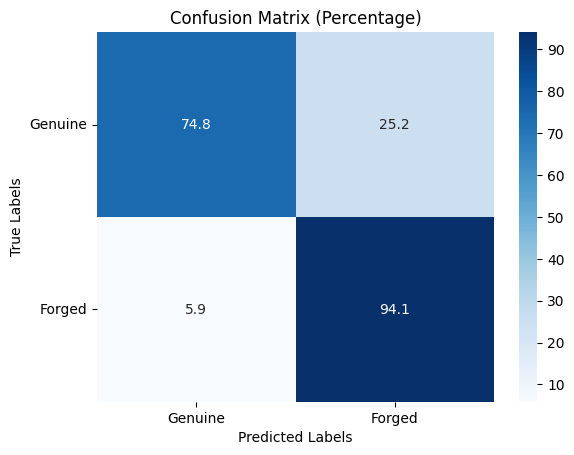

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       408
           1       0.78      0.94      0.85       392

    accuracy                           0.84       800
   macro avg       0.86      0.84      0.84       800
weighted avg       0.86      0.84      0.84       800



array([[305, 103],
       [ 23, 369]])

In [36]:
build_confusion_matrix(preds,labels)
print(classification_report(preds,labels))
confusion_matrix(preds,labels)

In [37]:
#@title Bengali Signature
folder = f'{handwritten_path}/BHSig260-Bengali/BHSig260-Bengali'
preds,labels = perform_voting_for_each_test_images(folder, handwritten_path)
confusion_matrix(preds,labels)

5it [00:01,  2.64it/s]


62	/BHSig260-Bengali/BHSig260-Bengali/62/B-S-62-F-30.tif	1	1


5it [00:01,  2.71it/s]


62	/BHSig260-Bengali/BHSig260-Bengali/62/B-S-62-F-23.tif	1	1


5it [00:01,  2.89it/s]


62	/BHSig260-Bengali/BHSig260-Bengali/62/B-S-62-F-29.tif	1	1


5it [00:01,  2.86it/s]


62	/BHSig260-Bengali/BHSig260-Bengali/62/B-S-62-G-18.tif	0	0


5it [00:01,  2.72it/s]


62	/BHSig260-Bengali/BHSig260-Bengali/62/B-S-62-F-03.tif	1	1


5it [00:01,  3.15it/s]


30	/BHSig260-Bengali/BHSig260-Bengali/30/B-S-30-G-23.tif	0	1


5it [00:01,  2.85it/s]


30	/BHSig260-Bengali/BHSig260-Bengali/30/B-S-30-F-17.tif	1	0


5it [00:01,  3.43it/s]


30	/BHSig260-Bengali/BHSig260-Bengali/30/B-S-30-G-08.tif	0	1


5it [00:01,  3.34it/s]


30	/BHSig260-Bengali/BHSig260-Bengali/30/B-S-30-G-06.tif	0	0


5it [00:01,  3.14it/s]


30	/BHSig260-Bengali/BHSig260-Bengali/30/B-S-30-F-28.tif	1	1


5it [00:01,  3.62it/s]


8	/BHSig260-Bengali/BHSig260-Bengali/8/B-S-8-F-14.tif	1	1


5it [00:01,  4.41it/s]


8	/BHSig260-Bengali/BHSig260-Bengali/8/B-S-8-G-07.tif	0	0


5it [00:01,  3.82it/s]


8	/BHSig260-Bengali/BHSig260-Bengali/8/B-S-8-F-28.tif	1	0


5it [00:01,  3.66it/s]


8	/BHSig260-Bengali/BHSig260-Bengali/8/B-S-8-F-10.tif	1	1


5it [00:01,  3.99it/s]


8	/BHSig260-Bengali/BHSig260-Bengali/8/B-S-8-F-20.tif	1	1


5it [00:01,  2.97it/s]


72	/BHSig260-Bengali/BHSig260-Bengali/72/B-S-72-G-11.tif	0	0


5it [00:01,  2.83it/s]


72	/BHSig260-Bengali/BHSig260-Bengali/72/B-S-72-G-04.tif	0	0


5it [00:01,  2.95it/s]


72	/BHSig260-Bengali/BHSig260-Bengali/72/B-S-72-F-14.tif	1	1


5it [00:01,  2.81it/s]


72	/BHSig260-Bengali/BHSig260-Bengali/72/B-S-72-G-21.tif	0	0


5it [00:01,  3.11it/s]


72	/BHSig260-Bengali/BHSig260-Bengali/72/B-S-72-F-24.tif	1	1


5it [00:02,  2.25it/s]


42	/BHSig260-Bengali/BHSig260-Bengali/42/B-S-42-G-07.tif	0	0


5it [00:02,  2.23it/s]


42	/BHSig260-Bengali/BHSig260-Bengali/42/B-S-42-G-16.tif	0	0


5it [00:02,  2.21it/s]


42	/BHSig260-Bengali/BHSig260-Bengali/42/B-S-42-G-10.tif	0	0


5it [00:02,  2.23it/s]


42	/BHSig260-Bengali/BHSig260-Bengali/42/B-S-42-F-17.tif	1	0


5it [00:02,  2.26it/s]


42	/BHSig260-Bengali/BHSig260-Bengali/42/B-S-42-F-04.tif	1	0


5it [00:01,  3.74it/s]


59	/BHSig260-Bengali/BHSig260-Bengali/59/B-S-59-F-26.tif	1	1


5it [00:01,  3.94it/s]


59	/BHSig260-Bengali/BHSig260-Bengali/59/B-S-59-G-01.tif	0	0


5it [00:01,  3.91it/s]


59	/BHSig260-Bengali/BHSig260-Bengali/59/B-S-59-F-28.tif	1	1


5it [00:01,  3.63it/s]


59	/BHSig260-Bengali/BHSig260-Bengali/59/B-S-59-F-23.tif	1	1


5it [00:01,  3.99it/s]


59	/BHSig260-Bengali/BHSig260-Bengali/59/B-S-59-G-19.tif	0	0


5it [00:01,  3.51it/s]


19	/BHSig260-Bengali/BHSig260-Bengali/19/B-S-19-F-02.tif	1	0


5it [00:01,  3.46it/s]


19	/BHSig260-Bengali/BHSig260-Bengali/19/B-S-19-F-22.tif	1	0


5it [00:01,  3.78it/s]


19	/BHSig260-Bengali/BHSig260-Bengali/19/B-S-19-G-19.tif	0	0


5it [00:01,  3.48it/s]


19	/BHSig260-Bengali/BHSig260-Bengali/19/B-S-19-G-09.tif	0	0


5it [00:01,  3.43it/s]


19	/BHSig260-Bengali/BHSig260-Bengali/19/B-S-19-F-25.tif	1	0


5it [00:01,  3.53it/s]


39	/BHSig260-Bengali/BHSig260-Bengali/39/B-S-39-F-30.tif	1	0


5it [00:01,  3.61it/s]


39	/BHSig260-Bengali/BHSig260-Bengali/39/B-S-39-F-05.tif	1	0


5it [00:01,  3.94it/s]


39	/BHSig260-Bengali/BHSig260-Bengali/39/B-S-39-G-17.tif	0	0


5it [00:01,  4.05it/s]


39	/BHSig260-Bengali/BHSig260-Bengali/39/B-S-39-F-19.tif	1	0


5it [00:01,  3.55it/s]


39	/BHSig260-Bengali/BHSig260-Bengali/39/B-S-39-F-11.tif	1	0


5it [00:00,  5.70it/s]


57	/BHSig260-Bengali/BHSig260-Bengali/57/B-S-57-G-09.tif	0	0


5it [00:00,  5.64it/s]


57	/BHSig260-Bengali/BHSig260-Bengali/57/B-S-57-F-01.tif	1	1


5it [00:00,  5.61it/s]


57	/BHSig260-Bengali/BHSig260-Bengali/57/B-S-57-F-16.tif	1	1


5it [00:00,  5.60it/s]


57	/BHSig260-Bengali/BHSig260-Bengali/57/B-S-57-F-09.tif	1	1


5it [00:00,  6.48it/s]


57	/BHSig260-Bengali/BHSig260-Bengali/57/B-S-57-G-17.tif	0	0


5it [00:01,  3.13it/s]


31	/BHSig260-Bengali/BHSig260-Bengali/31/B-S-31-F-05.tif	1	1


5it [00:01,  3.41it/s]


31	/BHSig260-Bengali/BHSig260-Bengali/31/B-S-31-G-06.tif	0	0


5it [00:01,  3.64it/s]


31	/BHSig260-Bengali/BHSig260-Bengali/31/B-S-31-G-10.tif	0	0


5it [00:01,  2.87it/s]


31	/BHSig260-Bengali/BHSig260-Bengali/31/B-S-31-F-16.tif	1	1


5it [00:01,  3.66it/s]


31	/BHSig260-Bengali/BHSig260-Bengali/31/B-S-31-G-07.tif	0	0


5it [00:01,  3.03it/s]


25	/BHSig260-Bengali/BHSig260-Bengali/25/B-S-25-G-14.tif	0	0


5it [00:01,  3.06it/s]


25	/BHSig260-Bengali/BHSig260-Bengali/25/B-S-25-G-20.tif	0	1


5it [00:01,  3.19it/s]


25	/BHSig260-Bengali/BHSig260-Bengali/25/B-S-25-G-09.tif	0	1


5it [00:01,  2.61it/s]


25	/BHSig260-Bengali/BHSig260-Bengali/25/B-S-25-F-20.tif	1	1


5it [00:01,  2.69it/s]


25	/BHSig260-Bengali/BHSig260-Bengali/25/B-S-25-F-15.tif	1	1


5it [00:01,  3.41it/s]


49	/BHSig260-Bengali/BHSig260-Bengali/49/B-S-49-G-06.tif	0	0


5it [00:01,  3.36it/s]


49	/BHSig260-Bengali/BHSig260-Bengali/49/B-S-49-G-21.tif	0	0


5it [00:01,  3.38it/s]


49	/BHSig260-Bengali/BHSig260-Bengali/49/B-S-49-G-03.tif	0	0


5it [00:01,  3.44it/s]


49	/BHSig260-Bengali/BHSig260-Bengali/49/B-S-49-G-05.tif	0	0


5it [00:01,  2.89it/s]


49	/BHSig260-Bengali/BHSig260-Bengali/49/B-S-49-F-05.tif	1	1


5it [00:02,  2.31it/s]


7	/BHSig260-Bengali/BHSig260-Bengali/7/B-S-7-G-15.tif	0	0


5it [00:01,  2.84it/s]


7	/BHSig260-Bengali/BHSig260-Bengali/7/B-S-7-F-19.tif	1	0


5it [00:01,  2.62it/s]


7	/BHSig260-Bengali/BHSig260-Bengali/7/B-S-7-F-12.tif	1	0


5it [00:01,  2.96it/s]


7	/BHSig260-Bengali/BHSig260-Bengali/7/B-S-7-G-09.tif	0	0


5it [00:01,  2.87it/s]


7	/BHSig260-Bengali/BHSig260-Bengali/7/B-S-7-G-08.tif	0	1


5it [00:01,  4.28it/s]


55	/BHSig260-Bengali/BHSig260-Bengali/55/B-S-55-G-17.tif	0	0


5it [00:01,  4.32it/s]


55	/BHSig260-Bengali/BHSig260-Bengali/55/B-S-55-G-16.tif	0	0


5it [00:01,  4.35it/s]


55	/BHSig260-Bengali/BHSig260-Bengali/55/B-S-55-F-02.tif	1	1


5it [00:01,  4.17it/s]


55	/BHSig260-Bengali/BHSig260-Bengali/55/B-S-55-G-12.tif	0	0


5it [00:01,  4.31it/s]


55	/BHSig260-Bengali/BHSig260-Bengali/55/B-S-55-F-24.tif	1	1


5it [00:01,  3.91it/s]


75	/BHSig260-Bengali/BHSig260-Bengali/75/B-S-75-G-03.tif	0	0


5it [00:01,  4.51it/s]


75	/BHSig260-Bengali/BHSig260-Bengali/75/B-S-75-G-18.tif	0	0


5it [00:01,  3.92it/s]


75	/BHSig260-Bengali/BHSig260-Bengali/75/B-S-75-F-20.tif	1	1


5it [00:01,  3.76it/s]


75	/BHSig260-Bengali/BHSig260-Bengali/75/B-S-75-F-07.tif	1	1


5it [00:01,  4.44it/s]


75	/BHSig260-Bengali/BHSig260-Bengali/75/B-S-75-F-25.tif	1	1


5it [00:00,  5.05it/s]


14	/BHSig260-Bengali/BHSig260-Bengali/14/B-S-14-F-23.tif	1	1


5it [00:00,  5.55it/s]


14	/BHSig260-Bengali/BHSig260-Bengali/14/B-S-14-G-10.tif	0	0


5it [00:01,  4.87it/s]


14	/BHSig260-Bengali/BHSig260-Bengali/14/B-S-14-F-12.tif	1	1


5it [00:00,  5.01it/s]


14	/BHSig260-Bengali/BHSig260-Bengali/14/B-S-14-G-22.tif	0	0


5it [00:00,  5.22it/s]


14	/BHSig260-Bengali/BHSig260-Bengali/14/B-S-14-F-02.tif	1	1


5it [00:01,  3.13it/s]


93	/BHSig260-Bengali/BHSig260-Bengali/93/B-S-93-F-22.tif	1	1


5it [00:01,  3.07it/s]


93	/BHSig260-Bengali/BHSig260-Bengali/93/B-S-93-F-14.tif	1	1


5it [00:01,  3.21it/s]


93	/BHSig260-Bengali/BHSig260-Bengali/93/B-S-93-G-01.tif	0	0


5it [00:01,  2.83it/s]


93	/BHSig260-Bengali/BHSig260-Bengali/93/B-S-93-G-23.tif	0	0


5it [00:01,  2.91it/s]


93	/BHSig260-Bengali/BHSig260-Bengali/93/B-S-93-F-29.tif	1	1


5it [00:01,  3.82it/s]


67	/BHSig260-Bengali/BHSig260-Bengali/67/B-S-67-F-10.tif	1	1


5it [00:01,  3.71it/s]


67	/BHSig260-Bengali/BHSig260-Bengali/67/B-S-67-G-21.tif	0	0


5it [00:01,  3.81it/s]


67	/BHSig260-Bengali/BHSig260-Bengali/67/B-S-67-F-18.tif	1	1


5it [00:01,  3.97it/s]


67	/BHSig260-Bengali/BHSig260-Bengali/67/B-S-67-F-02.tif	1	1


5it [00:01,  3.99it/s]


67	/BHSig260-Bengali/BHSig260-Bengali/67/B-S-67-F-19.tif	1	1


5it [00:01,  3.56it/s]


9	/BHSig260-Bengali/BHSig260-Bengali/9/B-S-9-F-21.tif	1	1


5it [00:01,  3.32it/s]


9	/BHSig260-Bengali/BHSig260-Bengali/9/B-S-9-F-16.tif	1	1


5it [00:01,  3.22it/s]


9	/BHSig260-Bengali/BHSig260-Bengali/9/B-S-9-F-19.tif	1	1


5it [00:01,  4.25it/s]


9	/BHSig260-Bengali/BHSig260-Bengali/9/B-S-9-G-16.tif	0	0


5it [00:01,  3.33it/s]


9	/BHSig260-Bengali/BHSig260-Bengali/9/B-S-9-F-25.tif	1	1


5it [00:01,  2.86it/s]


3	/BHSig260-Bengali/BHSig260-Bengali/3/B-S-3-F-24.tif	1	1


5it [00:01,  2.78it/s]


3	/BHSig260-Bengali/BHSig260-Bengali/3/B-S-3-F-09.tif	1	1


5it [00:01,  2.83it/s]


3	/BHSig260-Bengali/BHSig260-Bengali/3/B-S-3-F-12.tif	1	1


5it [00:01,  2.75it/s]


3	/BHSig260-Bengali/BHSig260-Bengali/3/B-S-3-G-20.tif	0	0


5it [00:01,  2.72it/s]


3	/BHSig260-Bengali/BHSig260-Bengali/3/B-S-3-F-04.tif	1	1


5it [00:01,  3.65it/s]


33	/BHSig260-Bengali/BHSig260-Bengali/33/B-S-33-F-30.tif	1	1


5it [00:01,  3.47it/s]


33	/BHSig260-Bengali/BHSig260-Bengali/33/B-S-33-F-03.tif	1	1


5it [00:01,  3.52it/s]


33	/BHSig260-Bengali/BHSig260-Bengali/33/B-S-33-G-10.tif	0	0


5it [00:01,  3.83it/s]


33	/BHSig260-Bengali/BHSig260-Bengali/33/B-S-33-G-21.tif	0	0


5it [00:01,  3.58it/s]


33	/BHSig260-Bengali/BHSig260-Bengali/33/B-S-33-G-06.tif	0	1


5it [00:01,  2.85it/s]


37	/BHSig260-Bengali/BHSig260-Bengali/37/B-S-37-G-20.tif	0	0


5it [00:01,  2.95it/s]


37	/BHSig260-Bengali/BHSig260-Bengali/37/B-S-37-F-13.tif	1	0


5it [00:01,  2.78it/s]


37	/BHSig260-Bengali/BHSig260-Bengali/37/B-S-37-F-28.tif	1	0


5it [00:01,  2.74it/s]


37	/BHSig260-Bengali/BHSig260-Bengali/37/B-S-37-G-14.tif	0	0


5it [00:01,  2.71it/s]


37	/BHSig260-Bengali/BHSig260-Bengali/37/B-S-37-G-02.tif	0	0


5it [00:01,  3.40it/s]


50	/BHSig260-Bengali/BHSig260-Bengali/50/B-S-50-F-17.tif	1	1


5it [00:01,  3.50it/s]


50	/BHSig260-Bengali/BHSig260-Bengali/50/B-S-50-F-08.tif	1	1


5it [00:01,  3.41it/s]


50	/BHSig260-Bengali/BHSig260-Bengali/50/B-S-50-G-24.tif	0	0


5it [00:01,  3.32it/s]


50	/BHSig260-Bengali/BHSig260-Bengali/50/B-S-50-G-23.tif	0	0


5it [00:01,  3.41it/s]


50	/BHSig260-Bengali/BHSig260-Bengali/50/B-S-50-F-15.tif	1	0


5it [00:01,  4.69it/s]


46	/BHSig260-Bengali/BHSig260-Bengali/46/B-S-46-G-24.tif	0	0


5it [00:01,  3.66it/s]


46	/BHSig260-Bengali/BHSig260-Bengali/46/B-S-46-F-23.tif	1	1


5it [00:01,  3.56it/s]


46	/BHSig260-Bengali/BHSig260-Bengali/46/B-S-46-F-03.tif	1	1


5it [00:01,  3.80it/s]


46	/BHSig260-Bengali/BHSig260-Bengali/46/B-S-46-F-02.tif	1	1


5it [00:01,  4.97it/s]


46	/BHSig260-Bengali/BHSig260-Bengali/46/B-S-46-G-08.tif	0	0


5it [00:01,  2.69it/s]


63	/BHSig260-Bengali/BHSig260-Bengali/63/B-S-63-F-15.tif	1	1


5it [00:01,  2.77it/s]


63	/BHSig260-Bengali/BHSig260-Bengali/63/B-S-63-G-14.tif	0	0


5it [00:01,  2.66it/s]


63	/BHSig260-Bengali/BHSig260-Bengali/63/B-S-63-F-30.tif	1	1


5it [00:01,  2.81it/s]


63	/BHSig260-Bengali/BHSig260-Bengali/63/B-S-63-G-02.tif	0	0


5it [00:01,  2.80it/s]


63	/BHSig260-Bengali/BHSig260-Bengali/63/B-S-63-G-19.tif	0	0


5it [00:01,  3.50it/s]


96	/BHSig260-Bengali/BHSig260-Bengali/96/B-S-96-F-11.tif	1	1


5it [00:01,  4.54it/s]


96	/BHSig260-Bengali/BHSig260-Bengali/96/B-S-96-G-15.tif	0	0


5it [00:01,  4.18it/s]


96	/BHSig260-Bengali/BHSig260-Bengali/96/B-S-96-G-12.tif	0	0


5it [00:01,  3.61it/s]


96	/BHSig260-Bengali/BHSig260-Bengali/96/B-S-96-F-07.tif	1	1


5it [00:01,  4.69it/s]


96	/BHSig260-Bengali/BHSig260-Bengali/96/B-S-96-G-17.tif	0	0


5it [00:01,  4.45it/s]


65	/BHSig260-Bengali/BHSig260-Bengali/65/B-S-65-F-05.tif	1	1


5it [00:00,  5.20it/s]


65	/BHSig260-Bengali/BHSig260-Bengali/65/B-S-65-G-06.tif	0	0


5it [00:01,  4.41it/s]


65	/BHSig260-Bengali/BHSig260-Bengali/65/B-S-65-F-18.tif	1	1


5it [00:01,  4.32it/s]


65	/BHSig260-Bengali/BHSig260-Bengali/65/B-S-65-F-27.tif	1	1


5it [00:00,  5.05it/s]


65	/BHSig260-Bengali/BHSig260-Bengali/65/B-S-65-G-09.tif	0	0


5it [00:01,  3.01it/s]


80	/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-G-17.tif	0	0


5it [00:01,  3.14it/s]


80	/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-G-21.tif	0	0


5it [00:01,  3.09it/s]


80	/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-F-14.tif	1	1


5it [00:01,  3.16it/s]


80	/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-F-17.tif	1	1


5it [00:01,  3.07it/s]


80	/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-F-04.tif	1	1


5it [00:01,  3.16it/s]


24	/BHSig260-Bengali/BHSig260-Bengali/24/B-S-24-F-30.tif	1	1


5it [00:01,  3.04it/s]


24	/BHSig260-Bengali/BHSig260-Bengali/24/B-S-24-F-28.tif	1	1


5it [00:01,  3.50it/s]


24	/BHSig260-Bengali/BHSig260-Bengali/24/B-S-24-G-13.tif	0	0


5it [00:01,  3.26it/s]


24	/BHSig260-Bengali/BHSig260-Bengali/24/B-S-24-G-15.tif	0	0


5it [00:01,  3.28it/s]


24	/BHSig260-Bengali/BHSig260-Bengali/24/B-S-24-F-09.tif	1	0


5it [00:01,  2.75it/s]


38	/BHSig260-Bengali/BHSig260-Bengali/38/B-S-38-G-01.tif	0	0


5it [00:01,  3.30it/s]


38	/BHSig260-Bengali/BHSig260-Bengali/38/B-S-38-F-01.tif	1	1


5it [00:01,  3.32it/s]


38	/BHSig260-Bengali/BHSig260-Bengali/38/B-S-38-F-27.tif	1	1


5it [00:01,  2.85it/s]


38	/BHSig260-Bengali/BHSig260-Bengali/38/B-S-38-G-16.tif	0	0


5it [00:01,  3.19it/s]


38	/BHSig260-Bengali/BHSig260-Bengali/38/B-S-38-G-03.tif	0	0


5it [00:01,  4.20it/s]


94	/BHSig260-Bengali/BHSig260-Bengali/94/B-S-94-F-16.tif	1	1


5it [00:01,  4.17it/s]


94	/BHSig260-Bengali/BHSig260-Bengali/94/B-S-94-G-14.tif	0	0


5it [00:01,  4.34it/s]


94	/BHSig260-Bengali/BHSig260-Bengali/94/B-S-94-F-02.tif	1	1


5it [00:01,  4.42it/s]


94	/BHSig260-Bengali/BHSig260-Bengali/94/B-S-94-G-18.tif	0	0


5it [00:01,  4.36it/s]


94	/BHSig260-Bengali/BHSig260-Bengali/94/B-S-94-G-01.tif	0	0


5it [00:01,  3.33it/s]


5	/BHSig260-Bengali/BHSig260-Bengali/5/B-S-5-F-13.tif	1	0


5it [00:01,  3.09it/s]


5	/BHSig260-Bengali/BHSig260-Bengali/5/B-S-5-F-29.tif	1	0


5it [00:01,  3.14it/s]


5	/BHSig260-Bengali/BHSig260-Bengali/5/B-S-5-F-15.tif	1	0


5it [00:01,  2.86it/s]


5	/BHSig260-Bengali/BHSig260-Bengali/5/B-S-5-G-04.tif	0	0


5it [00:01,  2.89it/s]


5	/BHSig260-Bengali/BHSig260-Bengali/5/B-S-5-G-18.tif	0	0


5it [00:00,  5.32it/s]


21	/BHSig260-Bengali/BHSig260-Bengali/21/B-S-21-F-29.tif	1	0


5it [00:00,  5.57it/s]


21	/BHSig260-Bengali/BHSig260-Bengali/21/B-S-21-G-20.tif	0	1


5it [00:00,  5.30it/s]


21	/BHSig260-Bengali/BHSig260-Bengali/21/B-S-21-G-02.tif	0	1


5it [00:00,  5.68it/s]


21	/BHSig260-Bengali/BHSig260-Bengali/21/B-S-21-G-16.tif	0	0


5it [00:00,  5.29it/s]


21	/BHSig260-Bengali/BHSig260-Bengali/21/B-S-21-F-04.tif	1	1


5it [00:01,  2.58it/s]


69	/BHSig260-Bengali/BHSig260-Bengali/69/B-S-69-G-06.tif	0	0


5it [00:01,  2.63it/s]


69	/BHSig260-Bengali/BHSig260-Bengali/69/B-S-69-F-08.tif	1	1


5it [00:01,  2.51it/s]


69	/BHSig260-Bengali/BHSig260-Bengali/69/B-S-69-G-14.tif	0	1


5it [00:01,  2.64it/s]


69	/BHSig260-Bengali/BHSig260-Bengali/69/B-S-69-G-01.tif	0	0


5it [00:02,  2.31it/s]


69	/BHSig260-Bengali/BHSig260-Bengali/69/B-S-69-G-23.tif	0	0


5it [00:01,  3.33it/s]


92	/BHSig260-Bengali/BHSig260-Bengali/92/B-S-92-G-18.tif	0	0


5it [00:01,  3.77it/s]


92	/BHSig260-Bengali/BHSig260-Bengali/92/B-S-92-F-27.tif	1	1


5it [00:01,  3.69it/s]


92	/BHSig260-Bengali/BHSig260-Bengali/92/B-S-92-F-12.tif	1	1


5it [00:01,  3.70it/s]


92	/BHSig260-Bengali/BHSig260-Bengali/92/B-S-92-G-17.tif	0	0


5it [00:01,  3.46it/s]


92	/BHSig260-Bengali/BHSig260-Bengali/92/B-S-92-F-28.tif	1	1


5it [00:01,  4.11it/s]


17	/BHSig260-Bengali/BHSig260-Bengali/17/B-S-17-F-11.tif	1	1


5it [00:01,  4.69it/s]


17	/BHSig260-Bengali/BHSig260-Bengali/17/B-S-17-G-11.tif	0	0


5it [00:01,  4.22it/s]


17	/BHSig260-Bengali/BHSig260-Bengali/17/B-S-17-F-16.tif	1	1


5it [00:01,  4.54it/s]


17	/BHSig260-Bengali/BHSig260-Bengali/17/B-S-17-G-19.tif	0	1


5it [00:01,  4.51it/s]


17	/BHSig260-Bengali/BHSig260-Bengali/17/B-S-17-F-02.tif	1	1


5it [00:01,  3.95it/s]


77	/BHSig260-Bengali/BHSig260-Bengali/77/B-S-77-G-13.tif	0	0


5it [00:01,  3.96it/s]


77	/BHSig260-Bengali/BHSig260-Bengali/77/B-S-77-G-14.tif	0	0


5it [00:01,  3.70it/s]


77	/BHSig260-Bengali/BHSig260-Bengali/77/B-S-77-G-09.tif	0	0


5it [00:01,  3.88it/s]


77	/BHSig260-Bengali/BHSig260-Bengali/77/B-S-77-F-29.tif	1	1


5it [00:01,  3.73it/s]


77	/BHSig260-Bengali/BHSig260-Bengali/77/B-S-77-F-25.tif	1	1


5it [00:01,  4.12it/s]


12	/BHSig260-Bengali/BHSig260-Bengali/12/B-S-12-G-18.tif	0	0


5it [00:01,  3.69it/s]


12	/BHSig260-Bengali/BHSig260-Bengali/12/B-S-12-G-10.tif	0	0


5it [00:01,  3.32it/s]


12	/BHSig260-Bengali/BHSig260-Bengali/12/B-S-12-F-27.tif	1	1


5it [00:01,  3.34it/s]


12	/BHSig260-Bengali/BHSig260-Bengali/12/B-S-12-F-04.tif	1	1


5it [00:01,  3.23it/s]


12	/BHSig260-Bengali/BHSig260-Bengali/12/B-S-12-F-15.tif	1	1


5it [00:01,  3.35it/s]


58	/BHSig260-Bengali/BHSig260-Bengali/58/B-S-58-F-24.tif	1	1


5it [00:01,  3.50it/s]


58	/BHSig260-Bengali/BHSig260-Bengali/58/B-S-58-F-26.tif	1	1


5it [00:01,  3.61it/s]


58	/BHSig260-Bengali/BHSig260-Bengali/58/B-S-58-F-04.tif	1	1


5it [00:01,  3.47it/s]


58	/BHSig260-Bengali/BHSig260-Bengali/58/B-S-58-F-14.tif	1	1


5it [00:01,  3.53it/s]


58	/BHSig260-Bengali/BHSig260-Bengali/58/B-S-58-F-10.tif	1	1


5it [00:01,  4.78it/s]


95	/BHSig260-Bengali/BHSig260-Bengali/95/B-S-95-G-22.tif	0	0


5it [00:01,  4.60it/s]


95	/BHSig260-Bengali/BHSig260-Bengali/95/B-S-95-G-17.tif	0	0


5it [00:01,  4.11it/s]


95	/BHSig260-Bengali/BHSig260-Bengali/95/B-S-95-F-11.tif	1	1


5it [00:01,  4.78it/s]


95	/BHSig260-Bengali/BHSig260-Bengali/95/B-S-95-G-16.tif	0	0


5it [00:01,  4.17it/s]


95	/BHSig260-Bengali/BHSig260-Bengali/95/B-S-95-F-30.tif	1	1


5it [00:01,  3.56it/s]


98	/BHSig260-Bengali/BHSig260-Bengali/98/B-S-98-G-03.tif	0	0


5it [00:01,  3.37it/s]


98	/BHSig260-Bengali/BHSig260-Bengali/98/B-S-98-G-24.tif	0	0


5it [00:01,  3.48it/s]


98	/BHSig260-Bengali/BHSig260-Bengali/98/B-S-98-G-23.tif	0	0


5it [00:01,  4.05it/s]


98	/BHSig260-Bengali/BHSig260-Bengali/98/B-S-98-F-05.tif	1	1


5it [00:01,  3.78it/s]


98	/BHSig260-Bengali/BHSig260-Bengali/98/B-S-98-F-17.tif	1	1


5it [00:01,  4.00it/s]


90	/BHSig260-Bengali/BHSig260-Bengali/90/B-S-90-G-09.tif	0	0


5it [00:01,  3.64it/s]


90	/BHSig260-Bengali/BHSig260-Bengali/90/B-S-90-F-05.tif	1	1


5it [00:01,  3.18it/s]


90	/BHSig260-Bengali/BHSig260-Bengali/90/B-S-90-F-24.tif	1	1


5it [00:01,  4.00it/s]


90	/BHSig260-Bengali/BHSig260-Bengali/90/B-S-90-G-16.tif	0	0


5it [00:01,  3.50it/s]


90	/BHSig260-Bengali/BHSig260-Bengali/90/B-S-90-F-09.tif	1	1


5it [00:01,  3.72it/s]


70	/BHSig260-Bengali/BHSig260-Bengali/70/B-S-70-G-23.tif	0	0


5it [00:01,  3.92it/s]


70	/BHSig260-Bengali/BHSig260-Bengali/70/B-S-70-F-20.tif	1	1


5it [00:01,  3.68it/s]


70	/BHSig260-Bengali/BHSig260-Bengali/70/B-S-70-G-22.tif	0	0


5it [00:01,  4.08it/s]


70	/BHSig260-Bengali/BHSig260-Bengali/70/B-S-70-F-17.tif	1	1


5it [00:01,  3.63it/s]


70	/BHSig260-Bengali/BHSig260-Bengali/70/B-S-70-F-02.tif	1	1


5it [00:00,  5.41it/s]


45	/BHSig260-Bengali/BHSig260-Bengali/45/B-S-45-G-13.tif	0	0


5it [00:00,  5.18it/s]


45	/BHSig260-Bengali/BHSig260-Bengali/45/B-S-45-G-02.tif	0	0


5it [00:00,  5.10it/s]


45	/BHSig260-Bengali/BHSig260-Bengali/45/B-S-45-F-20.tif	1	1


5it [00:00,  5.19it/s]


45	/BHSig260-Bengali/BHSig260-Bengali/45/B-S-45-F-09.tif	1	0


5it [00:00,  5.37it/s]


45	/BHSig260-Bengali/BHSig260-Bengali/45/B-S-45-G-20.tif	0	0


5it [00:01,  4.41it/s]


81	/BHSig260-Bengali/BHSig260-Bengali/81/B-S-81-G-10.tif	0	0


5it [00:01,  4.37it/s]


81	/BHSig260-Bengali/BHSig260-Bengali/81/B-S-81-G-06.tif	0	0


5it [00:01,  4.50it/s]


81	/BHSig260-Bengali/BHSig260-Bengali/81/B-S-81-G-11.tif	0	0


5it [00:01,  4.72it/s]


81	/BHSig260-Bengali/BHSig260-Bengali/81/B-S-81-F-07.tif	1	1


5it [00:01,  4.60it/s]


81	/BHSig260-Bengali/BHSig260-Bengali/81/B-S-81-G-22.tif	0	0


5it [00:01,  4.88it/s]


66	/BHSig260-Bengali/BHSig260-Bengali/66/B-S-66-F-08.tif	1	1


5it [00:00,  5.11it/s]


66	/BHSig260-Bengali/BHSig260-Bengali/66/B-S-66-G-10.tif	0	0


5it [00:01,  4.57it/s]


66	/BHSig260-Bengali/BHSig260-Bengali/66/B-S-66-F-25.tif	1	1


5it [00:01,  4.86it/s]


66	/BHSig260-Bengali/BHSig260-Bengali/66/B-S-66-F-23.tif	1	1


5it [00:00,  5.29it/s]


66	/BHSig260-Bengali/BHSig260-Bengali/66/B-S-66-G-03.tif	0	0


5it [00:01,  3.03it/s]


44	/BHSig260-Bengali/BHSig260-Bengali/44/B-S-44-G-17.tif	0	0


5it [00:01,  3.87it/s]


44	/BHSig260-Bengali/BHSig260-Bengali/44/B-S-44-F-08.tif	1	0


5it [00:01,  3.94it/s]


44	/BHSig260-Bengali/BHSig260-Bengali/44/B-S-44-F-27.tif	1	0


5it [00:01,  4.05it/s]


44	/BHSig260-Bengali/BHSig260-Bengali/44/B-S-44-F-26.tif	1	1


5it [00:01,  3.86it/s]


44	/BHSig260-Bengali/BHSig260-Bengali/44/B-S-44-F-15.tif	1	1


5it [00:01,  3.32it/s]


79	/BHSig260-Bengali/BHSig260-Bengali/79/B-S-79-F-29.tif	1	1


5it [00:01,  3.43it/s]


79	/BHSig260-Bengali/BHSig260-Bengali/79/B-S-79-G-05.tif	0	0


5it [00:01,  3.44it/s]


79	/BHSig260-Bengali/BHSig260-Bengali/79/B-S-79-F-01.tif	1	1


5it [00:01,  3.27it/s]


79	/BHSig260-Bengali/BHSig260-Bengali/79/B-S-79-F-24.tif	1	1


5it [00:01,  3.25it/s]


79	/BHSig260-Bengali/BHSig260-Bengali/79/B-S-79-G-12.tif	0	0


5it [00:01,  3.53it/s]


47	/BHSig260-Bengali/BHSig260-Bengali/47/B-S-47-F-27.tif	1	0


5it [00:01,  3.77it/s]


47	/BHSig260-Bengali/BHSig260-Bengali/47/B-S-47-F-01.tif	1	1


5it [00:01,  3.14it/s]


47	/BHSig260-Bengali/BHSig260-Bengali/47/B-S-47-G-18.tif	0	0


5it [00:01,  3.62it/s]


47	/BHSig260-Bengali/BHSig260-Bengali/47/B-S-47-F-21.tif	1	1


5it [00:01,  3.24it/s]


47	/BHSig260-Bengali/BHSig260-Bengali/47/B-S-47-G-19.tif	0	0


5it [00:01,  4.43it/s]


91	/BHSig260-Bengali/BHSig260-Bengali/91/B-S-91-G-22.tif	0	0


5it [00:01,  4.29it/s]


91	/BHSig260-Bengali/BHSig260-Bengali/91/B-S-91-F-09.tif	1	1


5it [00:01,  4.31it/s]


91	/BHSig260-Bengali/BHSig260-Bengali/91/B-S-91-F-11.tif	1	1


5it [00:01,  4.78it/s]


91	/BHSig260-Bengali/BHSig260-Bengali/91/B-S-91-G-10.tif	0	0


5it [00:01,  4.14it/s]


91	/BHSig260-Bengali/BHSig260-Bengali/91/B-S-91-F-18.tif	1	1


5it [00:01,  3.46it/s]


53	/BHSig260-Bengali/BHSig260-Bengali/53/B-S-53-F-26.tif	1	1


5it [00:01,  3.53it/s]


53	/BHSig260-Bengali/BHSig260-Bengali/53/B-S-53-F-29.tif	1	1


5it [00:01,  3.48it/s]


53	/BHSig260-Bengali/BHSig260-Bengali/53/B-S-53-F-21.tif	1	1


5it [00:01,  3.19it/s]


53	/BHSig260-Bengali/BHSig260-Bengali/53/B-S-53-G-19.tif	0	0


5it [00:01,  3.20it/s]


53	/BHSig260-Bengali/BHSig260-Bengali/53/B-S-53-G-08.tif	0	0


5it [00:00,  5.66it/s]


76	/BHSig260-Bengali/BHSig260-Bengali/76/B-S-76-G-03.tif	0	0


5it [00:00,  5.55it/s]


76	/BHSig260-Bengali/BHSig260-Bengali/76/B-S-76-G-10.tif	0	0


5it [00:00,  5.16it/s]


76	/BHSig260-Bengali/BHSig260-Bengali/76/B-S-76-G-20.tif	0	0


5it [00:00,  5.44it/s]


76	/BHSig260-Bengali/BHSig260-Bengali/76/B-S-76-G-16.tif	0	0


5it [00:00,  5.24it/s]


76	/BHSig260-Bengali/BHSig260-Bengali/76/B-S-76-G-09.tif	0	0


5it [00:01,  3.70it/s]


22	/BHSig260-Bengali/BHSig260-Bengali/22/B-S-22-F-13.tif	1	1


5it [00:01,  3.33it/s]


22	/BHSig260-Bengali/BHSig260-Bengali/22/B-S-22-F-26.tif	1	1


5it [00:01,  3.58it/s]


22	/BHSig260-Bengali/BHSig260-Bengali/22/B-S-22-F-09.tif	1	1


5it [00:01,  3.54it/s]


22	/BHSig260-Bengali/BHSig260-Bengali/22/B-S-22-F-03.tif	1	1


5it [00:01,  3.84it/s]


22	/BHSig260-Bengali/BHSig260-Bengali/22/B-S-22-F-04.tif	1	1


5it [00:01,  4.03it/s]


40	/BHSig260-Bengali/BHSig260-Bengali/40/B-S-40-G-10.tif	0	0


5it [00:01,  3.92it/s]


40	/BHSig260-Bengali/BHSig260-Bengali/40/B-S-40-F-30.tif	1	1


5it [00:01,  3.85it/s]


40	/BHSig260-Bengali/BHSig260-Bengali/40/B-S-40-G-05.tif	0	1


5it [00:01,  3.83it/s]


40	/BHSig260-Bengali/BHSig260-Bengali/40/B-S-40-F-28.tif	1	1


5it [00:01,  3.62it/s]


40	/BHSig260-Bengali/BHSig260-Bengali/40/B-S-40-F-07.tif	1	0


5it [00:01,  3.69it/s]


28	/BHSig260-Bengali/BHSig260-Bengali/28/B-S-28-F-05.tif	1	0


5it [00:01,  3.69it/s]


28	/BHSig260-Bengali/BHSig260-Bengali/28/B-S-28-F-06.tif	1	0


5it [00:01,  3.73it/s]


28	/BHSig260-Bengali/BHSig260-Bengali/28/B-S-28-G-24.tif	0	0


5it [00:01,  3.59it/s]


28	/BHSig260-Bengali/BHSig260-Bengali/28/B-S-28-F-03.tif	1	0


5it [00:01,  3.76it/s]


28	/BHSig260-Bengali/BHSig260-Bengali/28/B-S-28-G-21.tif	0	0


5it [00:01,  2.99it/s]


6	/BHSig260-Bengali/BHSig260-Bengali/6/B-S-6-F-06.tif	1	0


5it [00:01,  3.17it/s]


6	/BHSig260-Bengali/BHSig260-Bengali/6/B-S-6-F-15.tif	1	0


5it [00:01,  3.21it/s]


6	/BHSig260-Bengali/BHSig260-Bengali/6/B-S-6-F-07.tif	1	1


5it [00:01,  3.06it/s]


6	/BHSig260-Bengali/BHSig260-Bengali/6/B-S-6-F-22.tif	1	0


5it [00:01,  3.03it/s]


6	/BHSig260-Bengali/BHSig260-Bengali/6/B-S-6-G-22.tif	0	0


5it [00:00,  5.26it/s]


87	/BHSig260-Bengali/BHSig260-Bengali/87/B-S-87-G-15.tif	0	0


5it [00:01,  4.04it/s]


87	/BHSig260-Bengali/BHSig260-Bengali/87/B-S-87-F-11.tif	1	1


5it [00:01,  4.80it/s]


87	/BHSig260-Bengali/BHSig260-Bengali/87/B-S-87-F-06.tif	1	1


5it [00:00,  5.11it/s]


87	/BHSig260-Bengali/BHSig260-Bengali/87/B-S-87-G-10.tif	0	0


5it [00:01,  4.51it/s]


87	/BHSig260-Bengali/BHSig260-Bengali/87/B-S-87-F-27.tif	1	1


5it [00:01,  3.18it/s]


34	/BHSig260-Bengali/BHSig260-Bengali/34/B-S-34-F-23.tif	1	0


5it [00:01,  3.28it/s]


34	/BHSig260-Bengali/BHSig260-Bengali/34/B-S-34-G-02.tif	0	0


5it [00:01,  2.90it/s]


34	/BHSig260-Bengali/BHSig260-Bengali/34/B-S-34-G-24.tif	0	0


5it [00:01,  3.15it/s]


34	/BHSig260-Bengali/BHSig260-Bengali/34/B-S-34-G-13.tif	0	0


5it [00:01,  3.12it/s]


34	/BHSig260-Bengali/BHSig260-Bengali/34/B-S-34-F-26.tif	1	0


5it [00:01,  4.75it/s]


48	/BHSig260-Bengali/BHSig260-Bengali/48/B-S-48-F-16.tif	1	1


5it [00:00,  5.21it/s]


48	/BHSig260-Bengali/BHSig260-Bengali/48/B-S-48-G-07.tif	0	0


5it [00:00,  5.20it/s]


48	/BHSig260-Bengali/BHSig260-Bengali/48/B-S-48-G-23.tif	0	0


5it [00:01,  4.82it/s]


48	/BHSig260-Bengali/BHSig260-Bengali/48/B-S-48-F-13.tif	1	1


5it [00:00,  5.13it/s]


48	/BHSig260-Bengali/BHSig260-Bengali/48/B-S-48-G-05.tif	0	0


5it [00:01,  4.28it/s]


100	/BHSig260-Bengali/BHSig260-Bengali/100/B-S-100-G-17.tif	0	0


5it [00:01,  4.53it/s]


100	/BHSig260-Bengali/BHSig260-Bengali/100/B-S-100-F-28.tif	1	1


5it [00:01,  4.34it/s]


100	/BHSig260-Bengali/BHSig260-Bengali/100/B-S-100-F-27.tif	1	1


5it [00:01,  4.23it/s]


100	/BHSig260-Bengali/BHSig260-Bengali/100/B-S-100-G-07.tif	0	0


5it [00:01,  4.03it/s]


100	/BHSig260-Bengali/BHSig260-Bengali/100/B-S-100-F-23.tif	1	1


5it [00:00,  5.09it/s]


20	/BHSig260-Bengali/BHSig260-Bengali/20/B-S-20-G-01.tif	0	0


5it [00:01,  3.86it/s]


20	/BHSig260-Bengali/BHSig260-Bengali/20/B-S-20-F-02.tif	1	1


5it [00:01,  4.59it/s]


20	/BHSig260-Bengali/BHSig260-Bengali/20/B-S-20-G-20.tif	0	0


5it [00:01,  4.36it/s]


20	/BHSig260-Bengali/BHSig260-Bengali/20/B-S-20-F-14.tif	1	1


5it [00:00,  5.08it/s]


20	/BHSig260-Bengali/BHSig260-Bengali/20/B-S-20-G-10.tif	0	0


5it [00:01,  4.67it/s]


23	/BHSig260-Bengali/BHSig260-Bengali/23/B-S-23-F-22.tif	1	1


5it [00:01,  4.86it/s]


23	/BHSig260-Bengali/BHSig260-Bengali/23/B-S-23-F-26.tif	1	1


5it [00:01,  4.15it/s]


23	/BHSig260-Bengali/BHSig260-Bengali/23/B-S-23-G-13.tif	0	1


5it [00:01,  4.49it/s]


23	/BHSig260-Bengali/BHSig260-Bengali/23/B-S-23-F-24.tif	1	1


5it [00:01,  3.88it/s]


23	/BHSig260-Bengali/BHSig260-Bengali/23/B-S-23-G-24.tif	0	0


5it [00:01,  2.96it/s]


27	/BHSig260-Bengali/BHSig260-Bengali/27/B-S-27-F-17.tif	1	0


5it [00:01,  3.00it/s]


27	/BHSig260-Bengali/BHSig260-Bengali/27/B-S-27-G-09.tif	0	0


5it [00:01,  2.82it/s]


27	/BHSig260-Bengali/BHSig260-Bengali/27/B-S-27-F-23.tif	1	0


5it [00:01,  2.80it/s]


27	/BHSig260-Bengali/BHSig260-Bengali/27/B-S-27-F-19.tif	1	1


5it [00:01,  2.88it/s]


27	/BHSig260-Bengali/BHSig260-Bengali/27/B-S-27-F-24.tif	1	0


5it [00:02,  2.35it/s]


32	/BHSig260-Bengali/BHSig260-Bengali/32/B-S-32-F-16.tif	1	1


5it [00:01,  2.90it/s]


32	/BHSig260-Bengali/BHSig260-Bengali/32/B-S-32-G-13.tif	0	0


5it [00:01,  2.90it/s]


32	/BHSig260-Bengali/BHSig260-Bengali/32/B-S-32-F-11.tif	1	0


5it [00:01,  2.79it/s]


32	/BHSig260-Bengali/BHSig260-Bengali/32/B-S-32-F-22.tif	1	1


5it [00:01,  2.73it/s]


32	/BHSig260-Bengali/BHSig260-Bengali/32/B-S-32-G-07.tif	0	0


5it [00:01,  4.10it/s]


73	/BHSig260-Bengali/BHSig260-Bengali/73/B-S-73-F-01.tif	1	1


5it [00:01,  4.39it/s]


73	/BHSig260-Bengali/BHSig260-Bengali/73/B-S-73-F-17.tif	1	1


5it [00:01,  4.40it/s]


73	/BHSig260-Bengali/BHSig260-Bengali/73/B-S-73-F-14.tif	1	1


5it [00:01,  4.82it/s]


73	/BHSig260-Bengali/BHSig260-Bengali/73/B-S-73-G-09.tif	0	0


5it [00:01,  3.72it/s]


73	/BHSig260-Bengali/BHSig260-Bengali/73/B-S-73-F-18.tif	1	1


5it [00:01,  4.55it/s]


52	/BHSig260-Bengali/BHSig260-Bengali/52/B-S-52-G-01.tif	0	0


5it [00:01,  4.06it/s]


52	/BHSig260-Bengali/BHSig260-Bengali/52/B-S-52-F-04.tif	1	1


5it [00:01,  4.29it/s]


52	/BHSig260-Bengali/BHSig260-Bengali/52/B-S-52-G-06.tif	0	0


5it [00:01,  3.52it/s]


52	/BHSig260-Bengali/BHSig260-Bengali/52/B-S-52-F-24.tif	1	1


5it [00:01,  4.44it/s]


52	/BHSig260-Bengali/BHSig260-Bengali/52/B-S-52-G-05.tif	0	0


5it [00:01,  3.20it/s]


16	/BHSig260-Bengali/BHSig260-Bengali/16/B-S-16-F-23.tif	1	1


5it [00:01,  3.20it/s]


16	/BHSig260-Bengali/BHSig260-Bengali/16/B-S-16-F-29.tif	1	1


5it [00:01,  2.69it/s]


16	/BHSig260-Bengali/BHSig260-Bengali/16/B-S-16-G-11.tif	0	0


5it [00:01,  3.07it/s]


16	/BHSig260-Bengali/BHSig260-Bengali/16/B-S-16-F-14.tif	1	1


5it [00:01,  2.65it/s]


16	/BHSig260-Bengali/BHSig260-Bengali/16/B-S-16-G-20.tif	0	0


5it [00:01,  4.07it/s]


56	/BHSig260-Bengali/BHSig260-Bengali/56/B-S-56-F-30.tif	1	1


5it [00:01,  4.17it/s]


56	/BHSig260-Bengali/BHSig260-Bengali/56/B-S-56-G-14.tif	0	0


5it [00:01,  4.50it/s]


56	/BHSig260-Bengali/BHSig260-Bengali/56/B-S-56-G-05.tif	0	0


5it [00:01,  3.90it/s]


56	/BHSig260-Bengali/BHSig260-Bengali/56/B-S-56-F-25.tif	1	1


5it [00:01,  3.83it/s]


56	/BHSig260-Bengali/BHSig260-Bengali/56/B-S-56-F-26.tif	1	1


5it [00:01,  3.89it/s]


43	/BHSig260-Bengali/BHSig260-Bengali/43/B-S-43-F-17.tif	1	1


5it [00:01,  3.59it/s]


43	/BHSig260-Bengali/BHSig260-Bengali/43/B-S-43-G-11.tif	0	0


5it [00:01,  3.91it/s]


43	/BHSig260-Bengali/BHSig260-Bengali/43/B-S-43-F-16.tif	1	1


5it [00:01,  3.71it/s]


43	/BHSig260-Bengali/BHSig260-Bengali/43/B-S-43-G-19.tif	0	0


5it [00:01,  3.97it/s]


43	/BHSig260-Bengali/BHSig260-Bengali/43/B-S-43-F-06.tif	1	1


5it [00:01,  4.26it/s]


82	/BHSig260-Bengali/BHSig260-Bengali/82/B-S-82-F-16.tif	1	1


5it [00:01,  4.58it/s]


82	/BHSig260-Bengali/BHSig260-Bengali/82/B-S-82-G-13.tif	0	0


5it [00:01,  4.14it/s]


82	/BHSig260-Bengali/BHSig260-Bengali/82/B-S-82-F-07.tif	1	1


5it [00:01,  3.96it/s]


82	/BHSig260-Bengali/BHSig260-Bengali/82/B-S-82-G-24.tif	0	0


5it [00:01,  4.54it/s]


82	/BHSig260-Bengali/BHSig260-Bengali/82/B-S-82-G-21.tif	0	0


5it [00:01,  4.26it/s]


60	/BHSig260-Bengali/BHSig260-Bengali/60/B-S-60-G-08.tif	0	0


5it [00:01,  3.90it/s]


60	/BHSig260-Bengali/BHSig260-Bengali/60/B-S-60-G-01.tif	0	1


5it [00:01,  4.66it/s]


60	/BHSig260-Bengali/BHSig260-Bengali/60/B-S-60-F-04.tif	1	1


5it [00:01,  4.34it/s]


60	/BHSig260-Bengali/BHSig260-Bengali/60/B-S-60-F-15.tif	1	1


5it [00:01,  4.22it/s]


60	/BHSig260-Bengali/BHSig260-Bengali/60/B-S-60-F-03.tif	1	1


5it [00:01,  3.51it/s]


10	/BHSig260-Bengali/BHSig260-Bengali/10/B-S-10-G-08.tif	0	0


5it [00:01,  3.40it/s]


10	/BHSig260-Bengali/BHSig260-Bengali/10/B-S-10-G-19.tif	0	0


5it [00:01,  3.50it/s]


10	/BHSig260-Bengali/BHSig260-Bengali/10/B-S-10-G-11.tif	0	0


5it [00:01,  3.10it/s]


10	/BHSig260-Bengali/BHSig260-Bengali/10/B-S-10-F-01.tif	1	1


5it [00:01,  2.91it/s]


10	/BHSig260-Bengali/BHSig260-Bengali/10/B-S-10-F-29.tif	1	1


5it [00:01,  4.87it/s]


85	/BHSig260-Bengali/BHSig260-Bengali/85/B-S-85-G-15.tif	0	0


5it [00:01,  4.79it/s]


85	/BHSig260-Bengali/BHSig260-Bengali/85/B-S-85-G-08.tif	0	0


5it [00:01,  3.68it/s]


85	/BHSig260-Bengali/BHSig260-Bengali/85/B-S-85-F-27.tif	1	1


5it [00:01,  3.99it/s]


85	/BHSig260-Bengali/BHSig260-Bengali/85/B-S-85-F-01.tif	1	1


5it [00:01,  3.97it/s]


85	/BHSig260-Bengali/BHSig260-Bengali/85/B-S-85-F-25.tif	1	1


5it [00:01,  4.35it/s]


84	/BHSig260-Bengali/BHSig260-Bengali/84/B-S-84-F-26.tif	1	1


5it [00:01,  4.26it/s]


84	/BHSig260-Bengali/BHSig260-Bengali/84/B-S-84-G-09.tif	0	0


5it [00:01,  4.19it/s]


84	/BHSig260-Bengali/BHSig260-Bengali/84/B-S-84-F-11.tif	1	1


5it [00:01,  3.91it/s]


84	/BHSig260-Bengali/BHSig260-Bengali/84/B-S-84-F-28.tif	1	1


5it [00:01,  3.66it/s]


84	/BHSig260-Bengali/BHSig260-Bengali/84/B-S-84-F-12.tif	1	1


5it [00:01,  3.29it/s]


71	/BHSig260-Bengali/BHSig260-Bengali/71/B-S-71-F-23.tif	1	1


5it [00:01,  3.55it/s]


71	/BHSig260-Bengali/BHSig260-Bengali/71/B-S-71-G-11.tif	0	0


5it [00:01,  2.54it/s]


71	/BHSig260-Bengali/BHSig260-Bengali/71/B-S-71-G-04.tif	0	0


5it [00:01,  3.25it/s]


71	/BHSig260-Bengali/BHSig260-Bengali/71/B-S-71-F-17.tif	1	1


5it [00:01,  2.97it/s]


71	/BHSig260-Bengali/BHSig260-Bengali/71/B-S-71-F-10.tif	1	1


5it [00:01,  3.88it/s]


35	/BHSig260-Bengali/BHSig260-Bengali/35/B-S-35-G-13.tif	0	0


5it [00:01,  3.80it/s]


35	/BHSig260-Bengali/BHSig260-Bengali/35/B-S-35-F-13.tif	1	1


5it [00:01,  3.25it/s]


35	/BHSig260-Bengali/BHSig260-Bengali/35/B-S-35-F-06.tif	1	0


5it [00:01,  3.80it/s]


35	/BHSig260-Bengali/BHSig260-Bengali/35/B-S-35-G-20.tif	0	0


5it [00:01,  3.92it/s]


35	/BHSig260-Bengali/BHSig260-Bengali/35/B-S-35-F-02.tif	1	1


5it [00:01,  3.57it/s]


1	/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-G-23.tif	0	0


5it [00:01,  3.38it/s]


1	/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-F-12.tif	1	1


5it [00:01,  3.43it/s]


1	/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-F-22.tif	1	1


5it [00:01,  3.16it/s]


1	/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-F-16.tif	1	1


5it [00:01,  3.64it/s]


1	/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-G-15.tif	0	1


5it [00:01,  3.21it/s]


99	/BHSig260-Bengali/BHSig260-Bengali/99/B-S-99-G-14.tif	0	0


5it [00:01,  3.42it/s]


99	/BHSig260-Bengali/BHSig260-Bengali/99/B-S-99-G-07.tif	0	0


5it [00:01,  3.35it/s]


99	/BHSig260-Bengali/BHSig260-Bengali/99/B-S-99-F-18.tif	1	1


5it [00:01,  3.39it/s]


99	/BHSig260-Bengali/BHSig260-Bengali/99/B-S-99-F-14.tif	1	1


5it [00:01,  3.20it/s]


99	/BHSig260-Bengali/BHSig260-Bengali/99/B-S-99-G-09.tif	0	0


5it [00:02,  2.17it/s]


4	/BHSig260-Bengali/BHSig260-Bengali/4/B-S-4-F-19.tif	1	1


5it [00:02,  2.22it/s]


4	/BHSig260-Bengali/BHSig260-Bengali/4/B-S-4-F-02.tif	1	1


5it [00:02,  2.23it/s]


4	/BHSig260-Bengali/BHSig260-Bengali/4/B-S-4-F-21.tif	1	1


5it [00:02,  2.24it/s]


4	/BHSig260-Bengali/BHSig260-Bengali/4/B-S-4-F-12.tif	1	1


5it [00:02,  2.26it/s]


4	/BHSig260-Bengali/BHSig260-Bengali/4/B-S-4-F-11.tif	1	0


5it [00:02,  2.14it/s]


15	/BHSig260-Bengali/BHSig260-Bengali/15/B-S-15-G-23.tif	0	0


5it [00:02,  2.02it/s]


15	/BHSig260-Bengali/BHSig260-Bengali/15/B-S-15-G-09.tif	0	0


5it [00:01,  2.60it/s]


15	/BHSig260-Bengali/BHSig260-Bengali/15/B-S-15-F-02.tif	1	1


5it [00:01,  2.72it/s]


15	/BHSig260-Bengali/BHSig260-Bengali/15/B-S-15-F-04.tif	1	1


5it [00:02,  2.08it/s]


15	/BHSig260-Bengali/BHSig260-Bengali/15/B-S-15-G-08.tif	0	0


5it [00:00,  5.36it/s]


97	/BHSig260-Bengali/BHSig260-Bengali/97/B-S-97-F-04.tif	1	1


5it [00:00,  5.86it/s]


97	/BHSig260-Bengali/BHSig260-Bengali/97/B-S-97-G-23.tif	0	0


5it [00:00,  5.31it/s]


97	/BHSig260-Bengali/BHSig260-Bengali/97/B-S-97-G-10.tif	0	0


5it [00:00,  5.23it/s]


97	/BHSig260-Bengali/BHSig260-Bengali/97/B-S-97-F-08.tif	1	1


5it [00:00,  5.15it/s]


97	/BHSig260-Bengali/BHSig260-Bengali/97/B-S-97-G-01.tif	0	0


5it [00:01,  3.25it/s]


26	/BHSig260-Bengali/BHSig260-Bengali/26/B-S-26-F-15.tif	1	1


5it [00:01,  3.08it/s]


26	/BHSig260-Bengali/BHSig260-Bengali/26/B-S-26-G-16.tif	0	0


5it [00:01,  3.21it/s]


26	/BHSig260-Bengali/BHSig260-Bengali/26/B-S-26-F-21.tif	1	1


5it [00:01,  3.27it/s]


26	/BHSig260-Bengali/BHSig260-Bengali/26/B-S-26-F-02.tif	1	1


5it [00:01,  3.26it/s]


26	/BHSig260-Bengali/BHSig260-Bengali/26/B-S-26-F-10.tif	1	1


5it [00:01,  3.57it/s]


51	/BHSig260-Bengali/BHSig260-Bengali/51/B-S-51-G-20.tif	0	0


5it [00:01,  3.73it/s]


51	/BHSig260-Bengali/BHSig260-Bengali/51/B-S-51-F-15.tif	1	1


5it [00:01,  3.59it/s]


51	/BHSig260-Bengali/BHSig260-Bengali/51/B-S-51-F-30.tif	1	1


5it [00:01,  3.59it/s]


51	/BHSig260-Bengali/BHSig260-Bengali/51/B-S-51-F-13.tif	1	1


5it [00:01,  3.64it/s]


51	/BHSig260-Bengali/BHSig260-Bengali/51/B-S-51-G-22.tif	0	0


5it [00:01,  2.85it/s]


89	/BHSig260-Bengali/BHSig260-Bengali/89/B-S-89-F-19.tif	1	1


5it [00:01,  2.86it/s]


89	/BHSig260-Bengali/BHSig260-Bengali/89/B-S-89-F-04.tif	1	1


5it [00:01,  2.88it/s]


89	/BHSig260-Bengali/BHSig260-Bengali/89/B-S-89-F-16.tif	1	1


5it [00:01,  3.09it/s]


89	/BHSig260-Bengali/BHSig260-Bengali/89/B-S-89-F-01.tif	1	1


5it [00:01,  2.90it/s]


89	/BHSig260-Bengali/BHSig260-Bengali/89/B-S-89-F-10.tif	1	1


5it [00:00,  5.05it/s]


11	/BHSig260-Bengali/BHSig260-Bengali/11/B-S-11-F-04.tif	1	1


5it [00:00,  5.60it/s]


11	/BHSig260-Bengali/BHSig260-Bengali/11/B-S-11-G-19.tif	0	0


5it [00:00,  5.15it/s]


11	/BHSig260-Bengali/BHSig260-Bengali/11/B-S-11-F-17.tif	1	1


5it [00:00,  5.22it/s]


11	/BHSig260-Bengali/BHSig260-Bengali/11/B-S-11-F-29.tif	1	1


5it [00:00,  5.61it/s]


11	/BHSig260-Bengali/BHSig260-Bengali/11/B-S-11-G-15.tif	0	0


5it [00:01,  3.60it/s]


68	/BHSig260-Bengali/BHSig260-Bengali/68/B-S-68-G-07.tif	0	0


5it [00:01,  3.57it/s]


68	/BHSig260-Bengali/BHSig260-Bengali/68/B-S-68-F-04.tif	1	1


5it [00:01,  3.45it/s]


68	/BHSig260-Bengali/BHSig260-Bengali/68/B-S-68-F-09.tif	1	1


5it [00:01,  3.37it/s]


68	/BHSig260-Bengali/BHSig260-Bengali/68/B-S-68-F-06.tif	1	1


5it [00:01,  3.27it/s]


68	/BHSig260-Bengali/BHSig260-Bengali/68/B-S-68-F-27.tif	1	1


5it [00:01,  3.68it/s]


18	/BHSig260-Bengali/BHSig260-Bengali/18/B-S-18-F-22.tif	1	1


5it [00:01,  3.29it/s]


18	/BHSig260-Bengali/BHSig260-Bengali/18/B-S-18-G-23.tif	0	0


5it [00:01,  3.74it/s]


18	/BHSig260-Bengali/BHSig260-Bengali/18/B-S-18-F-10.tif	1	1


5it [00:01,  3.07it/s]


18	/BHSig260-Bengali/BHSig260-Bengali/18/B-S-18-G-15.tif	0	0


5it [00:01,  3.69it/s]


18	/BHSig260-Bengali/BHSig260-Bengali/18/B-S-18-F-05.tif	1	1


5it [00:01,  4.49it/s]


78	/BHSig260-Bengali/BHSig260-Bengali/78/B-S-78-F-07.tif	1	1


5it [00:01,  4.45it/s]


78	/BHSig260-Bengali/BHSig260-Bengali/78/B-S-78-G-01.tif	0	0


5it [00:01,  4.43it/s]


78	/BHSig260-Bengali/BHSig260-Bengali/78/B-S-78-F-26.tif	1	1


5it [00:01,  4.47it/s]


78	/BHSig260-Bengali/BHSig260-Bengali/78/B-S-78-G-17.tif	0	0


5it [00:01,  4.35it/s]


78	/BHSig260-Bengali/BHSig260-Bengali/78/B-S-78-F-08.tif	1	1


5it [00:01,  3.47it/s]


29	/BHSig260-Bengali/BHSig260-Bengali/29/B-S-29-F-12.tif	1	1


5it [00:01,  3.76it/s]


29	/BHSig260-Bengali/BHSig260-Bengali/29/B-S-29-G-14.tif	0	0


5it [00:01,  3.51it/s]


29	/BHSig260-Bengali/BHSig260-Bengali/29/B-S-29-F-18.tif	1	1


5it [00:01,  3.30it/s]


29	/BHSig260-Bengali/BHSig260-Bengali/29/B-S-29-F-16.tif	1	1


5it [00:01,  3.50it/s]


29	/BHSig260-Bengali/BHSig260-Bengali/29/B-S-29-F-15.tif	1	1


5it [00:01,  3.14it/s]


88	/BHSig260-Bengali/BHSig260-Bengali/88/B-S-88-G-22.tif	0	0


5it [00:01,  3.14it/s]


88	/BHSig260-Bengali/BHSig260-Bengali/88/B-S-88-G-18.tif	0	0


5it [00:01,  3.19it/s]


88	/BHSig260-Bengali/BHSig260-Bengali/88/B-S-88-G-07.tif	0	0


5it [00:01,  3.56it/s]


88	/BHSig260-Bengali/BHSig260-Bengali/88/B-S-88-F-06.tif	1	1


5it [00:01,  3.21it/s]


88	/BHSig260-Bengali/BHSig260-Bengali/88/B-S-88-G-16.tif	0	0


5it [00:01,  3.98it/s]


64	/BHSig260-Bengali/BHSig260-Bengali/64/B-S-64-G-19.tif	0	0


5it [00:01,  3.42it/s]


64	/BHSig260-Bengali/BHSig260-Bengali/64/B-S-64-F-18.tif	1	1


5it [00:01,  3.58it/s]


64	/BHSig260-Bengali/BHSig260-Bengali/64/B-S-64-F-11.tif	1	1


5it [00:01,  3.99it/s]


64	/BHSig260-Bengali/BHSig260-Bengali/64/B-S-64-G-15.tif	0	0


5it [00:01,  3.74it/s]


64	/BHSig260-Bengali/BHSig260-Bengali/64/B-S-64-F-20.tif	1	1


5it [00:01,  4.00it/s]


61	/BHSig260-Bengali/BHSig260-Bengali/61/B-S-61-G-05.tif	0	0


5it [00:01,  3.64it/s]


61	/BHSig260-Bengali/BHSig260-Bengali/61/B-S-61-F-27.tif	1	1


5it [00:01,  4.03it/s]


61	/BHSig260-Bengali/BHSig260-Bengali/61/B-S-61-G-01.tif	0	0


5it [00:01,  3.66it/s]


61	/BHSig260-Bengali/BHSig260-Bengali/61/B-S-61-F-11.tif	1	1


5it [00:01,  3.80it/s]


61	/BHSig260-Bengali/BHSig260-Bengali/61/B-S-61-G-20.tif	0	0


5it [00:01,  3.73it/s]


74	/BHSig260-Bengali/BHSig260-Bengali/74/B-S-74-F-06.tif	1	1


5it [00:01,  3.64it/s]


74	/BHSig260-Bengali/BHSig260-Bengali/74/B-S-74-G-22.tif	0	0


5it [00:01,  3.70it/s]


74	/BHSig260-Bengali/BHSig260-Bengali/74/B-S-74-F-09.tif	1	1


5it [00:01,  3.88it/s]


74	/BHSig260-Bengali/BHSig260-Bengali/74/B-S-74-F-29.tif	1	1


5it [00:01,  3.80it/s]


74	/BHSig260-Bengali/BHSig260-Bengali/74/B-S-74-F-16.tif	1	1


5it [00:01,  3.20it/s]


36	/BHSig260-Bengali/BHSig260-Bengali/36/B-S-36-G-20.tif	0	0


5it [00:01,  2.85it/s]


36	/BHSig260-Bengali/BHSig260-Bengali/36/B-S-36-F-22.tif	1	1


5it [00:01,  3.17it/s]


36	/BHSig260-Bengali/BHSig260-Bengali/36/B-S-36-G-06.tif	0	0


5it [00:01,  2.94it/s]


36	/BHSig260-Bengali/BHSig260-Bengali/36/B-S-36-F-29.tif	1	0


5it [00:01,  2.88it/s]


36	/BHSig260-Bengali/BHSig260-Bengali/36/B-S-36-F-26.tif	1	1


5it [00:01,  4.50it/s]


86	/BHSig260-Bengali/BHSig260-Bengali/86/B-S-86-F-08.tif	1	1


5it [00:01,  4.63it/s]


86	/BHSig260-Bengali/BHSig260-Bengali/86/B-S-86-F-20.tif	1	1


5it [00:00,  5.27it/s]


86	/BHSig260-Bengali/BHSig260-Bengali/86/B-S-86-G-02.tif	0	0


5it [00:01,  4.91it/s]


86	/BHSig260-Bengali/BHSig260-Bengali/86/B-S-86-G-20.tif	0	0


5it [00:01,  4.51it/s]


86	/BHSig260-Bengali/BHSig260-Bengali/86/B-S-86-G-15.tif	0	0


5it [00:01,  4.58it/s]


13	/BHSig260-Bengali/BHSig260-Bengali/13/B-S-13-G-05.tif	0	0


5it [00:01,  4.39it/s]


13	/BHSig260-Bengali/BHSig260-Bengali/13/B-S-13-G-16.tif	0	0


5it [00:01,  4.60it/s]


13	/BHSig260-Bengali/BHSig260-Bengali/13/B-S-13-G-22.tif	0	0


5it [00:01,  4.43it/s]


13	/BHSig260-Bengali/BHSig260-Bengali/13/B-S-13-G-08.tif	0	0


5it [00:01,  4.37it/s]


13	/BHSig260-Bengali/BHSig260-Bengali/13/B-S-13-F-08.tif	1	0


5it [00:01,  2.62it/s]


54	/BHSig260-Bengali/BHSig260-Bengali/54/B-S-54-G-13.tif	0	0


5it [00:01,  2.88it/s]


54	/BHSig260-Bengali/BHSig260-Bengali/54/B-S-54-F-03.tif	1	1


5it [00:01,  2.90it/s]


54	/BHSig260-Bengali/BHSig260-Bengali/54/B-S-54-F-14.tif	1	1


5it [00:01,  2.81it/s]


54	/BHSig260-Bengali/BHSig260-Bengali/54/B-S-54-F-28.tif	1	1


5it [00:01,  2.79it/s]


54	/BHSig260-Bengali/BHSig260-Bengali/54/B-S-54-G-19.tif	0	0


5it [00:01,  3.34it/s]


83	/BHSig260-Bengali/BHSig260-Bengali/83/B-S-83-G-01.tif	0	0


5it [00:01,  3.14it/s]


83	/BHSig260-Bengali/BHSig260-Bengali/83/B-S-83-G-16.tif	0	0


5it [00:01,  3.21it/s]


83	/BHSig260-Bengali/BHSig260-Bengali/83/B-S-83-F-13.tif	1	1


5it [00:01,  3.17it/s]


83	/BHSig260-Bengali/BHSig260-Bengali/83/B-S-83-G-06.tif	0	0


5it [00:01,  3.30it/s]


83	/BHSig260-Bengali/BHSig260-Bengali/83/B-S-83-F-18.tif	1	1


5it [00:01,  4.00it/s]


2	/BHSig260-Bengali/BHSig260-Bengali/2/B-S-2-G-16.tif	0	1


5it [00:01,  4.41it/s]


2	/BHSig260-Bengali/BHSig260-Bengali/2/B-S-2-F-01.tif	1	1


5it [00:01,  4.14it/s]


2	/BHSig260-Bengali/BHSig260-Bengali/2/B-S-2-G-18.tif	0	1


5it [00:01,  3.70it/s]


2	/BHSig260-Bengali/BHSig260-Bengali/2/B-S-2-G-19.tif	0	0


5it [00:01,  4.80it/s]


2	/BHSig260-Bengali/BHSig260-Bengali/2/B-S-2-G-13.tif	0	1


5it [00:01,  4.56it/s]


41	/BHSig260-Bengali/BHSig260-Bengali/41/B-S-41-G-10.tif	0	0


5it [00:01,  4.57it/s]


41	/BHSig260-Bengali/BHSig260-Bengali/41/B-S-41-G-17.tif	0	0


5it [00:01,  3.70it/s]


41	/BHSig260-Bengali/BHSig260-Bengali/41/B-S-41-F-11.tif	1	1


5it [00:01,  4.61it/s]


41	/BHSig260-Bengali/BHSig260-Bengali/41/B-S-41-G-12.tif	0	0


5it [00:01,  3.75it/s]

41	/BHSig260-Bengali/BHSig260-Bengali/41/B-S-41-F-12.tif	1	1


array([[206,  42],
       [ 17, 235]])

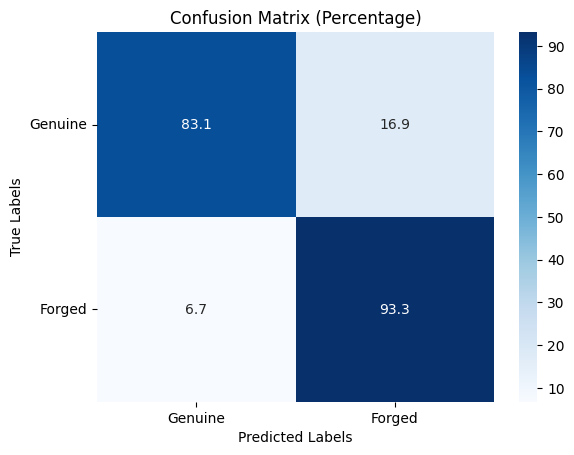

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       248
           1       0.85      0.93      0.89       252

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



array([[206,  42],
       [ 17, 235]])

In [38]:
build_confusion_matrix(preds,labels)
print(classification_report(preds,labels))
confusion_matrix(preds,labels)

5it [00:01,  2.90it/s]


03	/Test/03/original_3_23.png	0	0


5it [00:01,  3.29it/s]


03	/Test/03/original_3_4.png	0	0


5it [00:01,  3.04it/s]


03	/Test/03/original_3_20.png	0	0


5it [00:01,  2.96it/s]


03	/Test/03/original_3_16.png	0	0


5it [00:01,  2.86it/s]


03	/Test/03/original_3_17.png	0	0


5it [00:01,  3.07it/s]


62	/Test/62/H-S-62-F-15.jpg	1	1


5it [00:01,  3.60it/s]


62	/Test/62/H-S-62-G-17.jpg	0	0


5it [00:01,  3.08it/s]


62	/Test/62/H-S-62-F-06.jpg	1	1


5it [00:01,  3.58it/s]


62	/Test/62/H-S-62-G-20.jpg	0	0


5it [00:01,  3.27it/s]


62	/Test/62/H-S-62-F-09.jpg	1	0


4it [00:00,  8.59it/s]


8	/Test/8/forge_08_04.jpg	1	1


4it [00:00,  8.72it/s]


8	/Test/8/original_08_04.jpg	0	1


4it [00:00,  8.69it/s]


8	/Test/8/original_08_01.jpg	0	0


4it [00:00,  8.37it/s]


8	/Test/8/original_08_02.jpg	0	0


4it [00:00,  7.08it/s]


8	/Test/8/forge_08_01.jpg	1	1


5it [00:00,  5.16it/s]


72	/Test/72/H-S-72-F-11.jpg	1	1


5it [00:00,  5.68it/s]


72	/Test/72/H-S-72-F-01.jpg	1	1


5it [00:00,  5.05it/s]


72	/Test/72/H-S-72-F-15.jpg	1	1


5it [00:00,  6.00it/s]


72	/Test/72/H-S-72-G-16.jpg	0	0


5it [00:00,  5.31it/s]


72	/Test/72/H-S-72-F-13.jpg	1	1


5it [00:01,  3.02it/s]


59	/Test/59/H-S-59-G-11.jpg	0	1


5it [00:01,  3.09it/s]


59	/Test/59/H-S-59-F-17.jpg	1	1


5it [00:01,  3.11it/s]


59	/Test/59/H-S-59-G-13.jpg	0	1


5it [00:01,  3.26it/s]


59	/Test/59/H-S-59-G-04.jpg	0	1


5it [00:01,  3.08it/s]


59	/Test/59/H-S-59-F-30.jpg	1	1


5it [00:01,  4.15it/s]


57	/Test/57/H-S-57-F-25.jpg	1	1


5it [00:01,  3.84it/s]


57	/Test/57/H-S-57-F-15.jpg	1	1


5it [00:01,  4.11it/s]


57	/Test/57/H-S-57-F-04.jpg	1	1


5it [00:01,  4.84it/s]


57	/Test/57/H-S-57-G-11.jpg	0	0


5it [00:01,  4.86it/s]


57	/Test/57/H-S-57-G-08.jpg	0	0


3it [00:00,  6.13it/s]


7	/Test/7/original_07_02.jpg	0	0


3it [00:00,  6.56it/s]


7	/Test/7/forge_07_05.jpg	1	1


3it [00:00,  6.53it/s]


7	/Test/7/original_07_03.jpg	0	0


3it [00:00,  6.67it/s]


7	/Test/7/forge_07_02.jpg	1	0


3it [00:00,  6.30it/s]


7	/Test/7/forge_07_01.jpg	1	0


5it [00:00,  6.92it/s]


75	/Test/75/H-S-75-G-08.jpg	0	0


5it [00:00,  5.42it/s]


75	/Test/75/H-S-75-F-25.jpg	1	1


5it [00:00,  6.27it/s]


75	/Test/75/H-S-75-G-15.jpg	0	0


5it [00:00,  5.56it/s]


75	/Test/75/H-S-75-F-27.jpg	1	1


5it [00:00,  6.72it/s]


75	/Test/75/H-S-75-G-07.jpg	0	0


5it [00:01,  2.86it/s]


05	/Test/05/forgeries_5_15.png	1	1


5it [00:01,  2.90it/s]


05	/Test/05/forgeries_5_18.png	1	0


5it [00:01,  2.63it/s]


05	/Test/05/original_5_7.png	0	0


5it [00:01,  2.80it/s]


05	/Test/05/original_5_13.png	0	0


5it [00:01,  2.97it/s]


05	/Test/05/original_5_4.png	0	0


5it [00:01,  4.10it/s]


67	/Test/67/H-S-67-F-30.jpg	1	1


5it [00:00,  5.10it/s]


67	/Test/67/H-S-67-G-02.jpg	0	0


5it [00:00,  5.04it/s]


67	/Test/67/H-S-67-G-01.jpg	0	0


5it [00:01,  4.27it/s]


67	/Test/67/H-S-67-F-25.jpg	1	0


5it [00:01,  4.83it/s]


67	/Test/67/H-S-67-G-16.jpg	0	0


4it [00:00,  7.06it/s]


9	/Test/9/forge_09_04.jpg	1	0


4it [00:00,  6.29it/s]


9	/Test/9/original_09_02.jpg	0	0


4it [00:00,  7.75it/s]


9	/Test/9/original_09_01.jpg	0	0


4it [00:00,  6.77it/s]


9	/Test/9/forge_09_01.jpg	1	1


4it [00:00,  7.08it/s]


9	/Test/9/forge_09_02.jpg	1	0


4it [00:00,  7.46it/s]


3	/Test/3/forge_03_01.jpg	1	0


4it [00:00,  6.63it/s]


3	/Test/3/original_03_01.jpg	0	0


4it [00:00,  6.09it/s]


3	/Test/3/original_03_03.jpg	0	0


4it [00:00,  6.58it/s]


3	/Test/3/original_03_04.jpg	0	0


4it [00:00,  7.77it/s]


3	/Test/3/forge_03_02.jpg	1	1


5it [00:02,  2.50it/s]


09	/Test/09/original_9_23.png	0	1


5it [00:01,  3.06it/s]


09	/Test/09/original_9_19.png	0	0


5it [00:01,  2.98it/s]


09	/Test/09/forgeries_9_21.png	1	1


5it [00:01,  3.12it/s]


09	/Test/09/original_9_11.png	0	0


5it [00:01,  3.04it/s]


09	/Test/09/original_9_6.png	0	1


5it [00:01,  3.77it/s]


06	/Test/06/forgeries_6_16.png	1	1


5it [00:01,  3.45it/s]


06	/Test/06/original_6_11.png	0	0


5it [00:01,  3.84it/s]


06	/Test/06/forgeries_6_3.png	1	0


5it [00:01,  3.51it/s]


06	/Test/06/forgeries_6_12.png	1	1


5it [00:01,  3.67it/s]


06	/Test/06/forgeries_6_18.png	1	0


5it [00:01,  3.09it/s]


63	/Test/63/H-S-63-F-15.jpg	1	1


5it [00:01,  2.95it/s]


63	/Test/63/H-S-63-F-10.jpg	1	1


5it [00:01,  3.02it/s]


63	/Test/63/H-S-63-F-17.jpg	1	0


5it [00:01,  2.92it/s]


63	/Test/63/H-S-63-F-08.jpg	1	0


5it [00:01,  3.46it/s]


63	/Test/63/H-S-63-G-02.jpg	0	0


5it [00:00,  5.69it/s]


65	/Test/65/H-S-65-G-20.jpg	0	0


5it [00:00,  5.63it/s]


65	/Test/65/H-S-65-G-23.jpg	0	0


5it [00:01,  4.34it/s]


65	/Test/65/H-S-65-F-21.jpg	1	1


5it [00:00,  5.65it/s]


65	/Test/65/H-S-65-G-01.jpg	0	0


5it [00:00,  5.75it/s]


65	/Test/65/H-S-65-G-12.jpg	0	0


4it [00:00,  7.87it/s]


5	/Test/5/forge_05_02.jpg	1	1


4it [00:00,  9.03it/s]


5	/Test/5/forge_05_03.jpg	1	1


4it [00:00,  8.82it/s]


5	/Test/5/original_05_02.jpg	0	0


4it [00:00,  8.46it/s]


5	/Test/5/forge_05_01.jpg	1	0


4it [00:00,  8.76it/s]


5	/Test/5/forge_05_04.jpg	1	0


5it [00:00,  5.02it/s]


69	/Test/69/H-S-69-F-08.jpg	1	1


5it [00:00,  5.54it/s]


69	/Test/69/H-S-69-G-19.jpg	0	0


5it [00:00,  5.36it/s]


69	/Test/69/H-S-69-F-25.jpg	1	1


5it [00:00,  5.41it/s]


69	/Test/69/H-S-69-G-04.jpg	0	0


5it [00:01,  4.70it/s]


69	/Test/69/H-S-69-G-09.jpg	0	0


5it [00:01,  3.23it/s]


77	/Test/77/H-S-77-F-01.jpg	1	1


5it [00:01,  3.44it/s]


77	/Test/77/H-S-77-F-23.jpg	1	1


5it [00:01,  3.38it/s]


77	/Test/77/H-S-77-F-05.jpg	1	1


5it [00:01,  3.53it/s]


77	/Test/77/H-S-77-F-13.jpg	1	1


5it [00:01,  4.34it/s]


77	/Test/77/H-S-77-G-16.jpg	0	0


5it [00:01,  3.88it/s]


58	/Test/58/H-S-58-F-14.jpg	1	1


5it [00:01,  3.82it/s]


58	/Test/58/H-S-58-F-17.jpg	1	1


5it [00:01,  3.75it/s]


58	/Test/58/H-S-58-F-13.jpg	1	1


5it [00:01,  3.98it/s]


58	/Test/58/H-S-58-F-07.jpg	1	1


5it [00:00,  5.18it/s]


58	/Test/58/H-S-58-G-06.jpg	0	0


5it [00:01,  2.85it/s]


70	/Test/70/H-S-70-G-22.jpg	0	1


5it [00:01,  2.87it/s]


70	/Test/70/H-S-70-G-17.jpg	0	1


5it [00:01,  2.97it/s]


70	/Test/70/H-S-70-G-19.jpg	0	0


5it [00:01,  3.48it/s]


70	/Test/70/H-S-70-F-23.jpg	1	1


5it [00:01,  3.45it/s]


70	/Test/70/H-S-70-G-24.jpg	0	0


5it [00:02,  2.29it/s]


66	/Test/66/H-S-66-G-15.jpg	0	0


5it [00:01,  2.61it/s]


66	/Test/66/H-S-66-F-09.jpg	1	1


5it [00:01,  2.61it/s]


66	/Test/66/H-S-66-F-13.jpg	1	1


5it [00:02,  2.45it/s]


66	/Test/66/H-S-66-G-02.jpg	0	0


5it [00:02,  2.49it/s]


66	/Test/66/H-S-66-G-21.jpg	0	0


5it [00:01,  3.67it/s]


76	/Test/76/H-S-076-G-18.jpg	0	0


5it [00:01,  3.81it/s]


76	/Test/76/H-S-076-G-11.jpg	0	0


5it [00:01,  3.40it/s]


76	/Test/76/H-S-076-G-10.jpg	0	1


5it [00:01,  3.27it/s]


76	/Test/76/H-S-076-F-26.jpg	1	0


5it [00:01,  3.72it/s]


76	/Test/76/H-S-076-G-24.jpg	0	0


4it [00:00,  7.44it/s]


6	/Test/6/forge_06_02.jpg	1	0


4it [00:00,  9.11it/s]


6	/Test/6/original_06_03.jpg	0	0


4it [00:00,  9.13it/s]


6	/Test/6/original_06_02.jpg	0	0


4it [00:00,  8.58it/s]


6	/Test/6/original_06_01.jpg	0	0


4it [00:00,  9.17it/s]


6	/Test/6/forge_06_04.jpg	1	0


5it [00:01,  3.62it/s]


73	/Test/73/H-S-73-G-13.jpg	0	0


5it [00:01,  3.51it/s]


73	/Test/73/H-S-73-G-23.jpg	0	1


5it [00:01,  3.81it/s]


73	/Test/73/H-S-73-F-13.jpg	1	0


5it [00:01,  3.72it/s]


73	/Test/73/H-S-73-G-04.jpg	0	0


5it [00:01,  3.76it/s]


73	/Test/73/H-S-73-G-22.jpg	0	0


5it [00:00,  5.94it/s]


56	/Test/56/H-S-56-G-11.jpg	0	0


5it [00:01,  3.90it/s]


56	/Test/56/H-S-56-F-17.jpg	1	1


5it [00:01,  4.19it/s]


56	/Test/56/H-S-56-F-16.jpg	1	1


5it [00:01,  4.35it/s]


56	/Test/56/H-S-56-F-28.jpg	1	1


5it [00:00,  5.74it/s]


56	/Test/56/H-S-56-G-19.jpg	0	0


5it [00:03,  1.52it/s]


07	/Test/07/original_7_9.png	0	1


5it [00:03,  1.48it/s]


07	/Test/07/forgeries_7_4.png	1	1


5it [00:03,  1.49it/s]


07	/Test/07/forgeries_7_22.png	1	1


5it [00:03,  1.57it/s]


07	/Test/07/original_7_16.png	0	1


5it [00:03,  1.62it/s]


07	/Test/07/original_7_21.png	0	0


5it [00:01,  3.78it/s]


60	/Test/60/H-S-60-G-17.jpg	0	1


5it [00:01,  3.82it/s]


60	/Test/60/H-S-60-F-08.jpg	1	0


5it [00:01,  4.04it/s]


60	/Test/60/H-S-60-G-16.jpg	0	0


5it [00:01,  4.24it/s]


60	/Test/60/H-S-60-G-18.jpg	0	0


5it [00:01,  4.09it/s]


60	/Test/60/H-S-60-G-13.jpg	0	0


5it [00:01,  3.16it/s]


01	/Test/01/forgeries_1_4.png	1	0


5it [00:01,  2.85it/s]


01	/Test/01/forgeries_1_24.png	1	1


5it [00:01,  2.74it/s]


01	/Test/01/original_1_1.png	0	0


5it [00:01,  2.96it/s]


01	/Test/01/forgeries_1_22.png	1	1


5it [00:01,  3.20it/s]


01	/Test/01/forgeries_1_1.png	1	0


5it [00:01,  5.00it/s]


71	/Test/71/H-S-71-G-14.jpg	0	0


5it [00:01,  4.32it/s]


71	/Test/71/H-S-71-F-28.jpg	1	1


5it [00:00,  5.16it/s]


71	/Test/71/H-S-71-G-09.jpg	0	0


5it [00:01,  4.91it/s]


71	/Test/71/H-S-71-G-08.jpg	0	0


5it [00:01,  4.09it/s]


71	/Test/71/H-S-71-F-25.jpg	1	1


4it [00:00, 11.11it/s]


1	/Test/1/original_01_02.jpg	0	0


4it [00:00,  7.34it/s]


1	/Test/1/original_01_01.jpg	0	0


4it [00:00,  8.02it/s]


1	/Test/1/forge_01_02.jpg	1	1


4it [00:00, 10.62it/s]


1	/Test/1/forge_01_04.jpg	1	0


4it [00:00,  8.79it/s]


1	/Test/1/forge_01_01.jpg	1	1


2it [00:00,  8.10it/s]


4	/Test/4/forge_04_01.jpg	1	1


2it [00:00,  8.26it/s]


4	/Test/4/original_04_02.jpg	0	0


2it [00:00,  6.71it/s]


4	/Test/4/original_04_01.jpg	0	1


2it [00:00,  7.96it/s]


4	/Test/4/forge_04_02.jpg	1	0


5it [00:01,  3.48it/s]


02	/Test/02/original_2_5.png	0	0


5it [00:01,  4.53it/s]


02	/Test/02/original_2_12.png	0	0


5it [00:01,  4.20it/s]


02	/Test/02/forgeries_2_4.png	1	1


5it [00:01,  4.32it/s]


02	/Test/02/forgeries_2_9.png	1	0


5it [00:01,  4.39it/s]


02	/Test/02/forgeries_2_3.png	1	1


5it [00:01,  2.98it/s]


08	/Test/08/forgeries_8_4.png	1	0


5it [00:01,  2.65it/s]


08	/Test/08/original_8_14.png	0	1


5it [00:01,  2.73it/s]


08	/Test/08/forgeries_8_18.png	1	0


5it [00:02,  2.43it/s]


08	/Test/08/forgeries_8_10.png	1	1


5it [00:01,  2.71it/s]


08	/Test/08/original_8_8.png	0	1


5it [00:00,  6.06it/s]


04	/Test/04/original_4_23.png	0	0


5it [00:00,  5.78it/s]


04	/Test/04/original_4_19.png	0	0


5it [00:00,  6.31it/s]


04	/Test/04/original_4_21.png	0	0


5it [00:00,  5.91it/s]


04	/Test/04/original_4_15.png	0	0


5it [00:00,  5.97it/s]


04	/Test/04/original_4_9.png	0	0


5it [00:01,  4.06it/s]


68	/Test/68/H-S-68-F-22.jpg	1	1


5it [00:01,  4.48it/s]


68	/Test/68/H-S-68-G-05.jpg	0	0


5it [00:01,  4.57it/s]


68	/Test/68/H-S-68-G-09.jpg	0	0


5it [00:01,  4.53it/s]


68	/Test/68/H-S-68-G-15.jpg	0	0


5it [00:01,  4.03it/s]


68	/Test/68/H-S-68-F-18.jpg	1	1


5it [00:01,  2.63it/s]


64	/Test/64/H-S-64-F-19.jpg	1	1


5it [00:01,  2.73it/s]


64	/Test/64/H-S-64-G-18.jpg	0	0


5it [00:01,  2.62it/s]


64	/Test/64/H-S-64-F-13.jpg	1	1


5it [00:01,  2.52it/s]


64	/Test/64/H-S-64-F-18.jpg	1	1


5it [00:02,  2.42it/s]


64	/Test/64/H-S-64-F-28.jpg	1	1


5it [00:01,  2.87it/s]


61	/Test/61/H-S-61-F-30.jpg	1	1


5it [00:01,  3.16it/s]


61	/Test/61/H-S-61-G-18.jpg	0	0


5it [00:01,  3.11it/s]


61	/Test/61/H-S-61-G-13.jpg	0	0


5it [00:01,  3.09it/s]


61	/Test/61/H-S-61-G-09.jpg	0	0


5it [00:01,  2.98it/s]


61	/Test/61/H-S-61-F-10.jpg	1	1


5it [00:01,  3.92it/s]


74	/Test/74/H-S-74-G-23.jpg	0	1


5it [00:01,  4.10it/s]


74	/Test/74/H-S-74-G-24.jpg	0	0


5it [00:01,  3.73it/s]


74	/Test/74/H-S-74-F-10.jpg	1	1


5it [00:01,  3.42it/s]


74	/Test/74/H-S-74-F-17.jpg	1	1


5it [00:01,  4.19it/s]


74	/Test/74/H-S-74-G-12.jpg	0	0


4it [00:00,  5.87it/s]


2	/Test/2/forge_02_04.jpg	1	0


4it [00:00,  6.52it/s]


2	/Test/2/forge_02_01.jpg	1	1


4it [00:00,  5.96it/s]


2	/Test/2/forge_02_03.jpg	1	0


4it [00:00,  5.51it/s]


2	/Test/2/original_02_01.jpg	0	0


4it [00:00,  6.59it/s]


2	/Test/2/forge_02_02.jpg	1	0


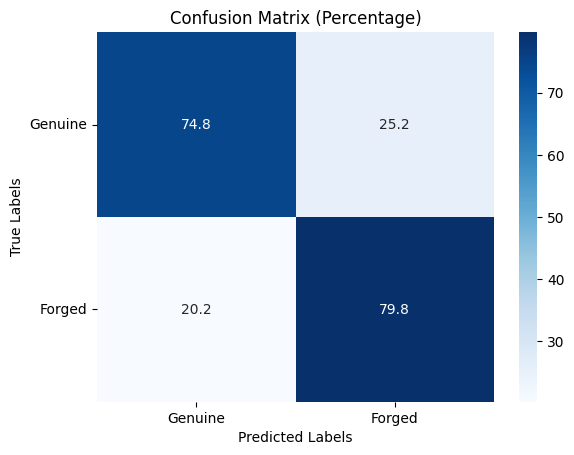

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       115
           1       0.70      0.80      0.74        84

    accuracy                           0.77       199
   macro avg       0.77      0.77      0.77       199
weighted avg       0.78      0.77      0.77       199



array([[86, 29],
       [17, 67]])

In [39]:
#@title Forgery dataset test
folder = f'{forgery_path}/Test'
preds,labels = perform_voting_for_each_test_images(folder, forgery_path)

build_confusion_matrix(preds,labels)
print(classification_report(preds,labels))
confusion_matrix(preds,labels)

5it [00:01,  4.11it/s]


151	/Train/151/H-S-151-G-21.jpg	0	0


5it [00:01,  4.54it/s]


151	/Train/151/H-S-151-G-22.jpg	0	0


5it [00:01,  4.75it/s]


151	/Train/151/H-S-151-F-30.jpg	1	1


5it [00:01,  4.38it/s]


151	/Train/151/H-S-151-F-15.jpg	1	1


5it [00:01,  4.26it/s]


151	/Train/151/H-S-151-F-24.jpg	1	1


5it [00:01,  3.01it/s]


146	/Train/146/H-S-146-F-02.jpg	1	1


5it [00:01,  3.02it/s]


146	/Train/146/H-S-146-F-27.jpg	1	1


5it [00:01,  3.08it/s]


146	/Train/146/H-S-146-F-30.jpg	1	1


5it [00:01,  3.22it/s]


146	/Train/146/H-S-146-F-25.jpg	1	1


5it [00:01,  2.99it/s]


146	/Train/146/H-S-146-F-23.jpg	1	1


5it [00:01,  2.64it/s]


62	/Train/62/B-S-62-F-11.jpg	1	1


5it [00:01,  2.79it/s]


62	/Train/62/B-S-62-F-17.jpg	1	1


5it [00:01,  2.83it/s]


62	/Train/62/B-S-62-G-17.jpg	0	0


5it [00:01,  2.89it/s]


62	/Train/62/B-S-62-G-09.jpg	0	0


5it [00:01,  2.96it/s]


62	/Train/62/B-S-62-F-26.jpg	1	1


5it [00:01,  3.60it/s]


30	/Train/30/original_30_22.png	0	0


5it [00:01,  3.17it/s]


30	/Train/30/forgeries_30_10.png	1	1


5it [00:01,  3.25it/s]


30	/Train/30/original_30_12.png	0	0


5it [00:01,  3.38it/s]


30	/Train/30/original_30_4.png	0	0


5it [00:01,  2.68it/s]


30	/Train/30/forgeries_30_12.png	1	1


4it [00:00,  9.19it/s]


8	/Train/8/original_08_03.jpg	0	0


4it [00:00,  8.69it/s]


8	/Train/8/original_08_01.jpg	0	0


4it [00:00,  8.70it/s]


8	/Train/8/original_08_04.jpg	0	1


4it [00:00,  8.37it/s]


8	/Train/8/original_08_02.jpg	0	0


4it [00:00,  7.18it/s]


8	/Train/8/forge_08_01.jpg	1	1


5it [00:01,  2.79it/s]


72	/Train/72/B-S-72-G-18.jpg	0	0


5it [00:01,  2.97it/s]


72	/Train/72/B-S-72-F-14.jpg	1	1


5it [00:01,  2.85it/s]


72	/Train/72/B-S-72-G-07.jpg	0	0


5it [00:01,  2.84it/s]


72	/Train/72/B-S-72-G-21.jpg	0	0


5it [00:01,  3.03it/s]


72	/Train/72/B-S-72-F-20.jpg	1	1


5it [00:01,  3.07it/s]


130	/Train/130/H-S-130-F-30.jpg	1	1


5it [00:01,  3.16it/s]


130	/Train/130/H-S-130-F-14.jpg	1	1


5it [00:01,  3.03it/s]


130	/Train/130/H-S-130-F-18.jpg	1	1


5it [00:01,  3.15it/s]


130	/Train/130/H-S-130-F-20.jpg	1	1


5it [00:01,  3.06it/s]


130	/Train/130/H-S-130-F-05.jpg	1	1


5it [00:01,  3.54it/s]


42	/Train/42/forgeries_42_19.png	1	1


5it [00:01,  4.01it/s]


42	/Train/42/original_42_1.png	0	0


5it [00:01,  3.99it/s]


42	/Train/42/original_42_13.png	0	0


5it [00:01,  3.72it/s]


42	/Train/42/original_42_17.png	0	0


5it [00:01,  4.43it/s]


42	/Train/42/original_42_4.png	0	0


5it [00:01,  3.63it/s]


59	/Train/59/B-S-59-F-27.jpg	1	1


5it [00:01,  3.49it/s]


59	/Train/59/B-S-59-F-30.jpg	1	1


5it [00:01,  3.85it/s]


59	/Train/59/B-S-59-G-07.jpg	0	0


5it [00:01,  4.03it/s]


59	/Train/59/B-S-59-F-01.jpg	1	1


5it [00:01,  3.96it/s]


59	/Train/59/B-S-59-F-07.jpg	1	1


5it [00:00,  6.13it/s]


19	/Train/19/original_19_17.png	0	0


5it [00:00,  5.15it/s]


19	/Train/19/forgeries_19_6.png	1	0


5it [00:00,  5.42it/s]


19	/Train/19/forgeries_19_9.png	1	0


5it [00:01,  4.57it/s]


19	/Train/19/forgeries_19_20.png	1	1


5it [00:00,  5.31it/s]


19	/Train/19/forgeries_19_8.png	1	0


5it [00:01,  4.10it/s]


39	/Train/39/forgeries_39_7.png	1	1


5it [00:01,  4.11it/s]


39	/Train/39/original_39_18.png	0	0


5it [00:01,  4.21it/s]


39	/Train/39/forgeries_39_19.png	1	1


5it [00:01,  3.98it/s]


39	/Train/39/forgeries_39_12.png	1	1


5it [00:01,  4.09it/s]


39	/Train/39/forgeries_39_4.png	1	1


5it [00:01,  4.17it/s]


150	/Train/150/H-S-150-F-20.jpg	1	1


5it [00:01,  4.78it/s]


150	/Train/150/H-S-150-G-14.jpg	0	0


5it [00:01,  3.94it/s]


150	/Train/150/H-S-150-F-03.jpg	1	1


5it [00:01,  3.84it/s]


150	/Train/150/H-S-150-F-15.jpg	1	1


5it [00:01,  3.78it/s]


150	/Train/150/H-S-150-F-18.jpg	1	1


5it [00:00,  9.15it/s]


57	/Train/57/forgeries_57_01.jpg	1	0


5it [00:00, 10.42it/s]


57	/Train/57/forgeries_57_03.jpg	1	0


5it [00:00,  9.81it/s]


57	/Train/57/original_57_04.jpg	0	0


5it [00:00,  8.90it/s]


57	/Train/57/original_57_02.jpg	0	0


5it [00:00,  8.85it/s]


57	/Train/57/original_57_03.jpg	0	0


5it [00:02,  2.17it/s]


31	/Train/31/forgeries_31_17.png	1	1


5it [00:02,  1.81it/s]


31	/Train/31/original_31_7.png	0	0


5it [00:02,  2.39it/s]


31	/Train/31/forgeries_31_13.png	1	1


5it [00:02,  2.22it/s]


31	/Train/31/forgeries_31_22.png	1	1


5it [00:02,  1.76it/s]


31	/Train/31/original_31_19.png	0	0


5it [00:00,  7.37it/s]


25	/Train/25/forgeries_25_9.png	1	1


5it [00:00,  6.62it/s]


25	/Train/25/forgeries_25_21.png	1	1


5it [00:00,  8.70it/s]


25	/Train/25/original_25_8.png	0	0


5it [00:00,  7.36it/s]


25	/Train/25/forgeries_25_10.png	1	1


5it [00:00,  7.12it/s]


25	/Train/25/forgeries_25_3.png	1	1


5it [00:02,  2.19it/s]


49	/Train/49/original_49_7.png	0	0


5it [00:01,  2.61it/s]


49	/Train/49/forgeries_49_22.png	1	1


5it [00:02,  2.45it/s]


49	/Train/49/original_49_4.png	0	0


5it [00:01,  2.62it/s]


49	/Train/49/forgeries_49_19.png	1	1


5it [00:01,  2.51it/s]


49	/Train/49/forgeries_49_1.png	1	1


3it [00:00,  6.22it/s]


7	/Train/7/forge_07_01.jpg	1	0


3it [00:00,  7.13it/s]


7	/Train/7/forge_07_04.jpg	1	1


3it [00:00,  6.58it/s]


7	/Train/7/forge_07_05.jpg	1	1


3it [00:00,  6.64it/s]


7	/Train/7/forge_07_02.jpg	1	0


3it [00:00,  6.56it/s]


7	/Train/7/forge_07_03.jpg	1	1


5it [00:01,  4.58it/s]


55	/Train/55/original_55_12.png	0	0


5it [00:01,  4.22it/s]


55	/Train/55/original_55_14.png	0	1


5it [00:01,  4.69it/s]


55	/Train/55/original_55_5.png	0	0


5it [00:01,  4.29it/s]


55	/Train/55/original_55_20.png	0	0


5it [00:01,  3.84it/s]


55	/Train/55/forgeries_55_23.png	1	1


5it [00:01,  3.93it/s]


154	/Train/154/H-S-154-F-18.jpg	1	1


5it [00:01,  4.35it/s]


154	/Train/154/H-S-154-F-27.jpg	1	1


5it [00:01,  4.77it/s]


154	/Train/154/H-S-154-G-11.jpg	0	0


5it [00:01,  4.31it/s]


154	/Train/154/H-S-154-G-13.jpg	0	0


5it [00:01,  4.22it/s]


154	/Train/154/H-S-154-F-29.jpg	1	1


5it [00:01,  4.26it/s]


75	/Train/75/B-S-75-G-02.jpg	0	0


5it [00:01,  4.43it/s]


75	/Train/75/B-S-75-F-03.jpg	1	1


5it [00:01,  4.01it/s]


75	/Train/75/B-S-75-G-03.jpg	0	0


5it [00:01,  4.45it/s]


75	/Train/75/B-S-75-G-17.jpg	0	0


5it [00:01,  4.61it/s]


75	/Train/75/B-S-75-G-10.jpg	0	0


5it [00:02,  2.37it/s]


14	/Train/14/original_14_2.png	0	0


5it [00:02,  2.06it/s]


14	/Train/14/forgeries_14_4.png	1	1


5it [00:02,  1.98it/s]


14	/Train/14/forgeries_14_3.png	1	1


5it [00:02,  2.01it/s]


14	/Train/14/forgeries_14_24.png	1	1


5it [00:02,  2.20it/s]


14	/Train/14/original_14_16.png	0	0


5it [00:01,  2.99it/s]


93	/Train/93/B-S-93-F-11.jpg	1	1


5it [00:01,  2.96it/s]


93	/Train/93/B-S-93-F-20.jpg	1	1


5it [00:01,  2.78it/s]


93	/Train/93/B-S-93-F-09.jpg	1	1


5it [00:01,  2.82it/s]


93	/Train/93/B-S-93-G-10.jpg	0	0


5it [00:01,  2.82it/s]


93	/Train/93/B-S-93-G-21.jpg	0	0


5it [00:01,  3.28it/s]


67	/Train/67/B-S-67-G-23.jpg	0	0


5it [00:01,  4.00it/s]


67	/Train/67/B-S-67-F-06.jpg	1	1


5it [00:01,  3.82it/s]


67	/Train/67/B-S-67-F-12.jpg	1	1


5it [00:01,  3.42it/s]


67	/Train/67/B-S-67-G-20.jpg	0	0


5it [00:01,  3.47it/s]


67	/Train/67/B-S-67-G-24.jpg	0	0


4it [00:00,  7.84it/s]


9	/Train/9/original_09_01.jpg	0	0


4it [00:00,  6.91it/s]


9	/Train/9/original_09_04.jpg	0	0


4it [00:00,  7.28it/s]


9	/Train/9/original_09_03.jpg	0	0


4it [00:00,  7.04it/s]


9	/Train/9/forge_09_04.jpg	1	0


4it [00:00,  7.17it/s]


9	/Train/9/forge_09_02.jpg	1	0


4it [00:00,  7.44it/s]


3	/Train/3/forge_03_01.jpg	1	0


4it [00:00,  6.76it/s]


3	/Train/3/original_03_01.jpg	0	0


4it [00:00,  6.12it/s]


3	/Train/3/original_03_03.jpg	0	0


4it [00:00,  6.58it/s]


3	/Train/3/original_03_04.jpg	0	0


4it [00:00,  7.51it/s]


3	/Train/3/forge_03_03.jpg	1	0


5it [00:00,  6.10it/s]


33	/Train/33/original_33_15.png	0	0


5it [00:00,  5.58it/s]


33	/Train/33/original_33_19.png	0	0


5it [00:00,  5.89it/s]


33	/Train/33/original_33_13.png	0	0


5it [00:01,  4.52it/s]


33	/Train/33/forgeries_33_24.png	1	1


5it [00:01,  4.07it/s]


33	/Train/33/forgeries_33_2.png	1	1


5it [00:01,  3.25it/s]


37	/Train/37/forgeries_37_8.png	1	1


5it [00:01,  3.06it/s]


37	/Train/37/original_37_11.png	0	0


5it [00:01,  3.35it/s]


37	/Train/37/forgeries_37_11.png	1	1


5it [00:01,  3.31it/s]


37	/Train/37/forgeries_37_2.png	1	1


5it [00:01,  2.91it/s]


37	/Train/37/original_37_10.png	0	0


5it [00:01,  2.50it/s]


50	/Train/50/forgeries_50_17.png	1	1


5it [00:02,  2.34it/s]


50	/Train/50/original_50_18.png	0	0


5it [00:01,  2.58it/s]


50	/Train/50/forgeries_50_21.png	1	1


5it [00:02,  2.46it/s]


50	/Train/50/original_50_16.png	0	0


5it [00:01,  2.64it/s]


50	/Train/50/original_50_12.png	0	0


5it [00:01,  3.55it/s]


147	/Train/147/H-S-147-F-01.jpg	1	1


5it [00:01,  3.28it/s]


147	/Train/147/H-S-147-F-15.jpg	1	1


5it [00:01,  3.58it/s]


147	/Train/147/H-S-147-G-12.jpg	0	0


5it [00:01,  3.44it/s]


147	/Train/147/H-S-147-G-11.jpg	0	0


5it [00:01,  3.02it/s]


147	/Train/147/H-S-147-F-22.jpg	1	1


5it [00:01,  3.72it/s]


149	/Train/149/H-S-149-F-15.jpg	1	1


5it [00:01,  3.65it/s]


149	/Train/149/H-S-149-F-14.jpg	1	1


5it [00:01,  3.97it/s]


149	/Train/149/H-S-149-F-10.jpg	1	1


5it [00:01,  3.94it/s]


149	/Train/149/H-S-149-F-18.jpg	1	1


5it [00:01,  4.13it/s]


149	/Train/149/H-S-149-F-02.jpg	1	1


5it [00:00,  6.07it/s]


144	/Train/144/H-S-144-F-05.jpg	1	1


5it [00:00,  6.84it/s]


144	/Train/144/H-S-144-G-17.jpg	0	0


5it [00:00,  5.66it/s]


144	/Train/144/H-S-144-F-29.jpg	1	1


5it [00:00,  6.69it/s]


144	/Train/144/H-S-144-G-21.jpg	0	0


5it [00:00,  5.21it/s]


144	/Train/144/H-S-144-F-15.jpg	1	1


5it [00:02,  2.14it/s]


46	/Train/46/original_46_16.png	0	0


5it [00:02,  2.13it/s]


46	/Train/46/forgeries_46_6.png	1	1


5it [00:02,  2.15it/s]


46	/Train/46/original_46_1.png	0	0


5it [00:02,  2.11it/s]


46	/Train/46/forgeries_46_7.png	1	1


5it [00:02,  2.37it/s]


46	/Train/46/forgeries_46_16.png	1	1


5it [00:01,  2.83it/s]


63	/Train/63/B-S-63-G-17.jpg	0	0


5it [00:01,  2.78it/s]


63	/Train/63/B-S-63-F-02.jpg	1	1


5it [00:01,  2.67it/s]


63	/Train/63/B-S-63-G-05.jpg	0	0


5it [00:01,  2.81it/s]


63	/Train/63/B-S-63-G-08.jpg	0	0


5it [00:01,  2.60it/s]


63	/Train/63/B-S-63-F-13.jpg	1	1


5it [00:01,  3.71it/s]


141	/Train/141/H-S-141-G-10.jpg	0	0


5it [00:01,  3.31it/s]


141	/Train/141/H-S-141-F-26.jpg	1	1


5it [00:01,  3.30it/s]


141	/Train/141/H-S-141-G-15.jpg	0	0


5it [00:01,  3.65it/s]


141	/Train/141/H-S-141-G-07.jpg	0	0


5it [00:01,  3.48it/s]


141	/Train/141/H-S-141-F-21.jpg	1	1


5it [00:01,  4.42it/s]


96	/Train/96/B-S-96-G-08.jpg	0	0


5it [00:01,  3.59it/s]


96	/Train/96/B-S-96-F-22.jpg	1	1


5it [00:01,  4.79it/s]


96	/Train/96/B-S-96-G-02.jpg	0	0


5it [00:01,  3.45it/s]


96	/Train/96/B-S-96-F-30.jpg	1	1


5it [00:01,  4.55it/s]


96	/Train/96/B-S-96-G-10.jpg	0	0


5it [00:00,  5.13it/s]


65	/Train/65/B-S-65-G-09.jpg	0	0


5it [00:01,  4.58it/s]


65	/Train/65/B-S-65-F-26.jpg	1	1


5it [00:00,  5.08it/s]


65	/Train/65/B-S-65-G-20.jpg	0	0


5it [00:00,  5.19it/s]


65	/Train/65/B-S-65-G-22.jpg	0	0


5it [00:00,  5.30it/s]


65	/Train/65/B-S-65-G-10.jpg	0	0


5it [00:00,  5.23it/s]


133	/Train/133/H-S-133-G-10.jpg	0	0


5it [00:00,  5.18it/s]


133	/Train/133/H-S-133-G-21.jpg	0	0


5it [00:00,  5.31it/s]


133	/Train/133/H-S-133-F-10.jpg	1	1


5it [00:01,  4.83it/s]


133	/Train/133/H-S-133-F-09.jpg	1	1


5it [00:00,  5.14it/s]


133	/Train/133/H-S-133-G-08.jpg	0	0


5it [00:01,  3.00it/s]


80	/Train/80/B-S-80-G-23.jpg	0	0


5it [00:01,  2.84it/s]


80	/Train/80/B-S-80-F-30.jpg	1	1


5it [00:01,  3.01it/s]


80	/Train/80/B-S-80-F-13.jpg	1	1


5it [00:01,  3.05it/s]


80	/Train/80/B-S-80-F-06.jpg	1	1


5it [00:01,  3.38it/s]


80	/Train/80/B-S-80-G-14.jpg	0	0


5it [00:01,  3.20it/s]


145	/Train/145/H-S-145-G-19.jpg	0	0


5it [00:01,  3.67it/s]


145	/Train/145/H-S-145-F-16.jpg	1	1


5it [00:01,  3.76it/s]


145	/Train/145/H-S-145-F-29.jpg	1	1


5it [00:01,  3.70it/s]


145	/Train/145/H-S-145-F-01.jpg	1	1


5it [00:01,  3.56it/s]


145	/Train/145/H-S-145-F-15.jpg	1	1


5it [00:01,  2.86it/s]


134	/Train/134/H-S-134-F-02.jpg	1	1


5it [00:01,  2.85it/s]


134	/Train/134/H-S-134-G-06.jpg	0	0


5it [00:01,  2.75it/s]


134	/Train/134/H-S-134-G-03.jpg	0	0


5it [00:01,  2.79it/s]


134	/Train/134/H-S-134-F-28.jpg	1	1


5it [00:01,  2.81it/s]


134	/Train/134/H-S-134-G-11.jpg	0	0


5it [00:00,  5.71it/s]


24	/Train/24/forgeries_24_5.png	1	1


5it [00:00,  6.25it/s]


24	/Train/24/original_24_1.png	0	0


5it [00:00,  6.41it/s]


24	/Train/24/original_24_13.png	0	0


5it [00:00,  6.03it/s]


24	/Train/24/original_24_7.png	0	0


5it [00:00,  6.42it/s]


24	/Train/24/original_24_12.png	0	0


5it [00:01,  3.54it/s]


38	/Train/38/forgeries_38_4.png	1	1


5it [00:01,  3.89it/s]


38	/Train/38/forgeries_38_19.png	1	1


5it [00:01,  3.91it/s]


38	/Train/38/original_38_2.png	0	0


5it [00:01,  3.64it/s]


38	/Train/38/original_38_24.png	0	0


5it [00:01,  3.41it/s]


38	/Train/38/forgeries_38_7.png	1	1


5it [00:01,  4.93it/s]


136	/Train/136/H-S-136-F-11.jpg	1	1


5it [00:01,  4.61it/s]


136	/Train/136/H-S-136-F-06.jpg	1	1


5it [00:00,  5.21it/s]


136	/Train/136/H-S-136-F-01.jpg	1	1


5it [00:00,  5.07it/s]


136	/Train/136/H-S-136-G-17.jpg	0	0


5it [00:01,  4.03it/s]


136	/Train/136/H-S-136-F-21.jpg	1	1


5it [00:01,  4.35it/s]


94	/Train/94/B-S-94-G-04.jpg	0	0


5it [00:01,  4.22it/s]


94	/Train/94/B-S-94-F-07.jpg	1	1


5it [00:01,  3.89it/s]


94	/Train/94/B-S-94-F-20.jpg	1	1


5it [00:01,  4.16it/s]


94	/Train/94/B-S-94-F-24.jpg	1	1


5it [00:01,  4.17it/s]


94	/Train/94/B-S-94-F-05.jpg	1	1


4it [00:00,  7.78it/s]


5	/Train/5/original_05_01.jpg	0	0


4it [00:00,  8.85it/s]


5	/Train/5/original_05_02.jpg	0	0


4it [00:00,  9.00it/s]


5	/Train/5/forge_05_03.jpg	1	1


4it [00:00,  8.39it/s]


5	/Train/5/original_05_04.jpg	0	0


4it [00:00,  8.73it/s]


5	/Train/5/forge_05_04.jpg	1	0


5it [00:00,  5.85it/s]


21	/Train/21/forgeries_21_8.png	1	1


5it [00:00,  7.20it/s]


21	/Train/21/original_21_23.png	0	0


5it [00:01,  4.23it/s]


21	/Train/21/forgeries_21_14.png	1	1


5it [00:00,  6.19it/s]


21	/Train/21/forgeries_21_10.png	1	1


5it [00:01,  4.72it/s]


21	/Train/21/forgeries_21_3.png	1	1


5it [00:01,  2.56it/s]


69	/Train/69/B-S-69-F-10.jpg	1	1


5it [00:02,  2.35it/s]


69	/Train/69/B-S-69-G-05.jpg	0	0


5it [00:01,  2.61it/s]


69	/Train/69/B-S-69-G-06.jpg	0	0


5it [00:01,  2.67it/s]


69	/Train/69/B-S-69-F-08.jpg	1	1


5it [00:01,  2.62it/s]


69	/Train/69/B-S-69-G-19.jpg	0	0


5it [00:01,  3.79it/s]


92	/Train/92/B-S-92-F-13.jpg	1	1


5it [00:01,  3.87it/s]


92	/Train/92/B-S-92-F-27.jpg	1	1


5it [00:01,  3.91it/s]


92	/Train/92/B-S-92-F-06.jpg	1	1


5it [00:01,  3.88it/s]


92	/Train/92/B-S-92-G-16.jpg	0	0


5it [00:01,  3.55it/s]


92	/Train/92/B-S-92-F-28.jpg	1	1


5it [00:01,  2.98it/s]


17	/Train/17/original_17_12.png	0	0


5it [00:01,  3.05it/s]


17	/Train/17/original_17_15.png	0	0


5it [00:01,  2.68it/s]


17	/Train/17/forgeries_17_20.png	1	1


5it [00:01,  3.08it/s]


17	/Train/17/original_17_21.png	0	0


5it [00:02,  2.33it/s]


17	/Train/17/original_17_11.png	0	0


5it [00:01,  3.79it/s]


139	/Train/139/H-S-139-F-20.jpg	1	1


5it [00:01,  3.77it/s]


139	/Train/139/H-S-139-F-10.jpg	1	1


5it [00:01,  3.46it/s]


139	/Train/139/H-S-139-F-25.jpg	1	0


5it [00:01,  3.68it/s]


139	/Train/139/H-S-139-F-11.jpg	1	1


5it [00:01,  4.15it/s]


139	/Train/139/H-S-139-F-22.jpg	1	1


5it [00:01,  4.50it/s]


158	/Train/158/H-S-158-G-01.jpg	0	0


5it [00:01,  4.50it/s]


158	/Train/158/H-S-158-F-29.jpg	1	1


5it [00:01,  3.55it/s]


158	/Train/158/H-S-158-F-22.jpg	1	1


5it [00:01,  4.03it/s]


158	/Train/158/H-S-158-F-20.jpg	1	1


5it [00:01,  4.24it/s]


158	/Train/158/H-S-158-F-23.jpg	1	1


5it [00:01,  3.79it/s]


77	/Train/77/B-S-77-G-09.jpg	0	0


5it [00:01,  4.03it/s]


77	/Train/77/B-S-77-G-14.jpg	0	0


5it [00:01,  3.26it/s]


77	/Train/77/B-S-77-F-07.jpg	1	1


5it [00:01,  3.31it/s]


77	/Train/77/B-S-77-F-08.jpg	1	1


5it [00:01,  3.87it/s]


77	/Train/77/B-S-77-F-21.jpg	1	1


5it [00:01,  4.35it/s]


152	/Train/152/H-S-152-G-15.jpg	0	0


5it [00:01,  3.85it/s]


152	/Train/152/H-S-152-G-19.jpg	0	0


5it [00:01,  4.09it/s]


152	/Train/152/H-S-152-F-17.jpg	1	1


5it [00:01,  3.55it/s]


152	/Train/152/H-S-152-F-24.jpg	1	1


5it [00:01,  3.34it/s]


152	/Train/152/H-S-152-F-19.jpg	1	1


5it [00:01,  4.24it/s]


148	/Train/148/H-S-148-F-22.jpg	1	1


5it [00:00,  5.80it/s]


148	/Train/148/H-S-148-G-23.jpg	0	0


5it [00:01,  4.39it/s]


148	/Train/148/H-S-148-F-30.jpg	1	1


5it [00:01,  4.62it/s]


148	/Train/148/H-S-148-F-11.jpg	1	1


5it [00:01,  4.44it/s]


148	/Train/148/H-S-148-F-26.jpg	1	1


5it [00:01,  4.68it/s]


156	/Train/156/H-S-156-F-07.jpg	1	1


5it [00:00,  5.58it/s]


156	/Train/156/H-S-156-G-06.jpg	0	0


5it [00:01,  4.17it/s]


156	/Train/156/H-S-156-F-15.jpg	1	1


5it [00:00,  5.56it/s]


156	/Train/156/H-S-156-G-03.jpg	0	0


5it [00:01,  4.41it/s]


156	/Train/156/H-S-156-F-09.jpg	1	1


5it [00:02,  2.17it/s]


12	/Train/12/forgeries_12_20.png	1	1


5it [00:02,  2.10it/s]


12	/Train/12/forgeries_12_24.png	1	1


5it [00:02,  1.87it/s]


12	/Train/12/original_12_16.png	0	0


5it [00:02,  1.96it/s]


12	/Train/12/forgeries_12_7.png	1	1


5it [00:02,  2.01it/s]


12	/Train/12/original_12_7.png	0	0


5it [00:01,  2.91it/s]


58	/Train/58/B-S-58-G-24.jpg	0	0


5it [00:01,  3.34it/s]


58	/Train/58/B-S-58-F-16.jpg	1	1


5it [00:01,  3.44it/s]


58	/Train/58/B-S-58-F-13.jpg	1	1


5it [00:01,  2.85it/s]


58	/Train/58/B-S-58-G-01.jpg	0	0


5it [00:01,  3.23it/s]


58	/Train/58/B-S-58-F-06.jpg	1	1


5it [00:01,  4.37it/s]


95	/Train/95/B-S-95-F-12.jpg	1	1


5it [00:01,  4.82it/s]


95	/Train/95/B-S-95-G-12.jpg	0	0


5it [00:01,  3.96it/s]


95	/Train/95/B-S-95-F-01.jpg	1	1


5it [00:01,  4.96it/s]


95	/Train/95/B-S-95-G-04.jpg	0	0


5it [00:01,  4.38it/s]


95	/Train/95/B-S-95-F-25.jpg	1	1


5it [00:01,  4.06it/s]


98	/Train/98/B-S-98-F-09.jpg	1	1


5it [00:01,  4.06it/s]


98	/Train/98/B-S-98-F-27.jpg	1	1


5it [00:01,  4.09it/s]


98	/Train/98/B-S-98-G-17.jpg	0	0


5it [00:01,  4.06it/s]


98	/Train/98/B-S-98-G-04.jpg	0	0


5it [00:01,  3.67it/s]


98	/Train/98/B-S-98-G-03.jpg	0	0


5it [00:01,  4.12it/s]


90	/Train/90/B-S-90-G-06.jpg	0	0


5it [00:01,  3.21it/s]


90	/Train/90/B-S-90-F-25.jpg	1	1


5it [00:01,  3.18it/s]


90	/Train/90/B-S-90-F-24.jpg	1	1


5it [00:01,  3.23it/s]


90	/Train/90/B-S-90-F-13.jpg	1	1


5it [00:01,  3.84it/s]


90	/Train/90/B-S-90-G-10.jpg	0	0


5it [00:01,  3.41it/s]


70	/Train/70/B-S-70-F-30.jpg	1	1


5it [00:01,  3.46it/s]


70	/Train/70/B-S-70-G-24.jpg	0	0


5it [00:01,  3.50it/s]


70	/Train/70/B-S-70-F-16.jpg	1	1


5it [00:01,  3.44it/s]


70	/Train/70/B-S-70-F-01.jpg	1	1


5it [00:01,  3.23it/s]


70	/Train/70/B-S-70-G-20.jpg	0	0


5it [00:01,  2.82it/s]


45	/Train/45/forgeries_45_4.png	1	1


5it [00:01,  2.56it/s]


45	/Train/45/original_45_7.png	0	0


5it [00:01,  2.99it/s]


45	/Train/45/forgeries_45_9.png	1	1


5it [00:02,  2.41it/s]


45	/Train/45/original_45_6.png	0	0


5it [00:01,  2.75it/s]


45	/Train/45/original_45_5.png	0	0


5it [00:01,  4.61it/s]


135	/Train/135/H-S-135-G-14.jpg	0	0


5it [00:01,  4.24it/s]


135	/Train/135/H-S-135-F-22.jpg	1	1


5it [00:01,  4.43it/s]


135	/Train/135/H-S-135-F-26.jpg	1	1


5it [00:01,  4.37it/s]


135	/Train/135/H-S-135-G-10.jpg	0	0


5it [00:01,  3.98it/s]


135	/Train/135/H-S-135-F-18.jpg	1	1


5it [00:01,  4.36it/s]


81	/Train/81/B-S-81-G-10.jpg	0	0


5it [00:01,  4.32it/s]


81	/Train/81/B-S-81-G-12.jpg	0	0


5it [00:01,  4.69it/s]


81	/Train/81/B-S-81-G-03.jpg	0	0


5it [00:01,  4.38it/s]


81	/Train/81/B-S-81-G-11.jpg	0	0


5it [00:01,  4.24it/s]


81	/Train/81/B-S-81-G-17.jpg	0	0


5it [00:00,  5.47it/s]


66	/Train/66/B-S-66-G-12.jpg	0	0


5it [00:00,  5.31it/s]


66	/Train/66/B-S-66-F-04.jpg	1	1


5it [00:00,  5.08it/s]


66	/Train/66/B-S-66-F-16.jpg	1	1


5it [00:00,  5.12it/s]


66	/Train/66/B-S-66-F-29.jpg	1	1


5it [00:00,  5.30it/s]


66	/Train/66/B-S-66-G-02.jpg	0	0


5it [00:00,  6.67it/s]


44	/Train/44/original_44_18.png	0	0


5it [00:00,  5.77it/s]


44	/Train/44/forgeries_44_13.png	1	1


5it [00:00,  6.21it/s]


44	/Train/44/forgeries_44_2.png	1	1


5it [00:00,  7.49it/s]


44	/Train/44/original_44_24.png	0	0


5it [00:00,  5.97it/s]


44	/Train/44/forgeries_44_22.png	1	1


5it [00:01,  3.11it/s]


79	/Train/79/B-S-79-G-14.jpg	0	0


5it [00:01,  3.49it/s]


79	/Train/79/B-S-79-F-28.jpg	1	1


5it [00:01,  3.19it/s]


79	/Train/79/B-S-79-G-04.jpg	0	0


5it [00:01,  3.45it/s]


79	/Train/79/B-S-79-F-22.jpg	1	1


5it [00:01,  3.46it/s]


79	/Train/79/B-S-79-F-11.jpg	1	1


5it [00:02,  2.40it/s]


47	/Train/47/original_47_5.png	0	0


5it [00:01,  2.53it/s]


47	/Train/47/forgeries_47_9.png	1	1


5it [00:01,  2.65it/s]


47	/Train/47/forgeries_47_12.png	1	1


5it [00:02,  2.38it/s]


47	/Train/47/original_47_12.png	0	0


5it [00:02,  2.15it/s]


47	/Train/47/original_47_14.png	0	0


5it [00:01,  4.25it/s]


153	/Train/153/H-S-153-F-25.jpg	1	1


5it [00:01,  4.22it/s]


153	/Train/153/H-S-153-F-16.jpg	1	1


5it [00:01,  4.26it/s]


153	/Train/153/H-S-153-F-01.jpg	1	1


5it [00:01,  4.29it/s]


153	/Train/153/H-S-153-G-18.jpg	0	0


5it [00:01,  4.32it/s]


153	/Train/153/H-S-153-G-15.jpg	0	0


5it [00:01,  3.98it/s]


91	/Train/91/B-S-91-F-18.jpg	1	1


5it [00:01,  4.35it/s]


91	/Train/91/B-S-91-F-08.jpg	1	1


5it [00:01,  4.33it/s]


91	/Train/91/B-S-91-G-16.jpg	0	0


5it [00:01,  4.17it/s]


91	/Train/91/B-S-91-F-14.jpg	1	1


5it [00:01,  4.21it/s]


91	/Train/91/B-S-91-F-01.jpg	1	1


5it [00:01,  3.92it/s]


53	/Train/53/forgeries_53_14.png	1	1


5it [00:01,  4.16it/s]


53	/Train/53/original_53_5.png	0	0


5it [00:01,  4.35it/s]


53	/Train/53/original_53_10.png	0	0


5it [00:01,  4.19it/s]


53	/Train/53/forgeries_53_9.png	1	1


5it [00:01,  4.38it/s]


53	/Train/53/forgeries_53_16.png	1	1


5it [00:00,  5.08it/s]


76	/Train/76/B-S-76-G-11.jpg	0	0


5it [00:01,  4.63it/s]


76	/Train/76/B-S-76-F-05.jpg	1	1


5it [00:00,  5.19it/s]


76	/Train/76/B-S-76-F-12.jpg	1	1


5it [00:01,  4.67it/s]


76	/Train/76/B-S-76-F-19.jpg	1	1


5it [00:00,  5.37it/s]


76	/Train/76/B-S-76-G-13.jpg	0	0


5it [00:01,  4.81it/s]


22	/Train/22/forgeries_22_14.png	1	1


5it [00:01,  4.84it/s]


22	/Train/22/forgeries_22_1.png	1	1


5it [00:00,  6.86it/s]


22	/Train/22/original_22_9.png	0	0


5it [00:00,  6.92it/s]


22	/Train/22/original_22_17.png	0	0


5it [00:00,  7.06it/s]


22	/Train/22/original_22_14.png	0	0


5it [00:01,  4.12it/s]


40	/Train/40/forgeries_40_11.png	1	1


5it [00:01,  3.89it/s]


40	/Train/40/original_40_4.png	0	0


5it [00:01,  4.13it/s]


40	/Train/40/forgeries_40_14.png	1	1


5it [00:01,  4.05it/s]


40	/Train/40/forgeries_40_15.png	1	1


5it [00:01,  3.93it/s]


40	/Train/40/original_40_5.png	0	0


5it [00:00,  5.84it/s]


28	/Train/28/original_28_5.png	0	0


5it [00:00,  5.48it/s]


28	/Train/28/forgeries_28_16.png	1	1


5it [00:01,  4.43it/s]


28	/Train/28/forgeries_28_22.png	1	1


5it [00:00,  5.83it/s]


28	/Train/28/original_28_21.png	0	0


5it [00:00,  5.47it/s]


28	/Train/28/forgeries_28_18.png	1	1


4it [00:00,  8.65it/s]


6	/Train/6/original_06_01.jpg	0	0


4it [00:00,  9.10it/s]


6	/Train/6/forge_06_04.jpg	1	0


4it [00:00,  8.85it/s]


6	/Train/6/forge_06_01.jpg	1	0


4it [00:00,  7.29it/s]


6	/Train/6/forge_06_02.jpg	1	0


4it [00:00,  8.93it/s]


6	/Train/6/original_06_02.jpg	0	0


5it [00:01,  4.91it/s]


87	/Train/87/B-S-87-F-03.jpg	1	1


5it [00:00,  5.10it/s]


87	/Train/87/B-S-87-G-21.jpg	0	0


5it [00:01,  4.98it/s]


87	/Train/87/B-S-87-G-20.jpg	0	0


5it [00:01,  4.32it/s]


87	/Train/87/B-S-87-F-07.jpg	1	1


5it [00:00,  5.32it/s]


87	/Train/87/B-S-87-G-24.jpg	0	0


5it [00:02,  2.24it/s]


34	/Train/34/forgeries_34_11.png	1	1


5it [00:02,  1.81it/s]


34	/Train/34/forgeries_34_20.png	1	1


5it [00:02,  2.11it/s]


34	/Train/34/original_34_18.png	0	0


5it [00:02,  2.21it/s]


34	/Train/34/forgeries_34_24.png	1	1


5it [00:02,  2.02it/s]


34	/Train/34/original_34_11.png	0	0


5it [00:02,  2.26it/s]


48	/Train/48/original_48_19.png	0	0


5it [00:02,  2.11it/s]


48	/Train/48/original_48_4.png	0	0


5it [00:02,  2.10it/s]


48	/Train/48/original_48_23.png	0	0


5it [00:02,  2.21it/s]


48	/Train/48/forgeries_48_21.png	1	1


5it [00:02,  1.96it/s]


48	/Train/48/original_48_10.png	0	0


5it [00:01,  4.45it/s]


138	/Train/138/H-S-138-F-14.jpg	1	1


5it [00:01,  4.66it/s]


138	/Train/138/H-S-138-F-24.jpg	1	1


5it [00:00,  5.51it/s]


138	/Train/138/H-S-138-G-09.jpg	0	0


5it [00:01,  4.54it/s]


138	/Train/138/H-S-138-F-30.jpg	1	1


5it [00:01,  4.67it/s]


138	/Train/138/H-S-138-F-09.jpg	1	1


5it [00:01,  4.71it/s]


100	/Train/100/B-S-100-F-30.jpg	1	1


5it [00:01,  4.51it/s]


100	/Train/100/B-S-100-G-05.jpg	0	0


5it [00:01,  4.54it/s]


100	/Train/100/B-S-100-F-03.jpg	1	1


5it [00:00,  5.08it/s]


100	/Train/100/B-S-100-G-04.jpg	0	0


5it [00:01,  4.77it/s]


100	/Train/100/B-S-100-F-25.jpg	1	1


5it [00:00,  7.30it/s]


20	/Train/20/original_20_11.png	0	0


5it [00:00,  7.49it/s]


20	/Train/20/original_20_24.png	0	0


5it [00:00,  6.46it/s]


20	/Train/20/forgeries_20_23.png	1	1


5it [00:00,  5.60it/s]


20	/Train/20/forgeries_20_15.png	1	1


5it [00:00,  6.57it/s]


20	/Train/20/forgeries_20_3.png	1	0


5it [00:01,  3.02it/s]


23	/Train/23/forgeries_23_20.png	1	1


5it [00:01,  3.81it/s]


23	/Train/23/forgeries_23_24.png	1	1


5it [00:01,  3.49it/s]


23	/Train/23/forgeries_23_2.png	1	0


5it [00:01,  4.30it/s]


23	/Train/23/original_23_23.png	0	0


5it [00:01,  3.77it/s]


23	/Train/23/forgeries_23_9.png	1	1


5it [00:01,  4.04it/s]


27	/Train/27/forgeries_27_20.png	1	1


5it [00:00,  5.19it/s]


27	/Train/27/original_27_11.png	0	0


5it [00:01,  4.44it/s]


27	/Train/27/original_27_4.png	0	0


5it [00:01,  4.24it/s]


27	/Train/27/original_27_22.png	0	0


5it [00:01,  3.52it/s]


27	/Train/27/forgeries_27_19.png	1	1


5it [00:01,  3.57it/s]


32	/Train/32/forgeries_32_11.png	1	1


5it [00:01,  4.53it/s]


32	/Train/32/original_32_4.png	0	0


5it [00:01,  3.84it/s]


32	/Train/32/forgeries_32_23.png	1	1


5it [00:01,  4.37it/s]


32	/Train/32/original_32_12.png	0	0


5it [00:01,  4.59it/s]


32	/Train/32/original_32_23.png	0	0


5it [00:01,  3.75it/s]


155	/Train/155/H-S-155-F-11.jpg	1	1


5it [00:01,  4.68it/s]


155	/Train/155/H-S-155-G-01.jpg	0	0


5it [00:01,  3.29it/s]


155	/Train/155/H-S-155-F-05.jpg	1	1


5it [00:01,  4.26it/s]


155	/Train/155/H-S-155-F-19.jpg	1	1


5it [00:01,  4.78it/s]


155	/Train/155/H-S-155-G-21.jpg	0	0


5it [00:01,  3.63it/s]


73	/Train/73/B-S-73-G-13.jpg	0	0


5it [00:01,  4.92it/s]


73	/Train/73/B-S-73-G-12.jpg	0	0


5it [00:01,  4.25it/s]


73	/Train/73/B-S-73-F-07.jpg	1	1


5it [00:01,  4.82it/s]


73	/Train/73/B-S-73-G-09.jpg	0	0


5it [00:01,  4.08it/s]


73	/Train/73/B-S-73-G-17.jpg	0	0


5it [00:00,  5.98it/s]


52	/Train/52/original_52_23.png	0	0


5it [00:00,  5.43it/s]


52	/Train/52/forgeries_52_1.png	1	1


5it [00:00,  6.11it/s]


52	/Train/52/original_52_1.png	0	0


5it [00:00,  5.90it/s]


52	/Train/52/original_52_22.png	0	0


5it [00:00,  5.56it/s]


52	/Train/52/forgeries_52_21.png	1	1


5it [00:01,  4.85it/s]


16	/Train/16/original_16_21.png	0	0


5it [00:01,  4.19it/s]


16	/Train/16/forgeries_16_21.png	1	1


5it [00:01,  4.76it/s]


16	/Train/16/original_16_13.png	0	0


5it [00:01,  4.65it/s]


16	/Train/16/original_16_7.png	0	0


5it [00:01,  4.86it/s]


16	/Train/16/original_16_18.png	0	0


5it [00:12,  2.43s/it]


56	/Train/56/forgeries_56_04.jpg	1	1


5it [00:07,  1.45s/it]


56	/Train/56/original_56_02.jpg	0	0


5it [00:06,  1.39s/it]


56	/Train/56/original_56_01.jpg	0	0


5it [00:13,  2.63s/it]


56	/Train/56/forgeries_56_01.jpg	1	1


5it [00:06,  1.31s/it]


56	/Train/56/original_56_05.jpg	0	1


5it [00:01,  4.01it/s]


43	/Train/43/forgeries_43_3.png	1	1


5it [00:01,  4.17it/s]


43	/Train/43/original_43_17.png	0	0


5it [00:01,  4.00it/s]


43	/Train/43/original_43_15.png	0	0


5it [00:01,  4.17it/s]


43	/Train/43/original_43_6.png	0	0


5it [00:01,  4.10it/s]


43	/Train/43/forgeries_43_22.png	1	1


5it [00:01,  4.00it/s]


82	/Train/82/B-S-82-G-04.jpg	0	0


5it [00:01,  3.97it/s]


82	/Train/82/B-S-82-F-12.jpg	1	1


5it [00:01,  3.89it/s]


82	/Train/82/B-S-82-F-17.jpg	1	1


5it [00:01,  3.98it/s]


82	/Train/82/B-S-82-F-18.jpg	1	1


5it [00:01,  3.80it/s]


82	/Train/82/B-S-82-G-24.jpg	0	0


5it [00:01,  4.92it/s]


60	/Train/60/B-S-60-G-04.jpg	0	0


5it [00:00,  5.20it/s]


60	/Train/60/B-S-60-F-07.jpg	1	1


5it [00:01,  4.60it/s]


60	/Train/60/B-S-60-F-03.jpg	1	1


5it [00:01,  4.59it/s]


60	/Train/60/B-S-60-F-21.jpg	1	1


5it [00:01,  4.96it/s]


60	/Train/60/B-S-60-G-07.jpg	0	0


5it [00:01,  2.85it/s]


10	/Train/10/original_10_13.png	0	0


5it [00:01,  2.53it/s]


10	/Train/10/forgeries_10_20.png	1	1


5it [00:01,  2.91it/s]


10	/Train/10/original_10_17.png	0	0


5it [00:01,  2.62it/s]


10	/Train/10/original_10_7.png	0	0


5it [00:02,  2.31it/s]


10	/Train/10/forgeries_10_24.png	1	1


5it [00:01,  3.51it/s]


85	/Train/85/B-S-85-F-11.jpg	1	1


5it [00:01,  4.53it/s]


85	/Train/85/B-S-85-G-09.jpg	0	0


5it [00:01,  4.48it/s]


85	/Train/85/B-S-85-G-18.jpg	0	0


5it [00:01,  4.47it/s]


85	/Train/85/B-S-85-G-04.jpg	0	0


5it [00:01,  4.07it/s]


85	/Train/85/B-S-85-F-20.jpg	1	1


5it [00:01,  4.37it/s]


84	/Train/84/B-S-84-F-30.jpg	1	1


5it [00:01,  4.28it/s]


84	/Train/84/B-S-84-F-16.jpg	1	1


5it [00:01,  4.40it/s]


84	/Train/84/B-S-84-F-22.jpg	1	1


5it [00:01,  4.25it/s]


84	/Train/84/B-S-84-F-26.jpg	1	1


5it [00:01,  4.20it/s]


84	/Train/84/B-S-84-F-10.jpg	1	1


5it [00:01,  3.38it/s]


71	/Train/71/B-S-71-F-17.jpg	1	1


5it [00:01,  3.15it/s]


71	/Train/71/B-S-71-F-16.jpg	1	1


5it [00:01,  2.91it/s]


71	/Train/71/B-S-71-G-16.jpg	0	0


5it [00:01,  3.04it/s]


71	/Train/71/B-S-71-F-22.jpg	1	1


5it [00:01,  3.53it/s]


71	/Train/71/B-S-71-F-02.jpg	1	1


5it [00:00,  5.28it/s]


35	/Train/35/original_35_8.png	0	0


5it [00:00,  5.19it/s]


35	/Train/35/original_35_16.png	0	0


5it [00:00,  5.68it/s]


35	/Train/35/forgeries_35_7.png	1	1


5it [00:00,  5.54it/s]


35	/Train/35/forgeries_35_15.png	1	1


5it [00:00,  5.22it/s]


35	/Train/35/forgeries_35_19.png	1	1


4it [00:00,  7.19it/s]


1	/Train/1/original_01_01.jpg	0	0


4it [00:00, 11.12it/s]


1	/Train/1/original_01_02.jpg	0	0


4it [00:00,  8.03it/s]


1	/Train/1/forge_01_02.jpg	1	1


4it [00:00, 10.70it/s]


1	/Train/1/forge_01_03.jpg	1	1


4it [00:00, 11.57it/s]


1	/Train/1/original_01_04.jpg	0	0


5it [00:01,  4.53it/s]


140	/Train/140/H-S-140-F-08.jpg	1	1


5it [00:01,  4.64it/s]


140	/Train/140/H-S-140-F-09.jpg	1	1


5it [00:00,  6.47it/s]


140	/Train/140/H-S-140-G-05.jpg	0	0


5it [00:00,  6.88it/s]


140	/Train/140/H-S-140-G-01.jpg	0	0


5it [00:00,  6.81it/s]


140	/Train/140/H-S-140-G-04.jpg	0	0


5it [00:01,  3.28it/s]


99	/Train/99/B-S-99-F-16.jpg	1	1


5it [00:01,  3.02it/s]


99	/Train/99/B-S-99-G-24.jpg	0	0


5it [00:01,  3.29it/s]


99	/Train/99/B-S-99-F-19.jpg	1	1


5it [00:01,  3.31it/s]


99	/Train/99/B-S-99-G-16.jpg	0	0


5it [00:01,  3.42it/s]


99	/Train/99/B-S-99-F-06.jpg	1	1


2it [00:00,  6.53it/s]


4	/Train/4/original_04_01.jpg	0	1


2it [00:00,  8.67it/s]


4	/Train/4/original_04_02.jpg	0	0


2it [00:00,  7.97it/s]


4	/Train/4/forge_04_02.jpg	1	0


2it [00:00,  8.03it/s]


4	/Train/4/forge_04_01.jpg	1	1


5it [00:01,  3.44it/s]


15	/Train/15/forgeries_15_20.png	1	1


5it [00:01,  3.91it/s]


15	/Train/15/forgeries_15_4.png	1	1


5it [00:01,  4.30it/s]


15	/Train/15/original_15_4.png	0	0


5it [00:01,  3.98it/s]


15	/Train/15/original_15_13.png	0	0


5it [00:01,  4.40it/s]


15	/Train/15/original_15_1.png	0	0


5it [00:01,  4.77it/s]


97	/Train/97/B-S-97-F-05.jpg	1	1


5it [00:00,  5.05it/s]


97	/Train/97/B-S-97-F-23.jpg	1	1


5it [00:01,  4.95it/s]


97	/Train/97/B-S-97-G-10.jpg	0	0


5it [00:00,  5.43it/s]


97	/Train/97/B-S-97-G-05.jpg	0	0


5it [00:00,  5.50it/s]


97	/Train/97/B-S-97-G-12.jpg	0	0


5it [00:00,  5.66it/s]


131	/Train/131/H-S-131-F-07.jpg	1	1


5it [00:00,  5.42it/s]


131	/Train/131/H-S-131-F-13.jpg	1	1


5it [00:00,  6.32it/s]


131	/Train/131/H-S-131-G-11.jpg	0	0


5it [00:00,  5.70it/s]


131	/Train/131/H-S-131-F-16.jpg	1	1


5it [00:00,  5.70it/s]


131	/Train/131/H-S-131-F-09.jpg	1	1


5it [00:01,  3.70it/s]


143	/Train/143/H-S-143-G-01.jpg	0	0


5it [00:01,  3.78it/s]


143	/Train/143/H-S-143-G-06.jpg	0	0


5it [00:01,  3.31it/s]


143	/Train/143/H-S-143-F-28.jpg	1	1


5it [00:01,  3.12it/s]


143	/Train/143/H-S-143-G-19.jpg	0	0


5it [00:01,  3.28it/s]


143	/Train/143/H-S-143-F-23.jpg	1	1


5it [00:02,  1.99it/s]


26	/Train/26/original_26_14.png	0	0


5it [00:02,  1.96it/s]


26	/Train/26/original_26_22.png	0	0


5it [00:02,  1.68it/s]


26	/Train/26/original_26_2.png	0	0


5it [00:02,  2.17it/s]


26	/Train/26/forgeries_26_19.png	1	1


5it [00:03,  1.63it/s]


26	/Train/26/forgeries_26_6.png	1	1


5it [00:01,  2.84it/s]


51	/Train/51/original_51_19.png	0	0


5it [00:01,  2.95it/s]


51	/Train/51/original_51_4.png	0	0


5it [00:01,  2.54it/s]


51	/Train/51/forgeries_51_18.png	1	1


5it [00:01,  2.97it/s]


51	/Train/51/original_51_20.png	0	0


5it [00:02,  2.34it/s]


51	/Train/51/forgeries_51_19.png	1	1


5it [00:01,  2.99it/s]


89	/Train/89/B-S-89-F-12.jpg	1	1


5it [00:01,  3.90it/s]


89	/Train/89/B-S-89-G-14.jpg	0	0


5it [00:01,  3.01it/s]


89	/Train/89/B-S-89-F-13.jpg	1	1


5it [00:01,  3.40it/s]


89	/Train/89/B-S-89-G-05.jpg	0	0


5it [00:01,  3.50it/s]


89	/Train/89/B-S-89-G-17.jpg	0	0


5it [00:01,  3.04it/s]


132	/Train/132/H-S-132-G-04.jpg	0	0


5it [00:01,  2.97it/s]


132	/Train/132/H-S-132-F-06.jpg	1	1


5it [00:01,  2.94it/s]


132	/Train/132/H-S-132-G-11.jpg	0	0


5it [00:01,  2.92it/s]


132	/Train/132/H-S-132-F-05.jpg	1	1


5it [00:01,  2.95it/s]


132	/Train/132/H-S-132-F-26.jpg	1	1


5it [00:01,  3.39it/s]


11	/Train/11/forgeries_11_18.png	1	1


5it [00:01,  3.55it/s]


11	/Train/11/original_11_8.png	0	0


5it [00:01,  3.75it/s]


11	/Train/11/original_11_1.png	0	0


5it [00:01,  3.66it/s]


11	/Train/11/original_11_14.png	0	0


5it [00:01,  3.42it/s]


11	/Train/11/forgeries_11_15.png	1	1


5it [00:01,  3.10it/s]


68	/Train/68/B-S-68-G-23.jpg	0	0


5it [00:01,  3.29it/s]


68	/Train/68/B-S-68-G-11.jpg	0	0


5it [00:01,  3.52it/s]


68	/Train/68/B-S-68-G-17.jpg	0	0


5it [00:01,  3.21it/s]


68	/Train/68/B-S-68-F-14.jpg	1	1


5it [00:01,  3.29it/s]


68	/Train/68/B-S-68-F-18.jpg	1	1


5it [00:01,  4.03it/s]


18	/Train/18/original_18_19.png	0	0


5it [00:01,  4.10it/s]


18	/Train/18/original_18_22.png	0	0


5it [00:01,  3.76it/s]


18	/Train/18/forgeries_18_2.png	1	1


5it [00:01,  3.97it/s]


18	/Train/18/original_18_13.png	0	0


5it [00:01,  3.46it/s]


18	/Train/18/forgeries_18_24.png	1	1


5it [00:01,  4.12it/s]


78	/Train/78/B-S-78-G-24.jpg	0	0


5it [00:01,  4.28it/s]


78	/Train/78/B-S-78-F-11.jpg	1	1


5it [00:01,  4.35it/s]


78	/Train/78/B-S-78-G-05.jpg	0	0


5it [00:01,  4.71it/s]


78	/Train/78/B-S-78-G-22.jpg	0	0


5it [00:01,  4.34it/s]


78	/Train/78/B-S-78-F-17.jpg	1	1


5it [00:01,  3.74it/s]


29	/Train/29/original_29_11.png	0	0


5it [00:01,  3.67it/s]


29	/Train/29/forgeries_29_22.png	1	1


5it [00:01,  3.62it/s]


29	/Train/29/forgeries_29_24.png	1	1


5it [00:01,  3.33it/s]


29	/Train/29/forgeries_29_10.png	1	1


5it [00:01,  3.87it/s]


29	/Train/29/original_29_19.png	0	0


5it [00:01,  4.43it/s]


157	/Train/157/H-S-157-G-04.jpg	0	0


5it [00:01,  3.89it/s]


157	/Train/157/H-S-157-F-17.jpg	1	1


5it [00:01,  4.42it/s]


157	/Train/157/H-S-157-G-14.jpg	0	0


5it [00:01,  4.34it/s]


157	/Train/157/H-S-157-F-04.jpg	1	1


5it [00:01,  4.17it/s]


157	/Train/157/H-S-157-G-16.jpg	0	0


5it [00:01,  3.09it/s]


88	/Train/88/B-S-88-G-13.jpg	0	0


5it [00:01,  3.13it/s]


88	/Train/88/B-S-88-G-07.jpg	0	0


5it [00:01,  3.30it/s]


88	/Train/88/B-S-88-G-04.jpg	0	0


5it [00:01,  3.29it/s]


88	/Train/88/B-S-88-F-02.jpg	1	1


5it [00:01,  3.26it/s]


88	/Train/88/B-S-88-G-23.jpg	0	0


5it [00:01,  3.75it/s]


64	/Train/64/B-S-64-G-24.jpg	0	0


5it [00:01,  3.60it/s]


64	/Train/64/B-S-64-F-29.jpg	1	1


5it [00:01,  3.44it/s]


64	/Train/64/B-S-64-G-21.jpg	0	0


5it [00:01,  3.81it/s]


64	/Train/64/B-S-64-G-07.jpg	0	0


5it [00:01,  3.62it/s]


64	/Train/64/B-S-64-F-10.jpg	1	1


5it [00:01,  4.00it/s]


61	/Train/61/B-S-61-G-11.jpg	0	0


5it [00:01,  3.79it/s]


61	/Train/61/B-S-61-F-09.jpg	1	1


5it [00:01,  3.71it/s]


61	/Train/61/B-S-61-F-18.jpg	1	1


5it [00:01,  3.78it/s]


61	/Train/61/B-S-61-F-03.jpg	1	1


5it [00:01,  4.14it/s]


61	/Train/61/B-S-61-G-15.jpg	0	0


5it [00:01,  3.32it/s]


74	/Train/74/B-S-74-G-10.jpg	0	0


5it [00:01,  3.51it/s]


74	/Train/74/B-S-74-G-22.jpg	0	0


5it [00:01,  3.66it/s]


74	/Train/74/B-S-74-F-19.jpg	1	1


5it [00:01,  3.48it/s]


74	/Train/74/B-S-74-F-02.jpg	1	1


5it [00:01,  3.67it/s]


74	/Train/74/B-S-74-F-15.jpg	1	1


5it [00:00,  5.52it/s]


36	/Train/36/forgeries_36_10.png	1	1


5it [00:00,  5.42it/s]


36	/Train/36/forgeries_36_11.png	1	1


5it [00:00,  5.09it/s]


36	/Train/36/original_36_7.png	0	0


5it [00:01,  4.83it/s]


36	/Train/36/original_36_15.png	0	0


5it [00:01,  4.89it/s]


36	/Train/36/original_36_8.png	0	0


5it [00:01,  4.42it/s]


142	/Train/142/H-S-142-G-17.jpg	0	0


5it [00:01,  4.09it/s]


142	/Train/142/H-S-142-G-10.jpg	0	0


5it [00:01,  4.49it/s]


142	/Train/142/H-S-142-G-04.jpg	0	0


5it [00:01,  3.73it/s]


142	/Train/142/H-S-142-F-16.jpg	1	1


5it [00:01,  4.53it/s]


142	/Train/142/H-S-142-G-18.jpg	0	0


5it [00:01,  4.88it/s]


86	/Train/86/B-S-86-G-04.jpg	0	0


5it [00:01,  4.37it/s]


86	/Train/86/B-S-86-F-11.jpg	1	1


5it [00:01,  3.90it/s]


86	/Train/86/B-S-86-F-26.jpg	1	1


5it [00:00,  5.18it/s]


86	/Train/86/B-S-86-G-07.jpg	0	0


5it [00:01,  4.56it/s]


86	/Train/86/B-S-86-G-05.jpg	0	0


5it [00:01,  3.97it/s]


137	/Train/137/H-S-137-F-28.jpg	1	1


5it [00:01,  4.76it/s]


137	/Train/137/H-S-137-G-24.jpg	0	0


5it [00:01,  4.07it/s]


137	/Train/137/H-S-137-F-11.jpg	1	1


5it [00:01,  4.28it/s]


137	/Train/137/H-S-137-F-20.jpg	1	1


5it [00:01,  4.82it/s]


137	/Train/137/H-S-137-G-18.jpg	0	0


5it [00:01,  3.13it/s]


13	/Train/13/original_13_20.png	0	0


5it [00:01,  2.94it/s]


13	/Train/13/forgeries_13_6.png	1	1


5it [00:01,  3.03it/s]


13	/Train/13/forgeries_13_24.png	1	1


5it [00:01,  3.22it/s]


13	/Train/13/forgeries_13_19.png	1	1


5it [00:01,  3.26it/s]


13	/Train/13/forgeries_13_3.png	1	1


5it [00:01,  2.52it/s]


54	/Train/54/forgeries_54_13.png	1	0


5it [00:02,  2.45it/s]


54	/Train/54/original_54_12.png	0	0


5it [00:01,  2.61it/s]


54	/Train/54/forgeries_54_22.png	1	1


5it [00:01,  2.53it/s]


54	/Train/54/original_54_13.png	0	0


5it [00:02,  2.45it/s]


54	/Train/54/original_54_11.png	0	0


5it [00:01,  3.02it/s]


83	/Train/83/B-S-83-F-28.jpg	1	1


5it [00:01,  3.08it/s]


83	/Train/83/B-S-83-F-06.jpg	1	1


5it [00:01,  3.21it/s]


83	/Train/83/B-S-83-F-27.jpg	1	1


5it [00:01,  3.25it/s]


83	/Train/83/B-S-83-F-23.jpg	1	1


5it [00:01,  3.03it/s]


83	/Train/83/B-S-83-G-06.jpg	0	0


4it [00:00,  5.23it/s]


2	/Train/2/original_02_04.jpg	0	0


4it [00:00,  5.90it/s]


2	/Train/2/forge_02_03.jpg	1	0


4it [00:00,  6.48it/s]


2	/Train/2/forge_02_01.jpg	1	1


4it [00:00,  5.42it/s]


2	/Train/2/original_02_01.jpg	0	0


4it [00:00,  5.02it/s]


2	/Train/2/original_02_03.jpg	0	0


5it [00:02,  2.32it/s]


41	/Train/41/original_41_1.png	0	0


5it [00:01,  3.29it/s]


41	/Train/41/forgeries_41_14.png	1	1


5it [00:01,  2.52it/s]


41	/Train/41/original_41_8.png	0	0


5it [00:01,  3.06it/s]


41	/Train/41/forgeries_41_6.png	1	1


5it [00:01,  2.71it/s]

41	/Train/41/original_41_24.png	0	0


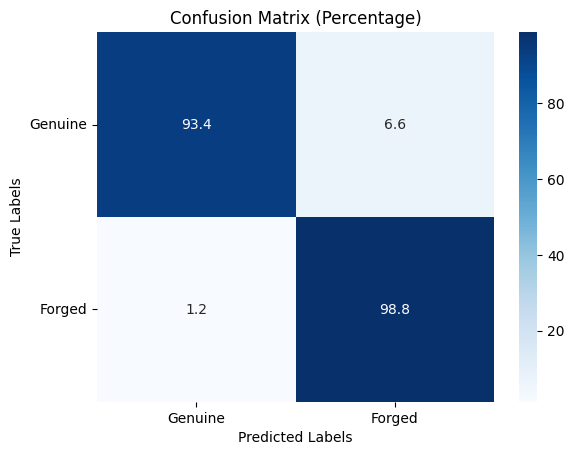

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       317
           1       0.94      0.99      0.96       327

    accuracy                           0.96       644
   macro avg       0.96      0.96      0.96       644
weighted avg       0.96      0.96      0.96       644



In [40]:
## On Train
#@title Forgery dataset train
folder = f'{forgery_path}/Train'
preds,labels = perform_voting_for_each_test_images(folder, forgery_path)

build_confusion_matrix(preds,labels)
print(classification_report(preds, labels))

# **Evaluation**

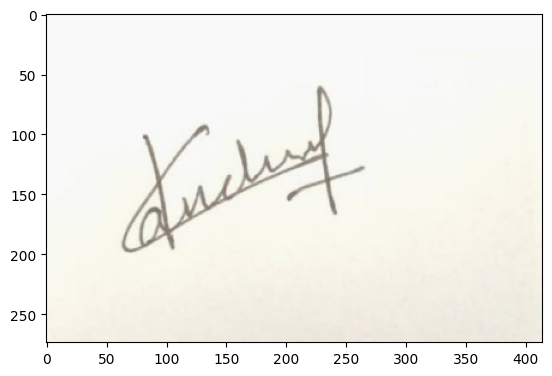

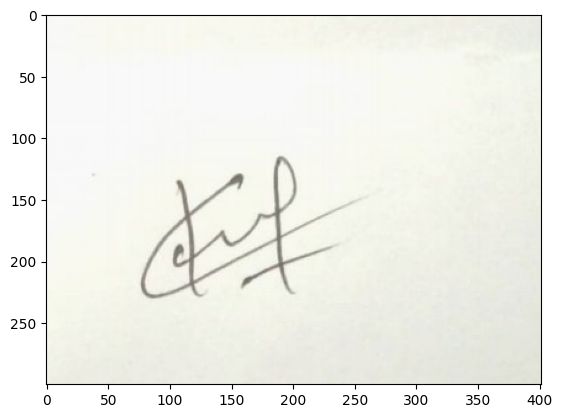

Model prediction: 0.9818328619003296
The signatures are likely not similar.


In [41]:

img1 = f"{forgery_path}/Test/3/original_03_02.jpg"
img2 = f"{forgery_path}/Test/3/forge_03_02.jpg"
get_predictions_for_single(img1, img2, model_rms)

In [42]:
folder = f'{forgery_path}/Test'
test_df = get_genuine_with_class(folder)
test_image = f'{forgery_path}/Test/3/forge_03_02.jpg'
desired_df = get_genuine_and_test_images_for_class(test_df, "23",test_image)
# Create an instance of the GenuineTestDataset
dataset = GenuineTestDataset(desired_df, transform=transformation)

# Create a DataLoader for batching and loading the data
dataloader = DataLoader(dataset, batch_size=1)


len(dataloader)
evaluation_voting(model_rms, dataloader)

0it [00:00, ?it/s]

Positive Votes: 0 	 Negative votes: 0


'Forged'

# References 


1. Guide to Siamese Neural Networks: https://medium.com/@rinkinag24/a-comprehensive-guide-to-siamese-neural-networks-3358658c0513

2. Signature Verification: https://heartbeat.comet.ml/handwritten-signature-verification-9f7f9c5df008

3. Chattopadhyay, Soumitri, et al. “SURDS: Self-Supervised Attention-guided Reconstruction and Dual Triplet Loss for Writer Independent Offline Signature Verification.” arXiv preprint arXiv:2201.10138 (2022).

4. Xiong, Yu-Jie, and Song-Yang Cheng. "Attention based multiple siamese network for offline signature verification." In Document Analysis and Recognition–ICDAR 2021: 16th International Conference, Lausanne, Switzerland, September 5–10, 2021, Proceedings, Part III 16, pp. 337-349. Springer International Publishing, 2021.


### Sancharika Debnath
[Resume](https://shorturl.at/puER9)
[LinkedIn](https://www.linkedin.com/in/sancharika-debnath/)
[GitHub](https://github.com/sancharika/)
[Portfolio](https://sancharika.github.io/)